In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
from matplotlib import pyplot as plt
import random

In [167]:
RANDOM_STATE=42

try:
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
except:
    pass

In [3]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})

df_test = pd.read_csv('test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


检查数据集，发现是属性特征+文本特征。且属性特征存在缺失值。

In [4]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df_train["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

keyword, location都存在缺失值，且location的确实值比例到达了30%。

<AxesSubplot:xlabel='count', ylabel='keyword'>

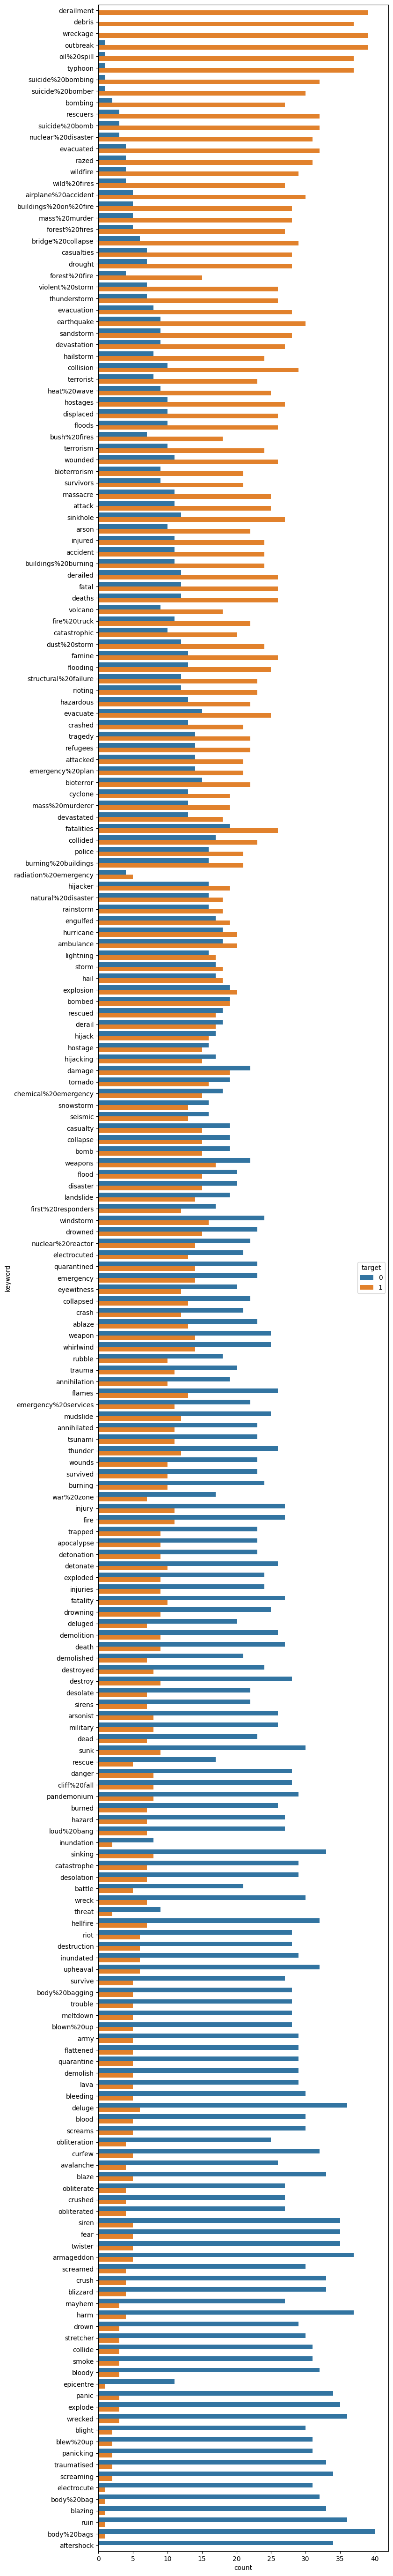

In [7]:
fig = plt.figure(figsize=(8, 72), dpi=100)
# 获取keyword的个数
# target_mean描述了keyword target对0-1的影响。
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

这个图是按照target均值降序排序的。可以看出keyword对target是有较大影响的。

## 2. Meta Features

In [8]:
df_train["type"] = "train"
df_test["type"] = "test"
df_all = pd.concat([df_train, df_test], axis=0)
df_all = df_all.reset_index()

2. 元特征
类和数据集中元特征的分布有助于识别灾难推文。 与非灾难推文相比，灾难推文看起来以更正式的方式编写，字词更长，因为其中大部分来自新闻机构。 非灾难推文比灾难推文有更多的拼写错误，因为它们来自个人用户。 用于分析的元特征是；

word_count 文本中的单词数
unique_word_count 文本中唯一单词的数量
stop_word_count 文本中停用词的数量
url_count 文本中的 url 数量
mean_word_length 平均字数
char_count 文本中的字符数
punctuation_count 文本中的标点数
hashtag_count 文本中的主题标签数 (#)
mention_count 文本中的提及次数 (@)

In [9]:
import string
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

# word_count
df_all['word_count'] = df_all["text"].apply(lambda x:len(str(x).split()))
# unique_word_count
df_all['unique_word_count'] = df_all['text'].apply(lambda x: len(set(str(x).split())))
# stop_word_count
df_all['stop_word_count'] = df_all['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# url_count # url的个数
df_all['url_count'] = df_all['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# mean_word_length 平均字符长度
df_all['mean_word_length'] = df_all['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# char_count # 字符个数
df_all['char_count'] = df_all['text'].apply(lambda x: len(str(x)))
# punctuation_count 标点符号
df_all['punctuation_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# hashtag_count
df_all['hashtag_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
# mention_count
df_all['mention_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


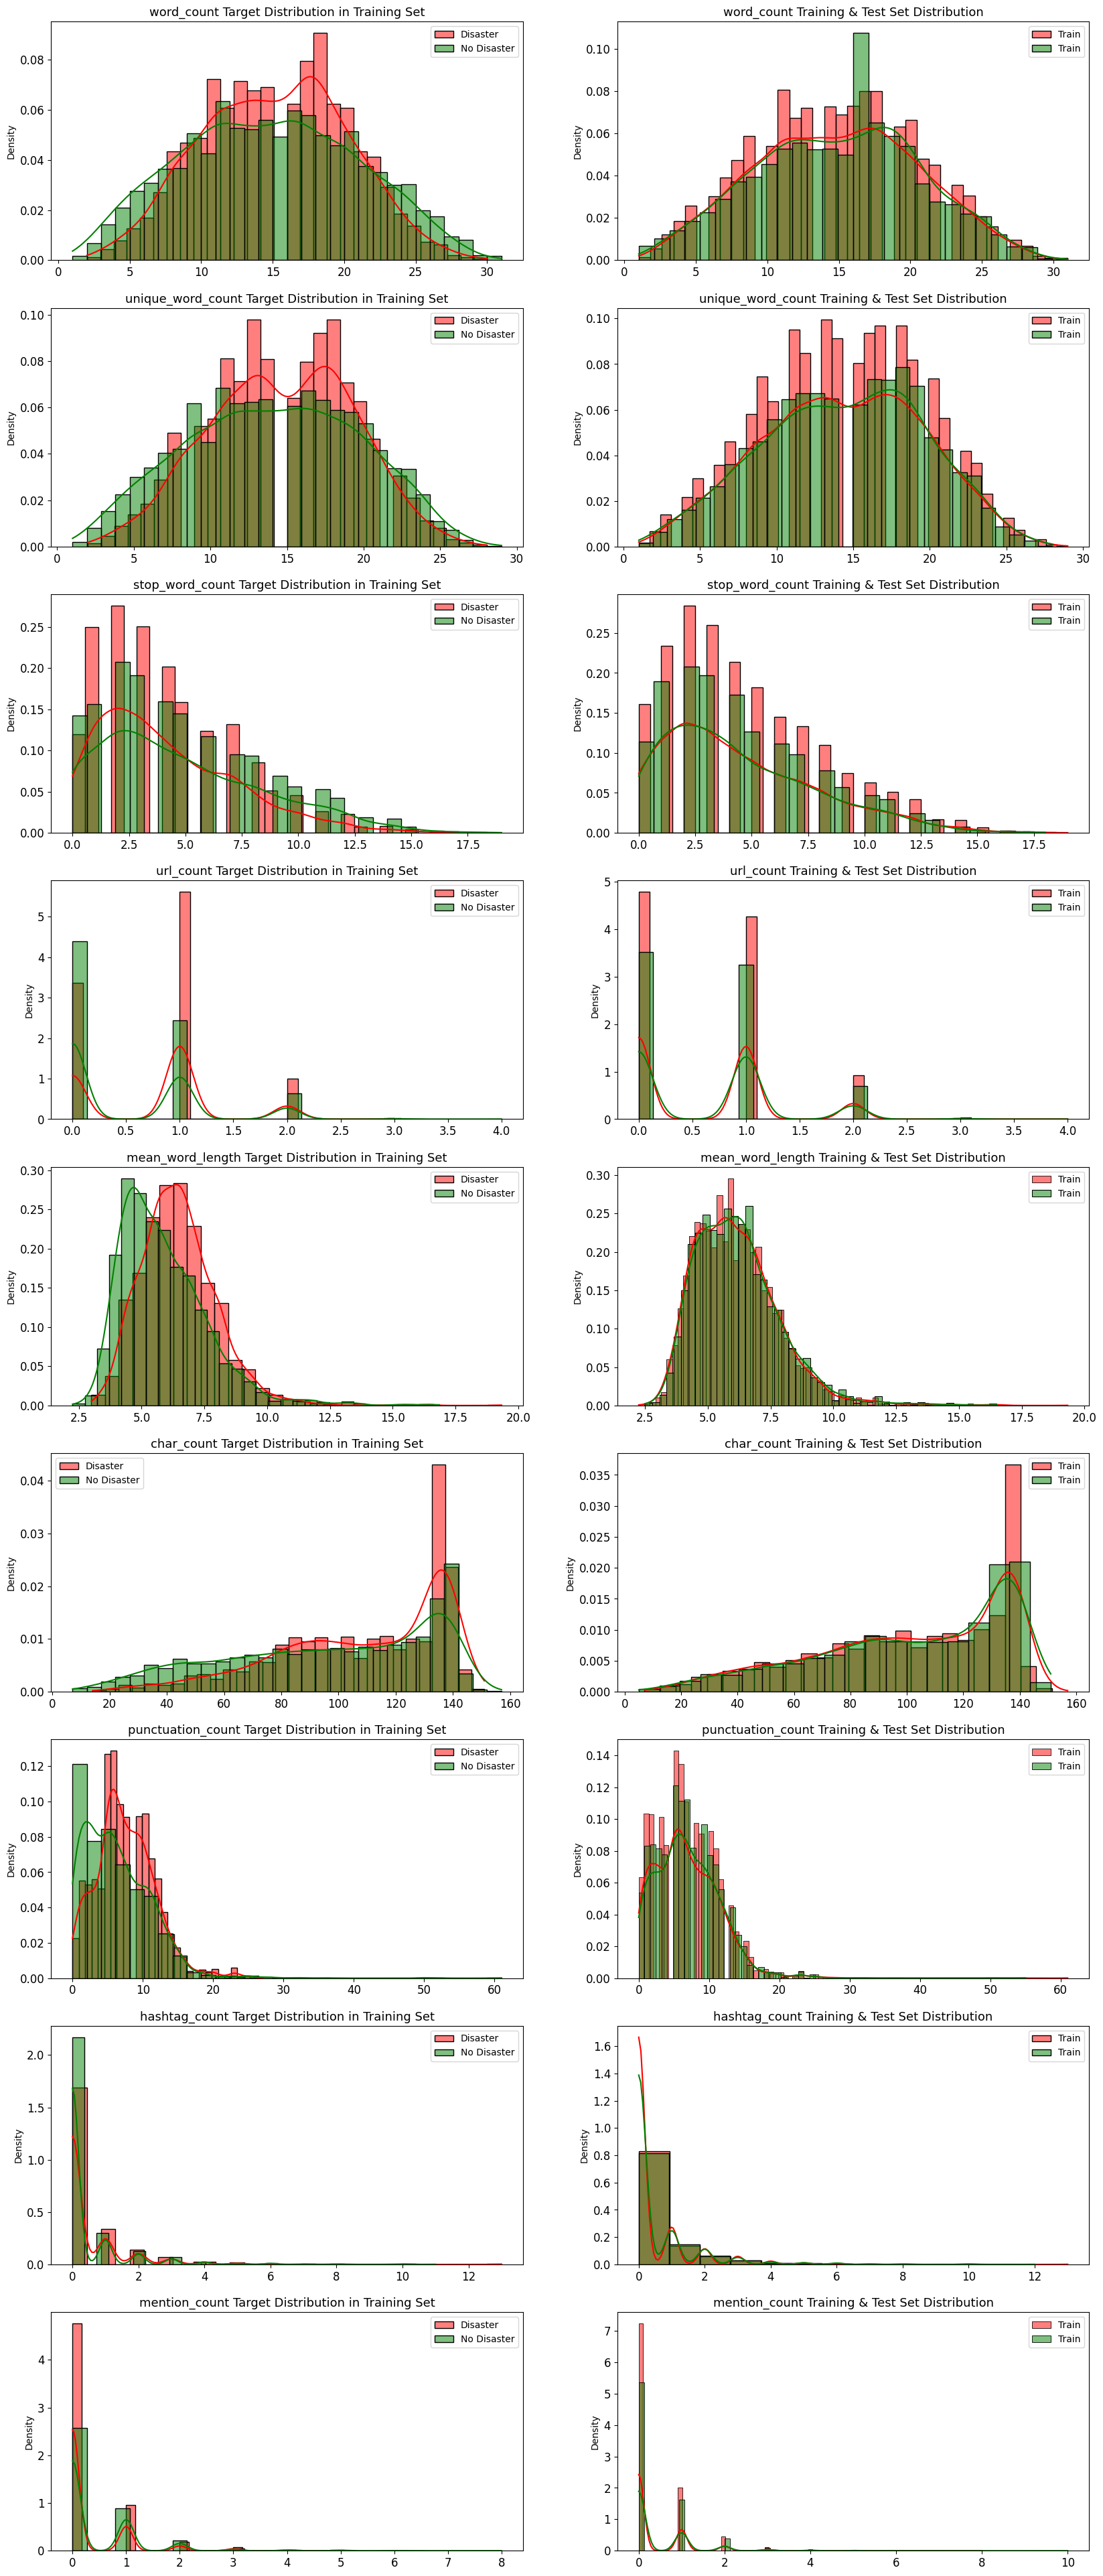

In [10]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_all['target'] == 1
TRAIN_TWEETS = df_all['type'] == "train"

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.color_palette("pastel")
    sns.histplot(data=df_all, x=df_all.loc[DISASTER_TWEETS&TRAIN_TWEETS,feature], ax=axes[i][0], kde=True, label="Disaster", color="red",stat="density", bins=30)
    sns.histplot(data=df_all, x=df_all.loc[(~DISASTER_TWEETS)&TRAIN_TWEETS,feature], ax=axes[i][0], kde=True, label="No Disaster", color="green",stat="density", bins=30)
    

    sns.histplot(data=df_all, x=df_all.loc[TRAIN_TWEETS,feature], ax=axes[i][1], kde=True, label="Train", color="red",stat="density")
    sns.histplot(data=df_all, x=df_all.loc[~TRAIN_TWEETS,feature], ax=axes[i][1], kde=True, label="Train", color="green",stat="density")
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

所有的元特征在训练和测试集中都有非常相似的分布，这也证明了训练和测试集来自同一个样本。

所有的元特征也都有关于target的信息，但其中一些还不够好，例如 url_count、hashtag_count 和mention_count。

另一方面，word_count、unique_word_count、stop_word_count、mean_word_length、char_count、punctuation_count 对于灾难和非灾难推文有非常不同的分布。 这些功能可能在模型中很有用。

这些统计特征对target的影响相当于构造特征，然后分析特征重要性
训练集、测试集的比较是在查看分布。这些功能可以使用现有工具完成：

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



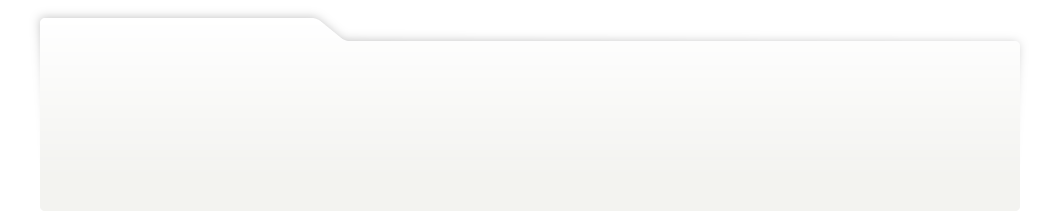
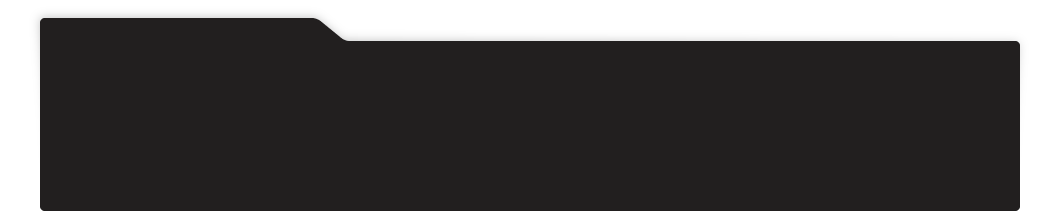
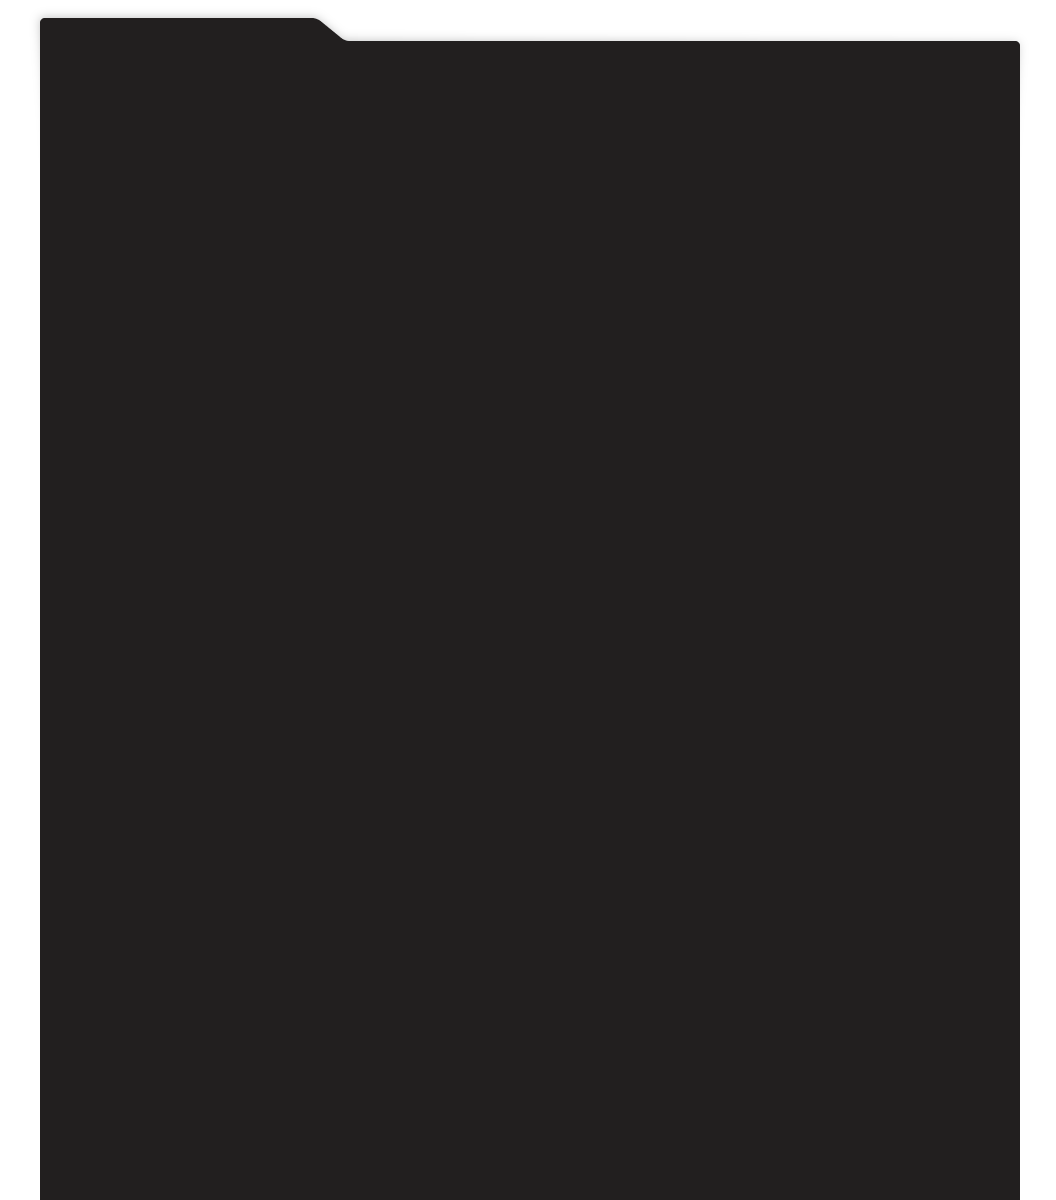
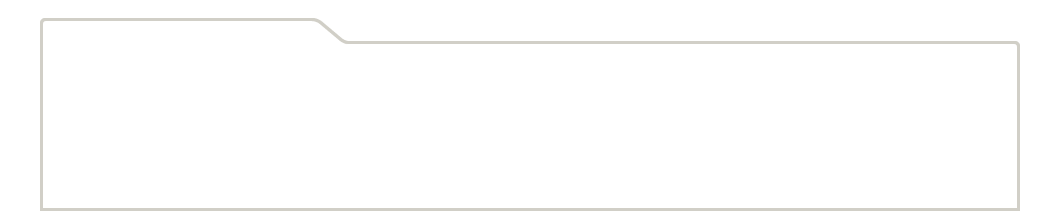
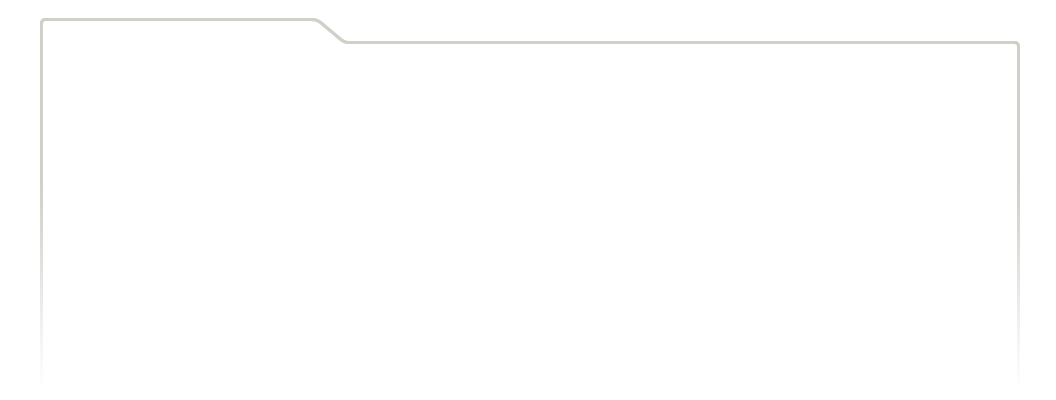
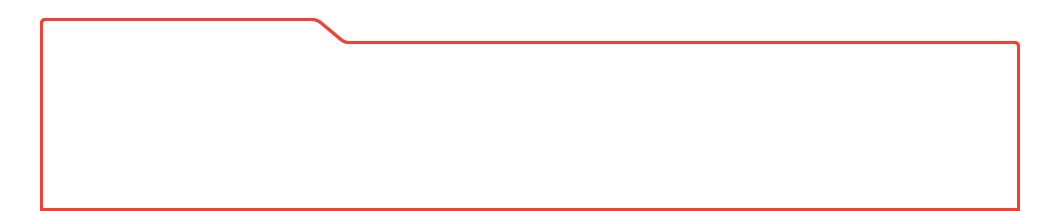
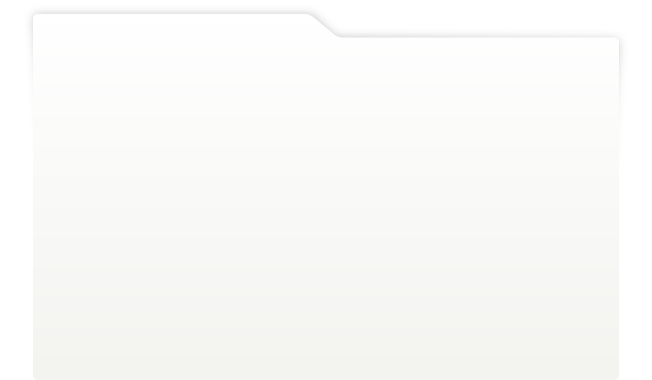
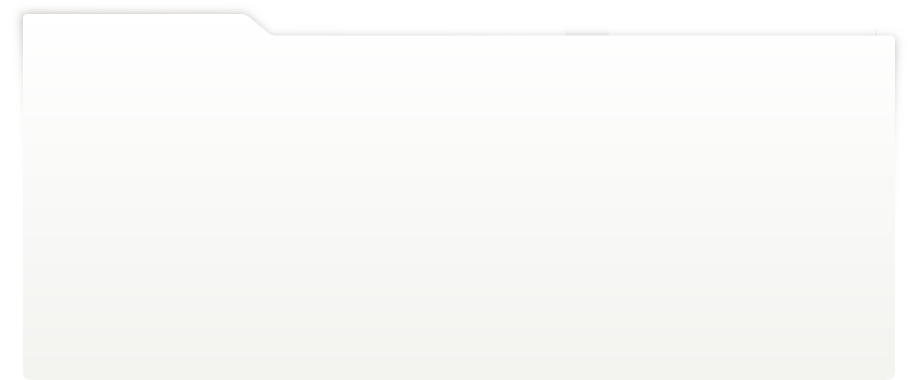
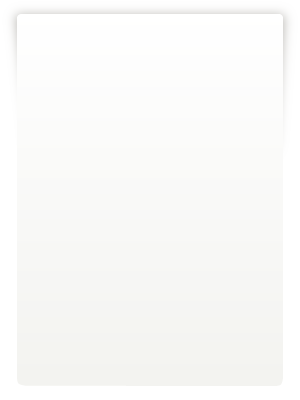
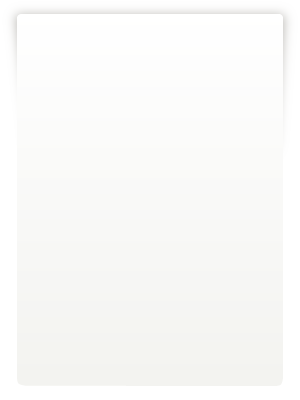
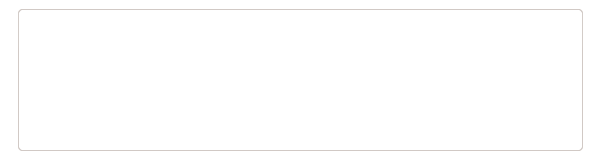
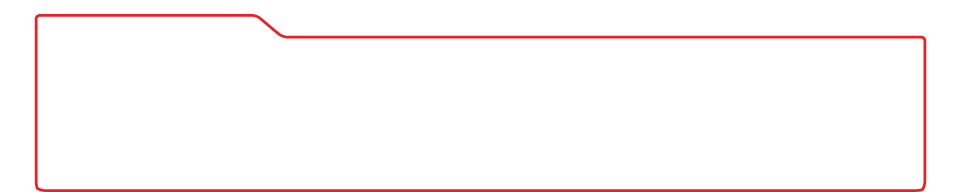
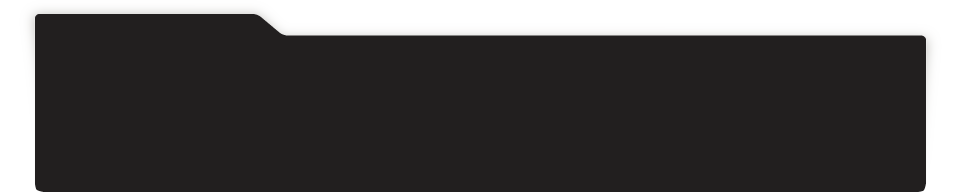
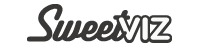
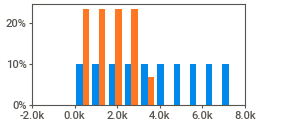
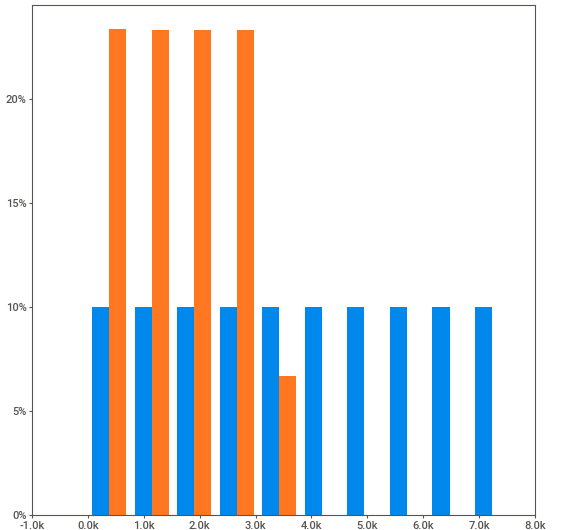
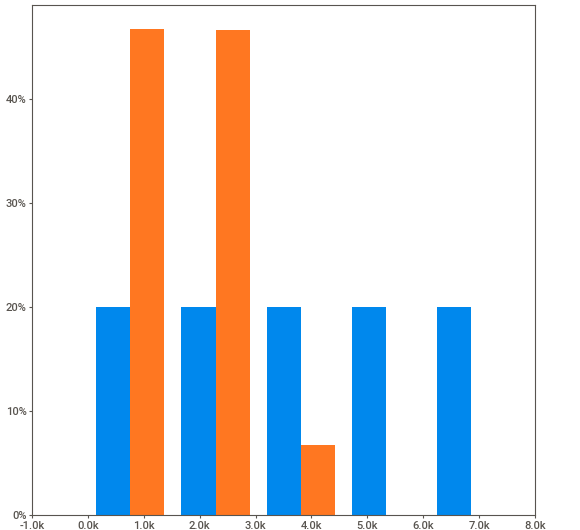
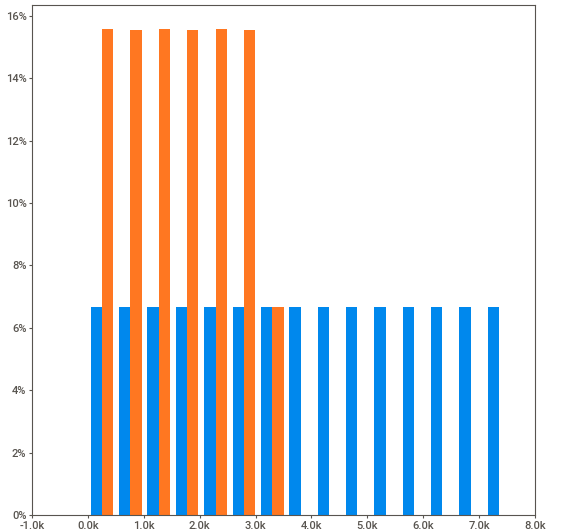
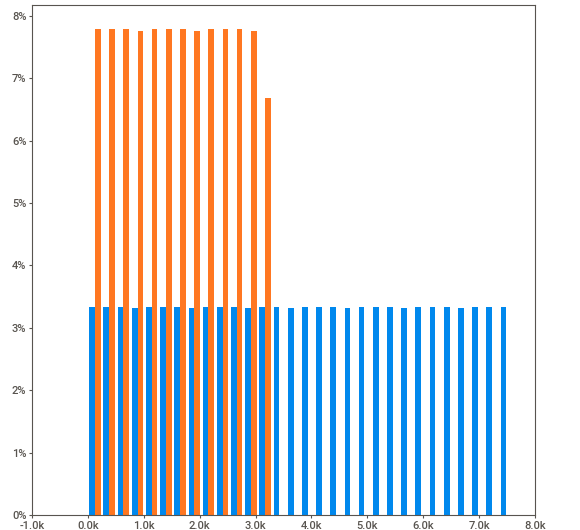
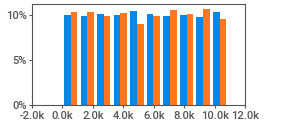
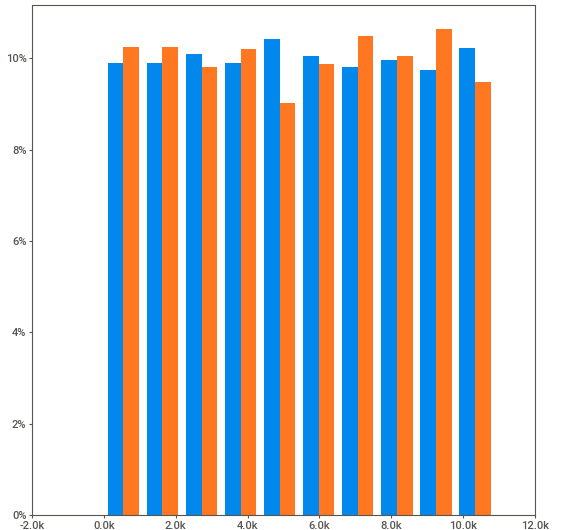
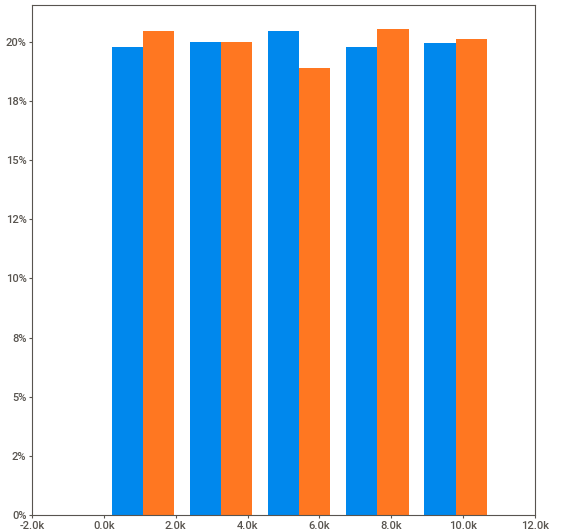
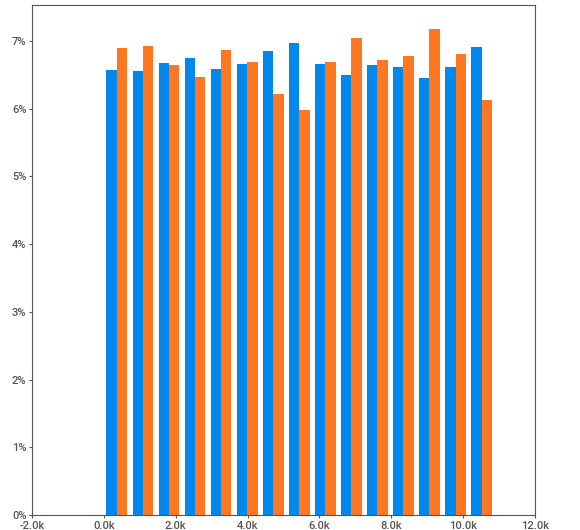
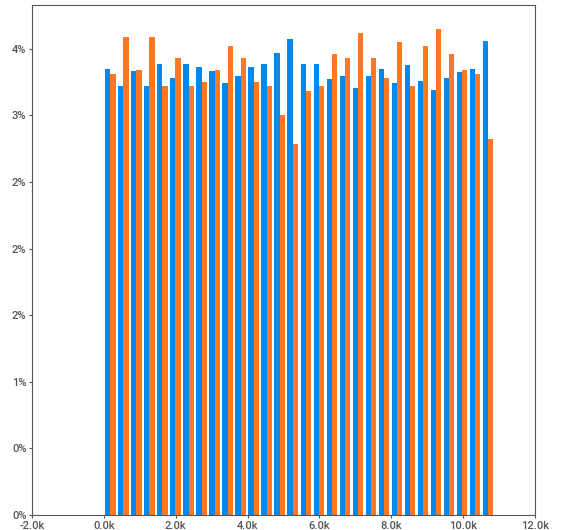
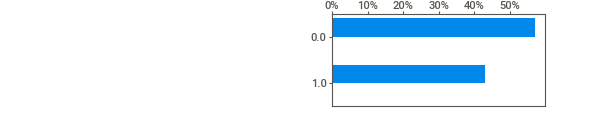
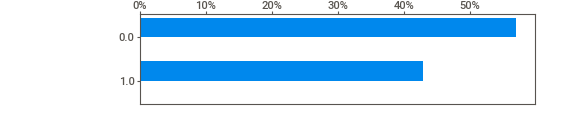
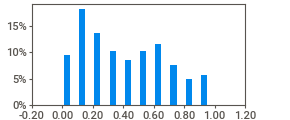
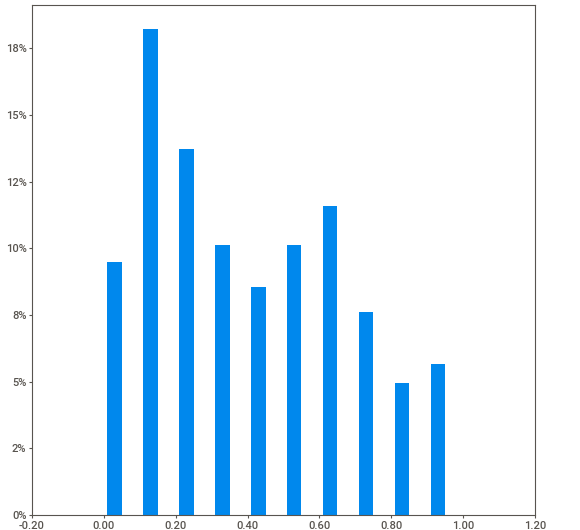
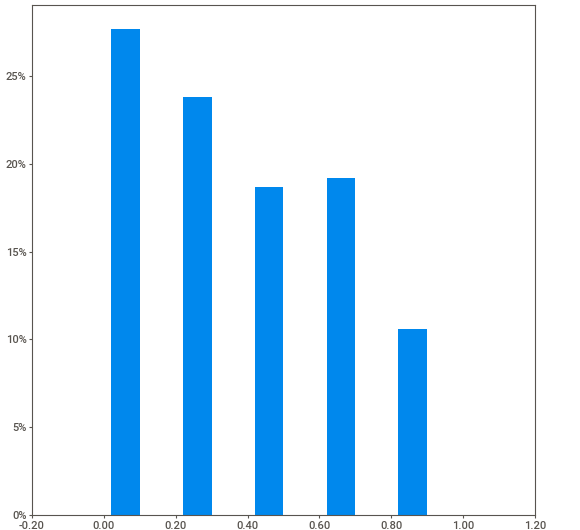
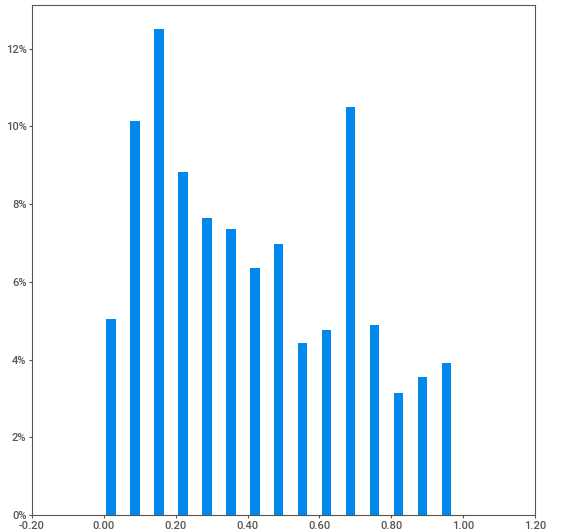
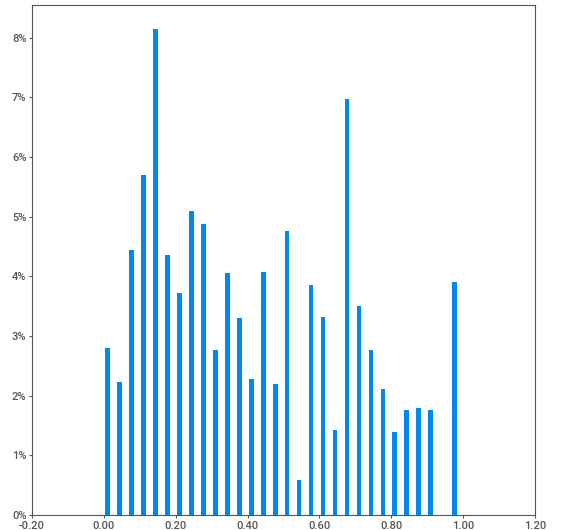
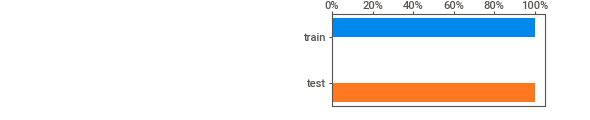
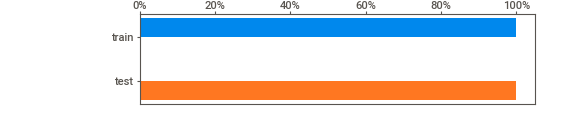
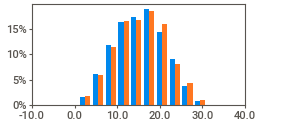
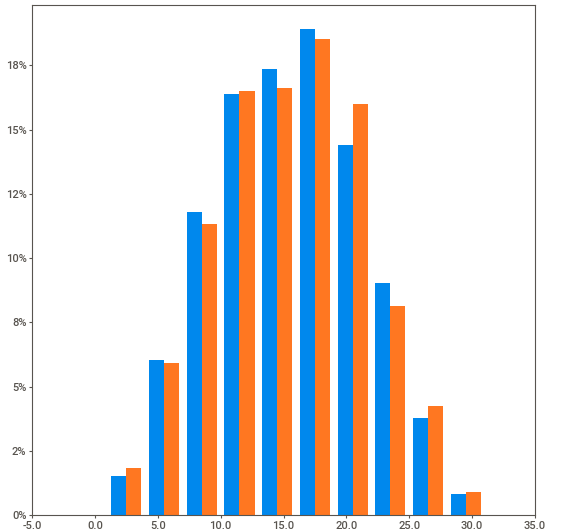
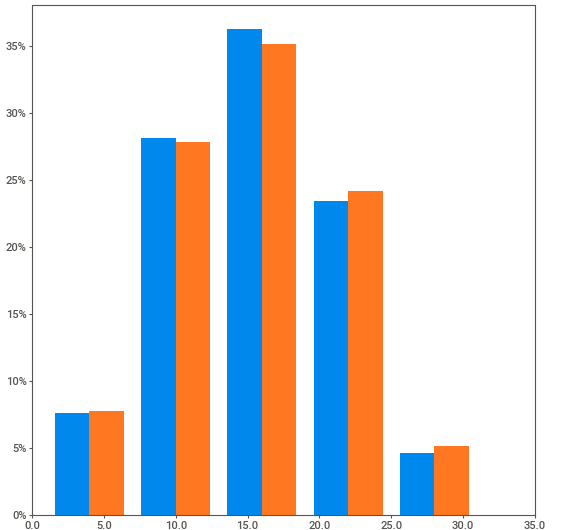
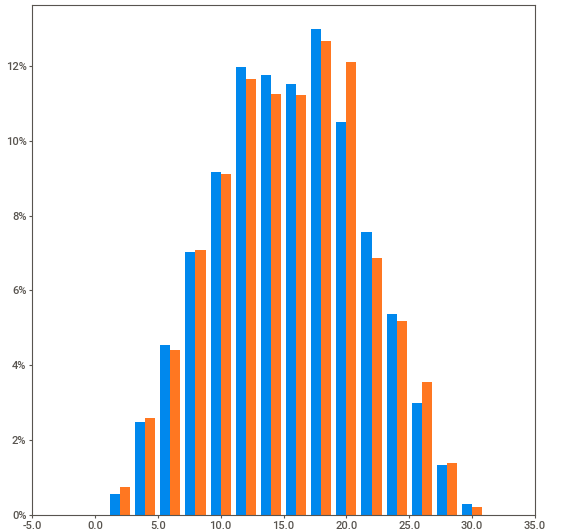
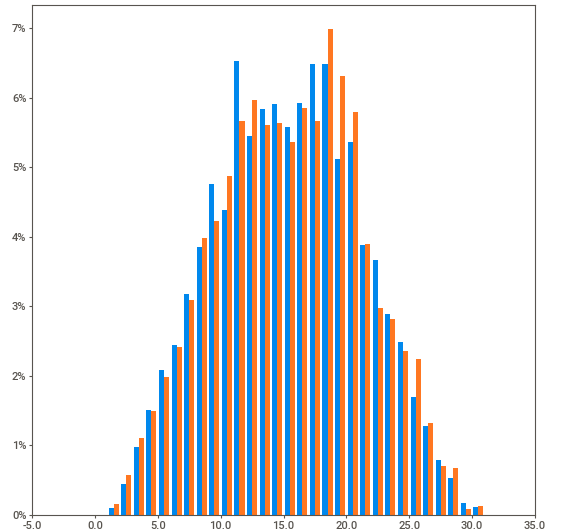
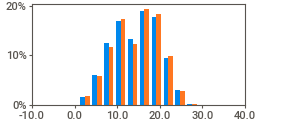
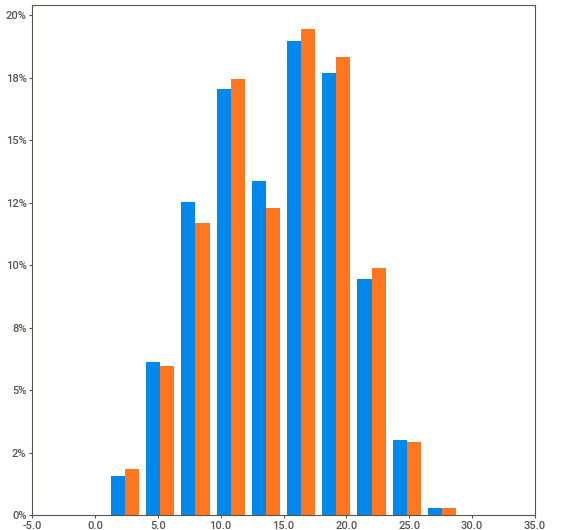
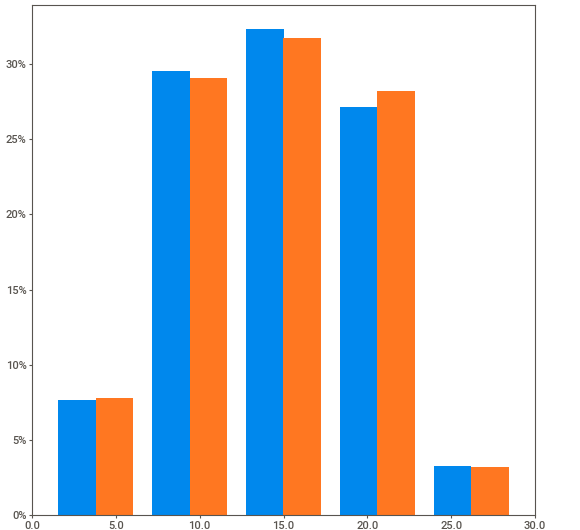
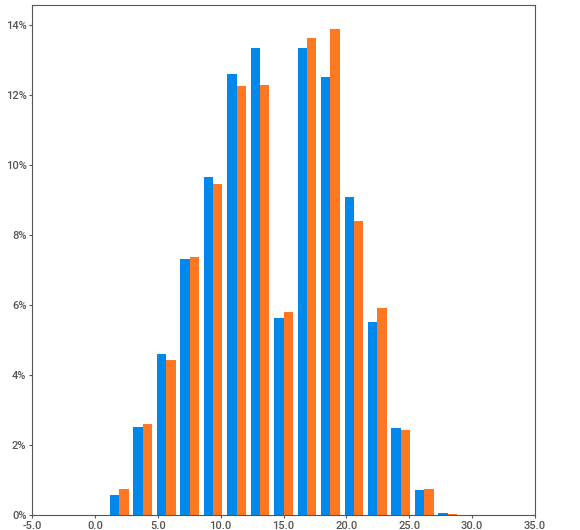
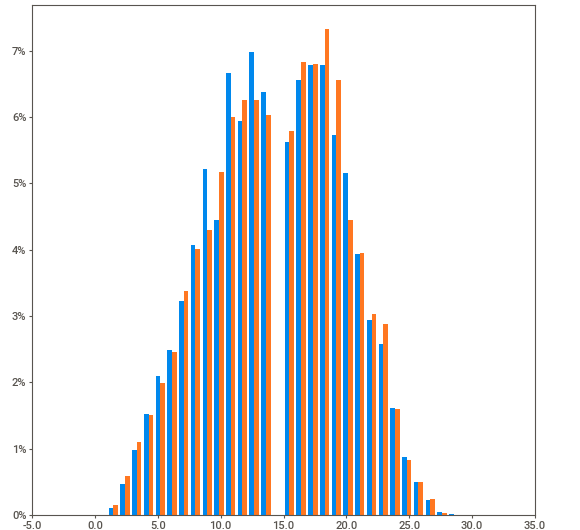
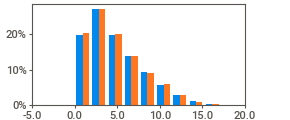
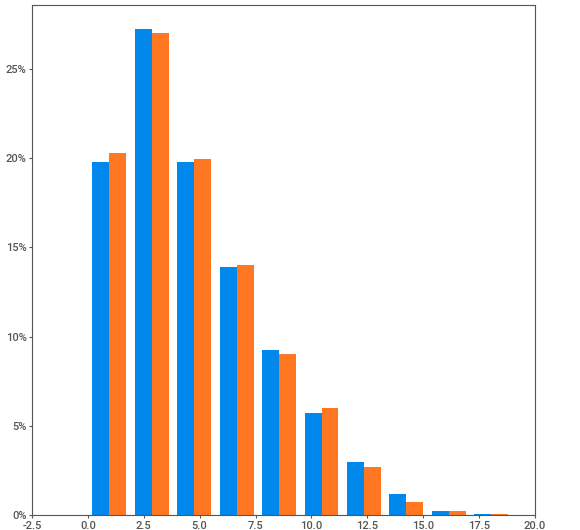
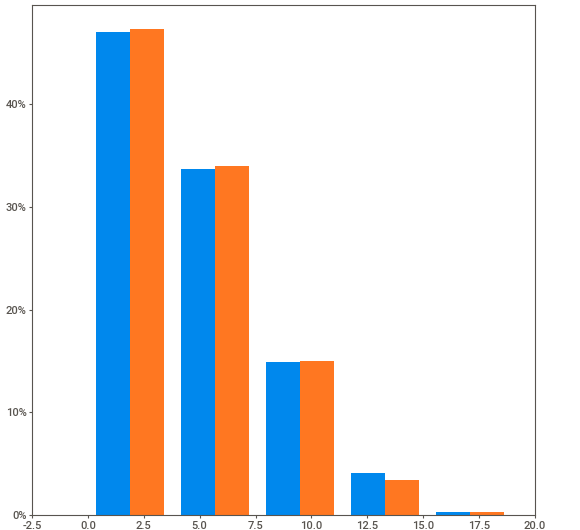
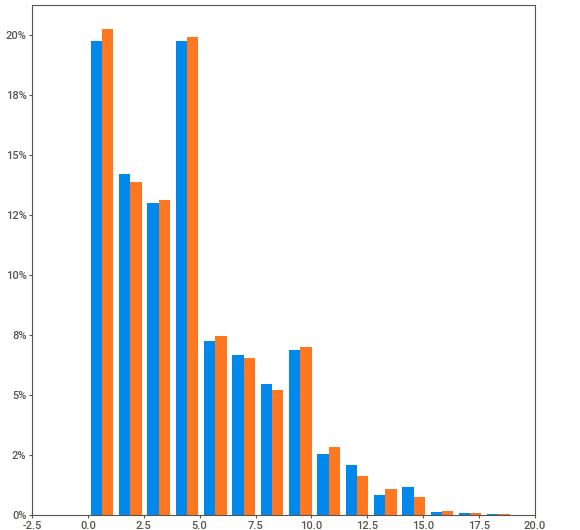
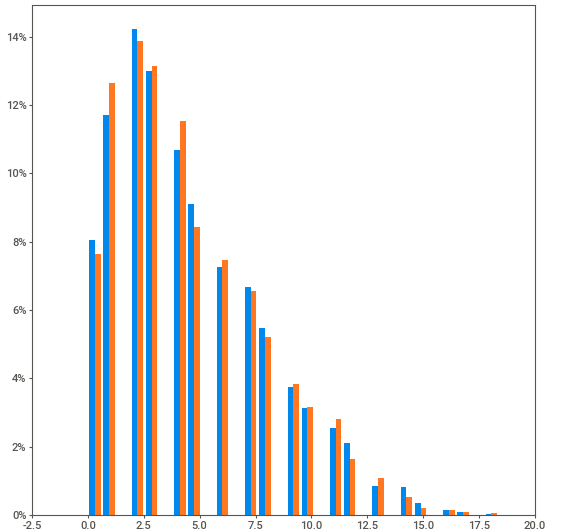
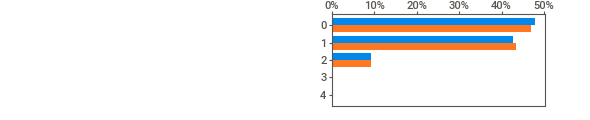
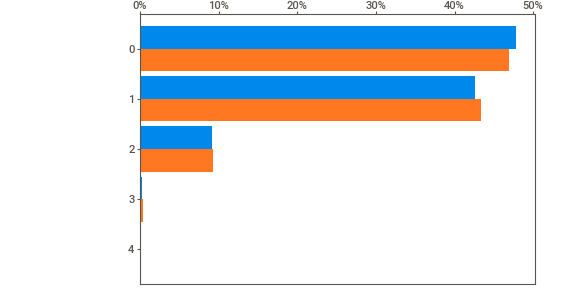
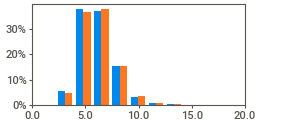
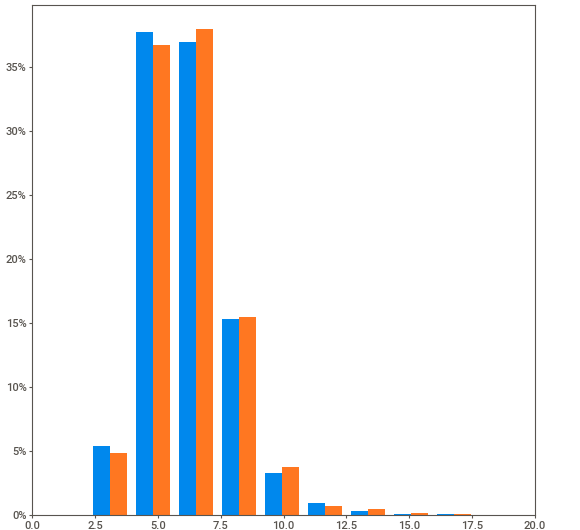
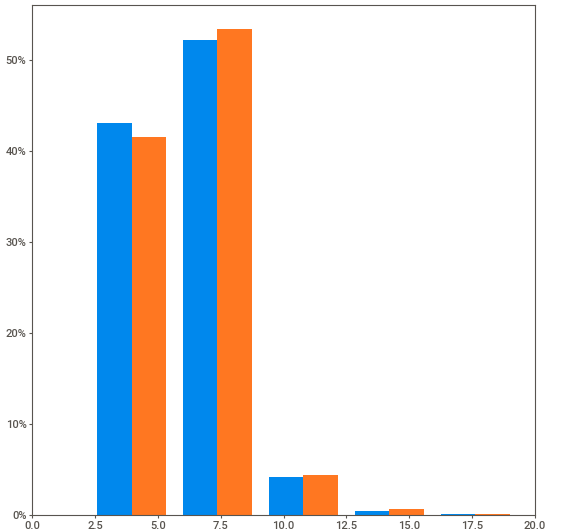
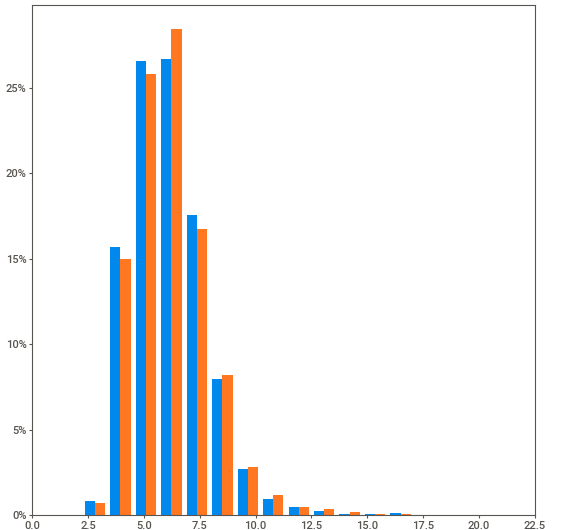
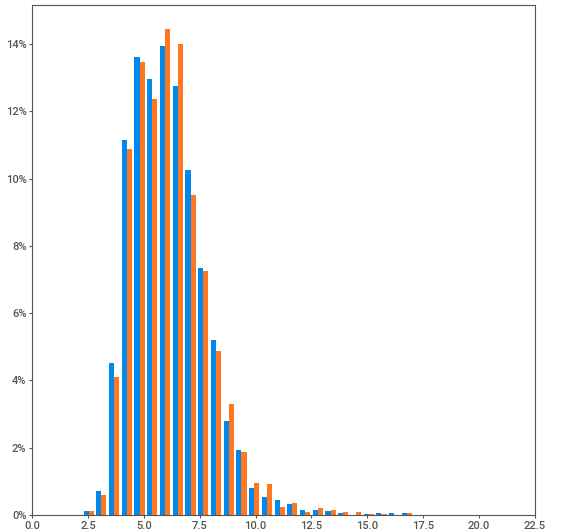
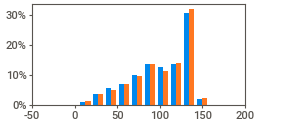
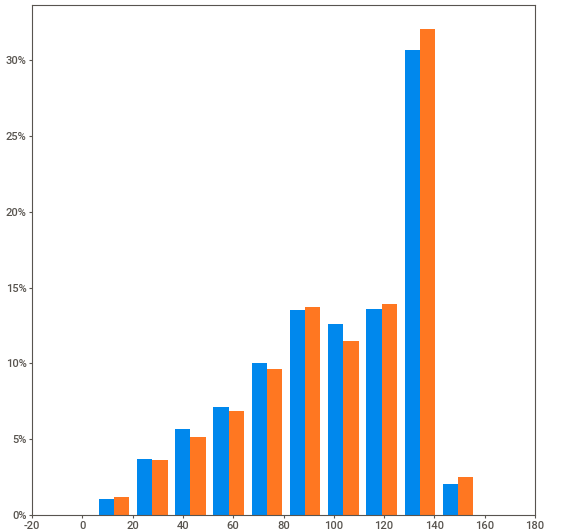
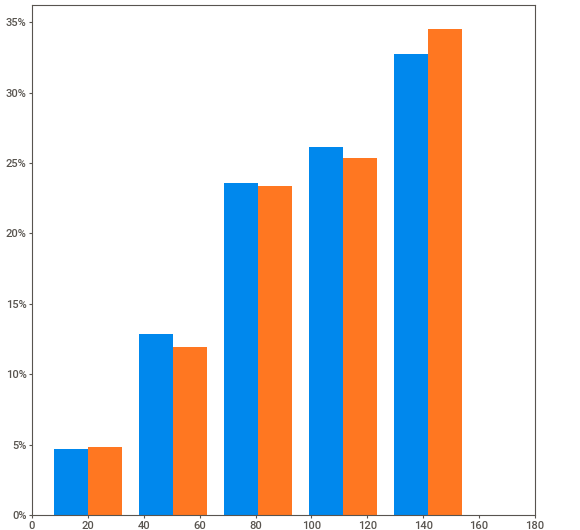
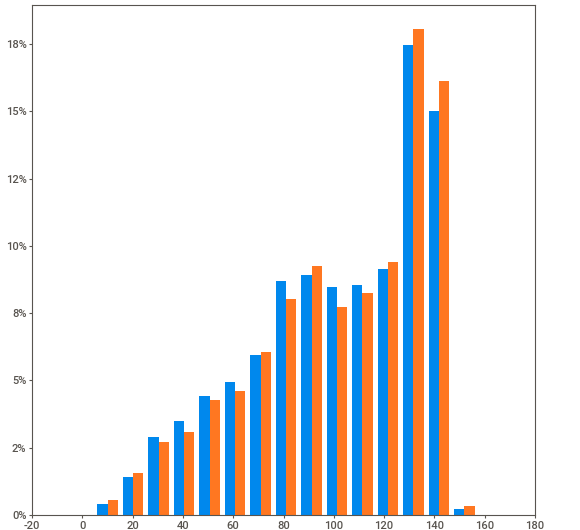
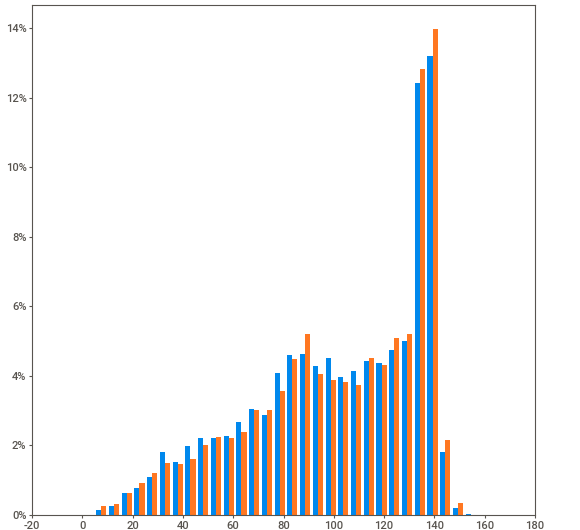
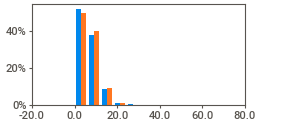
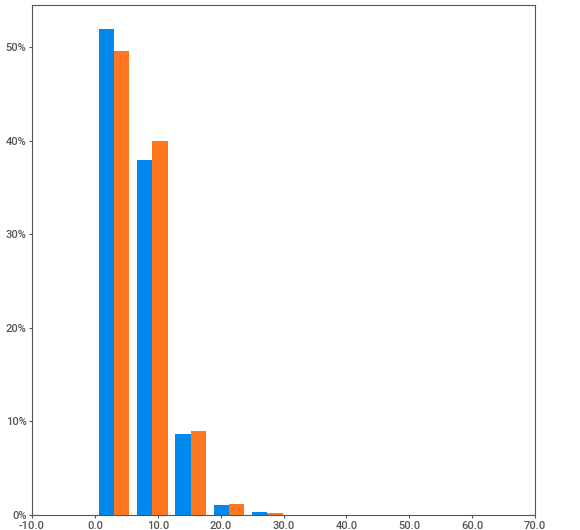
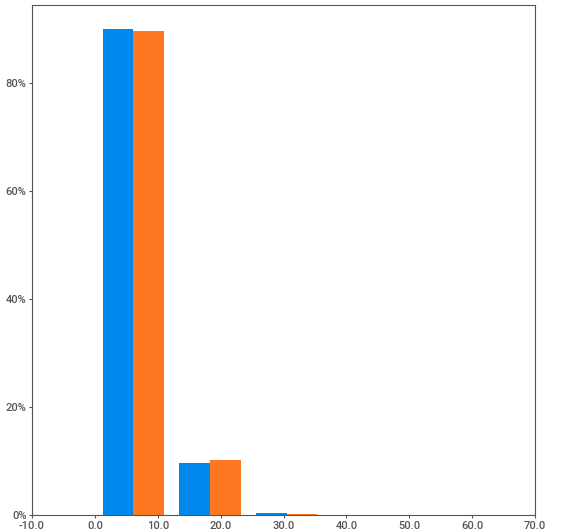
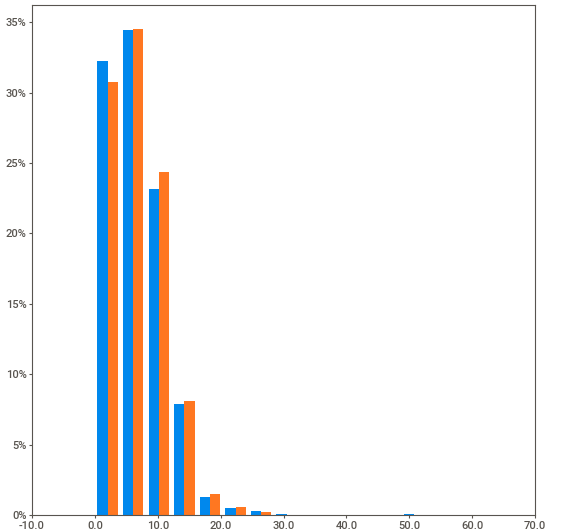
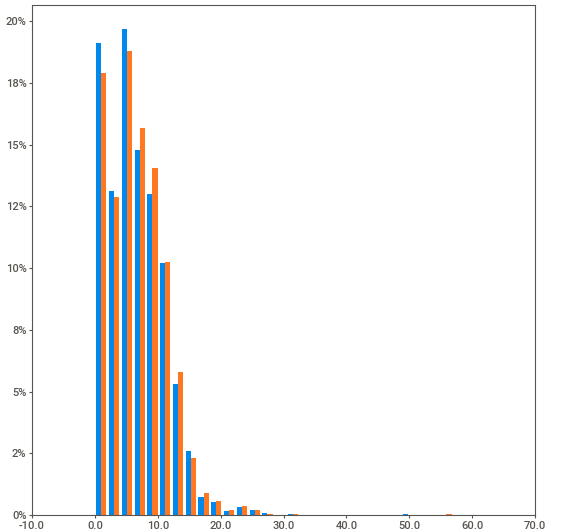
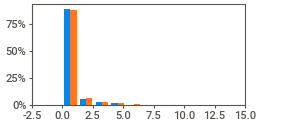
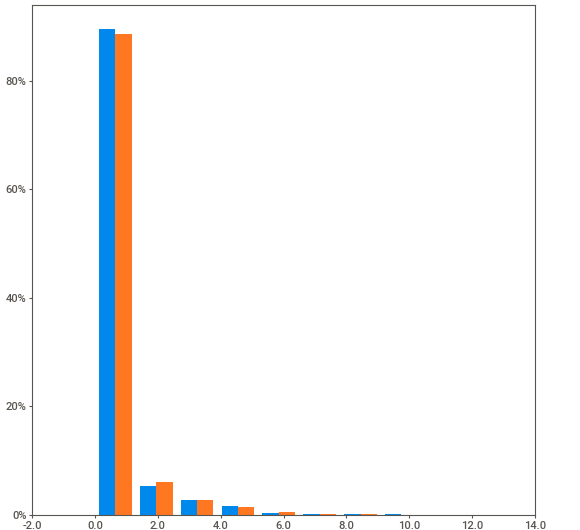
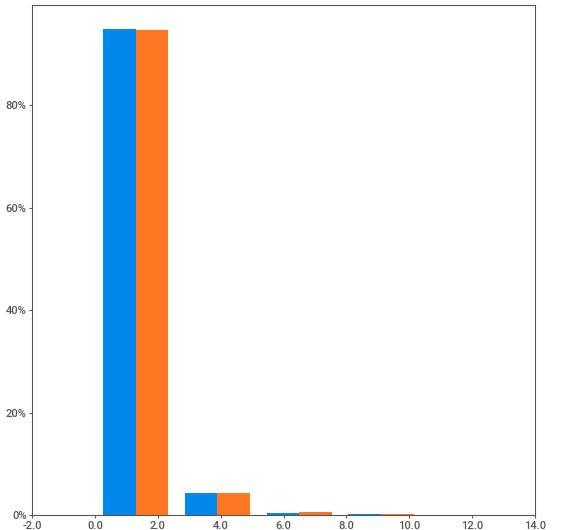
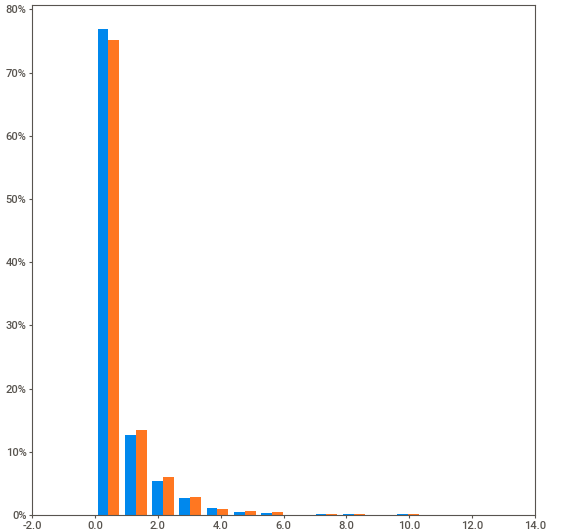
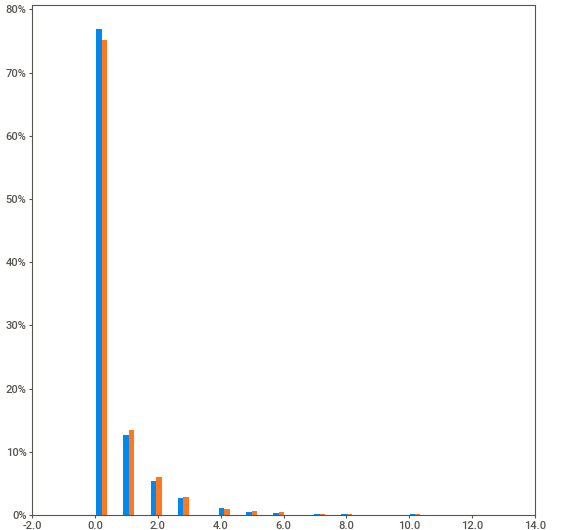
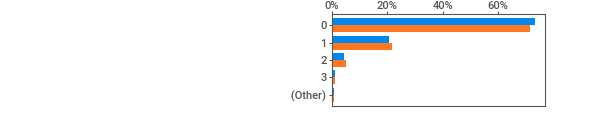
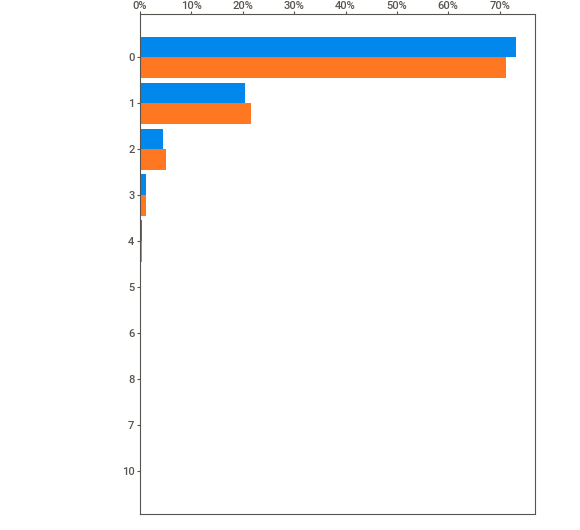
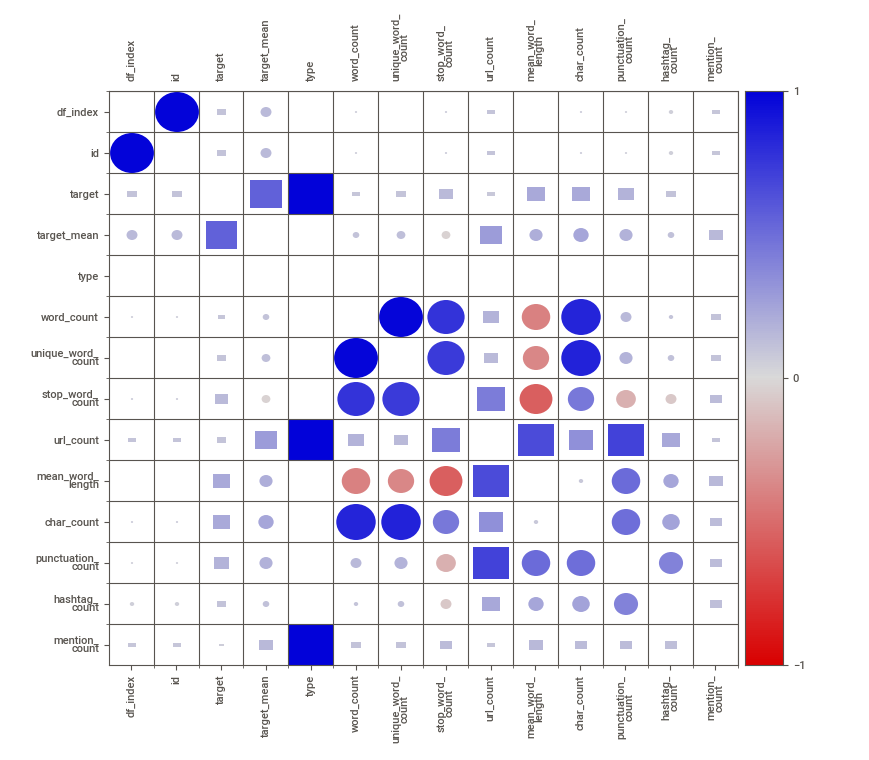
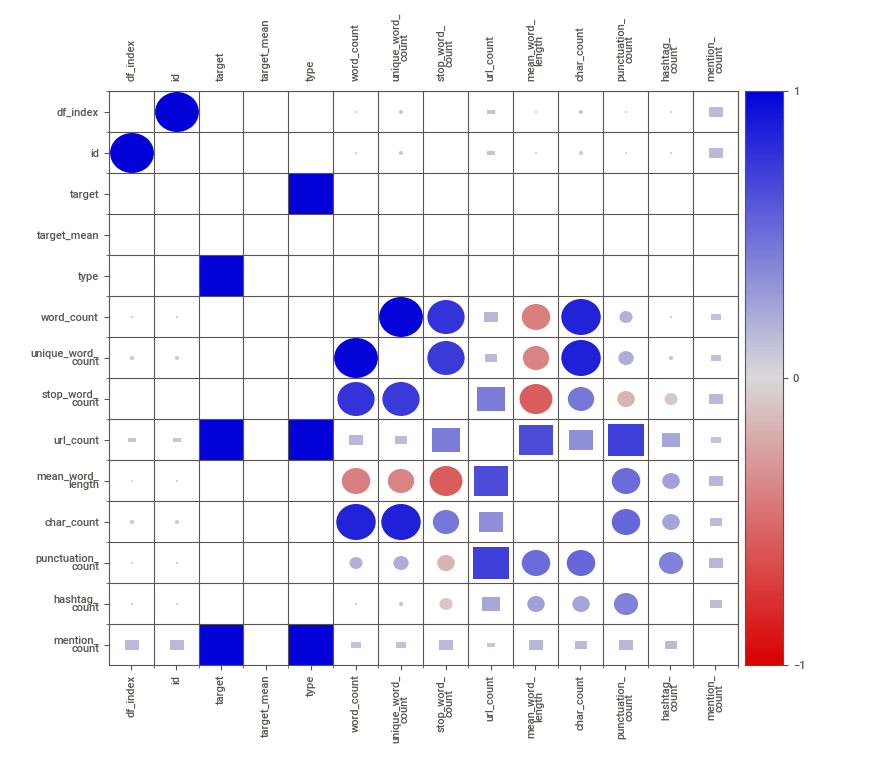

In [11]:
# 分析对比训练集和测试集
temp_report = sv.compare(df_all.loc[TRAIN_TWEETS], df_all.loc[~TRAIN_TWEETS])
temp_report.show_notebook()

In [12]:
# 分析df内部
my_report = sv.analyze(df_all.loc[TRAIN_TWEETS], target_feat="target")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



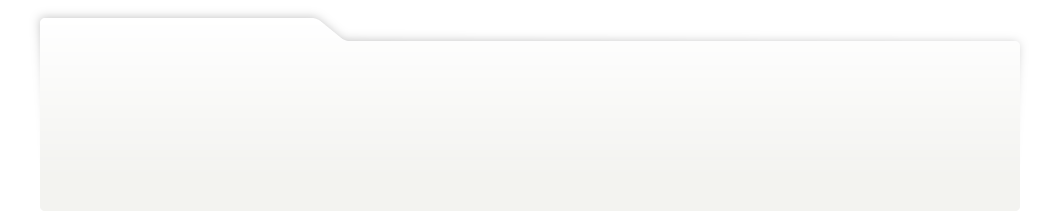
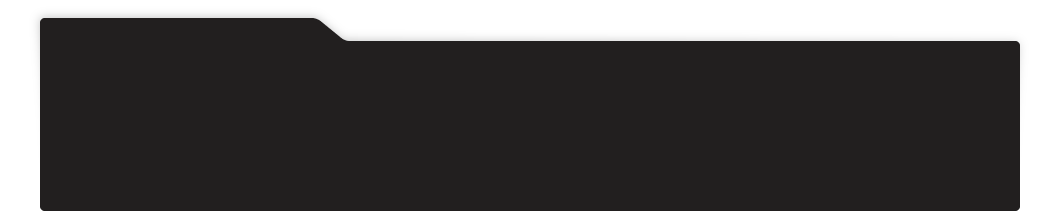
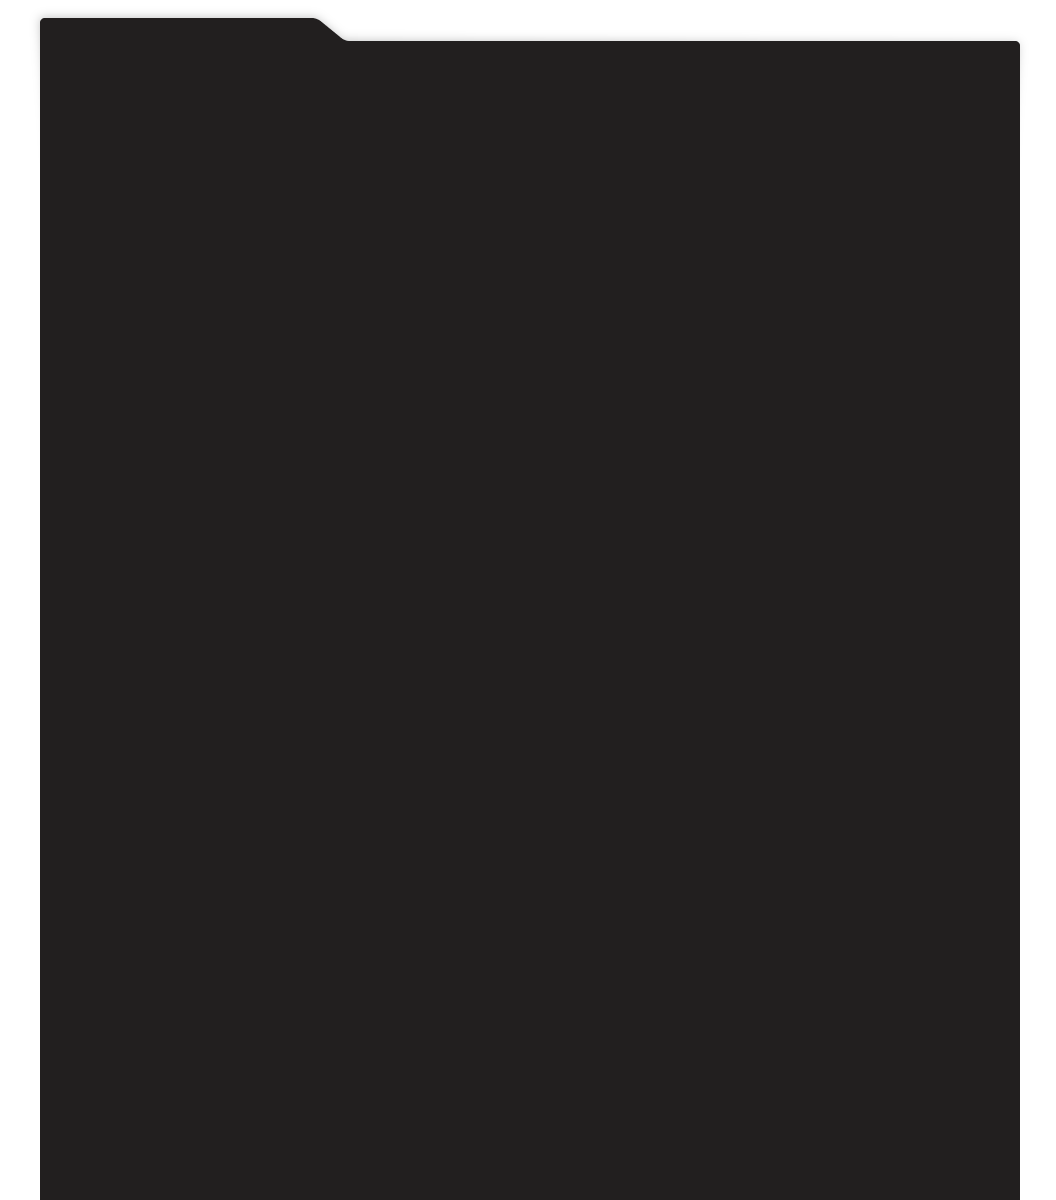
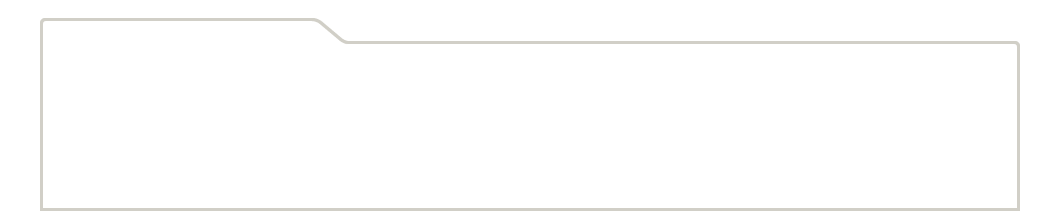
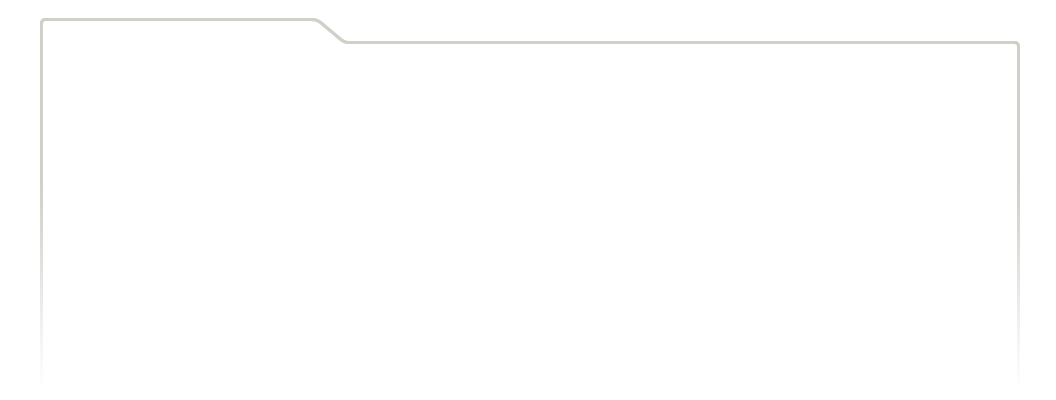
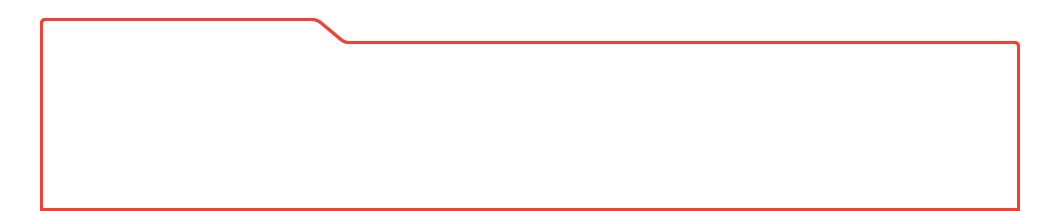
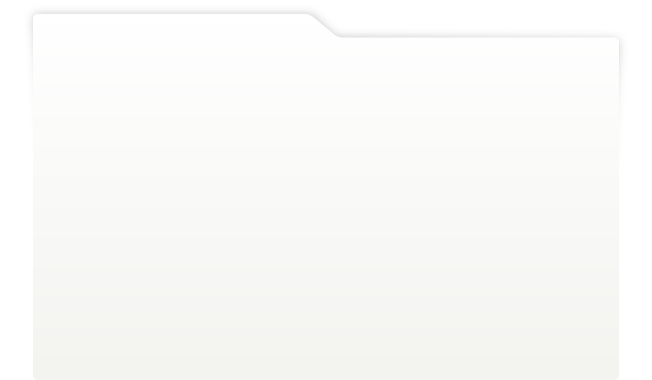
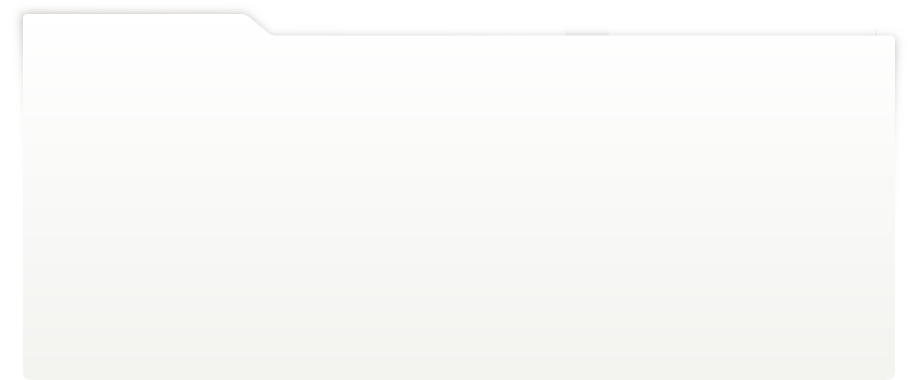
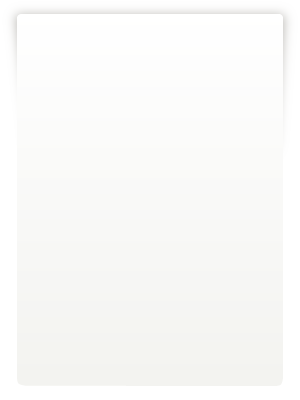
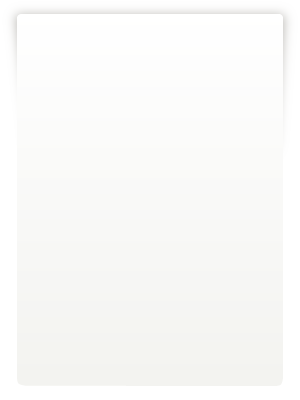
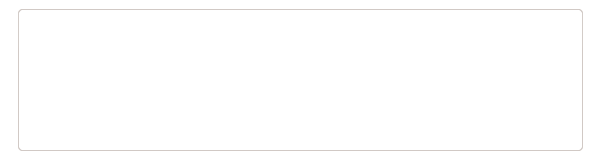
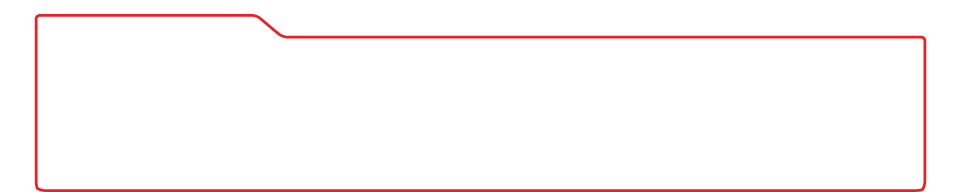
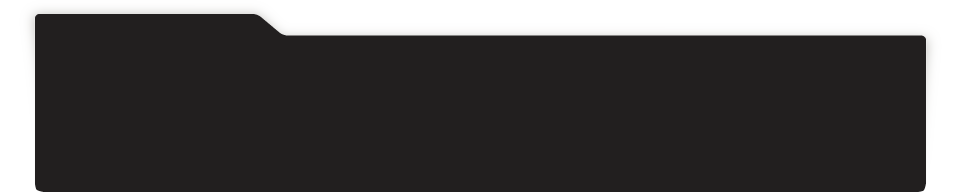
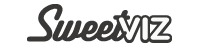
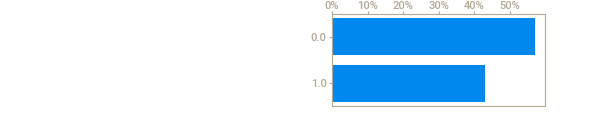
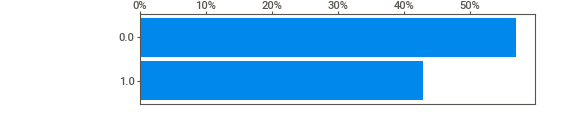
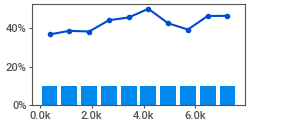
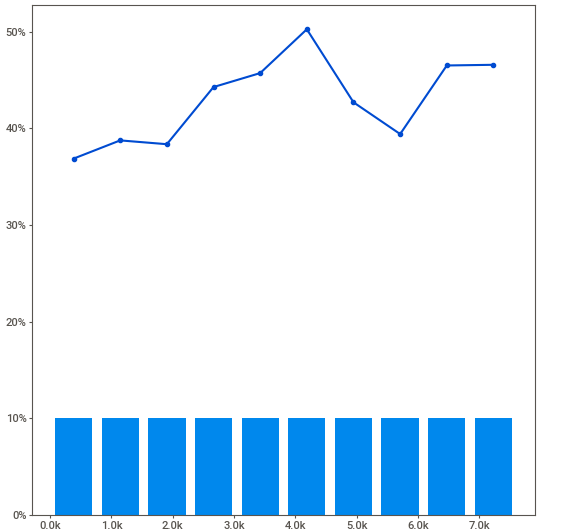
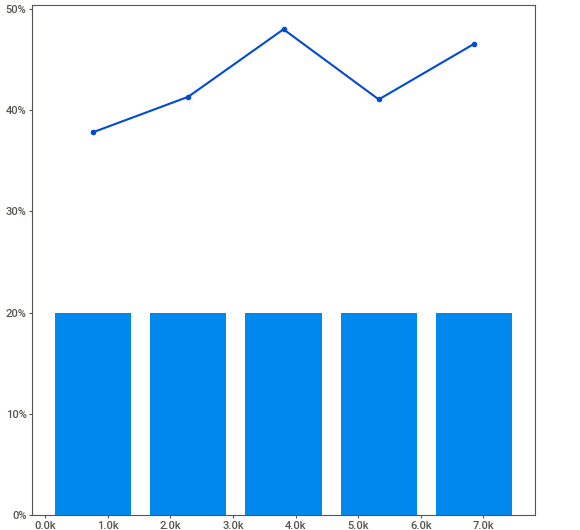
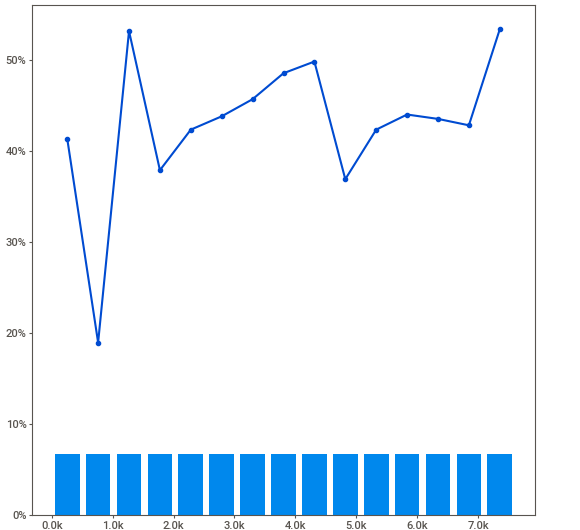
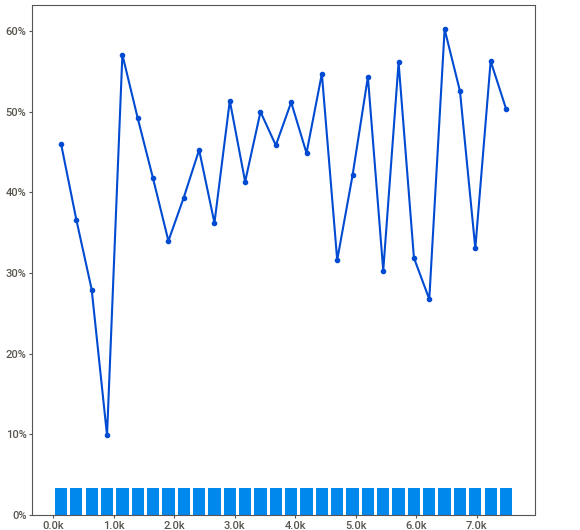
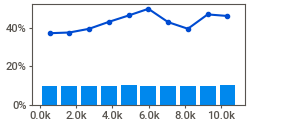
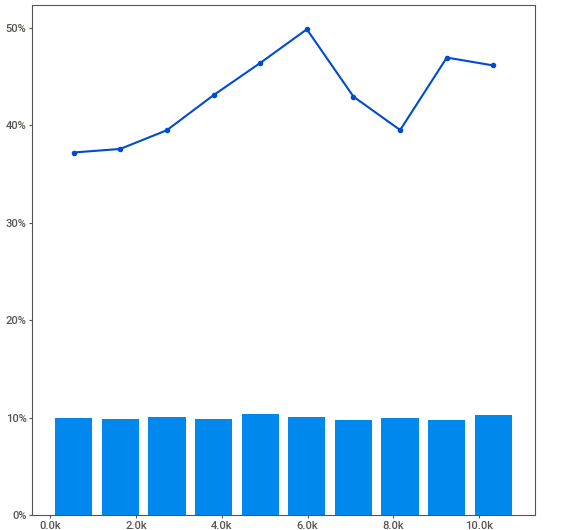
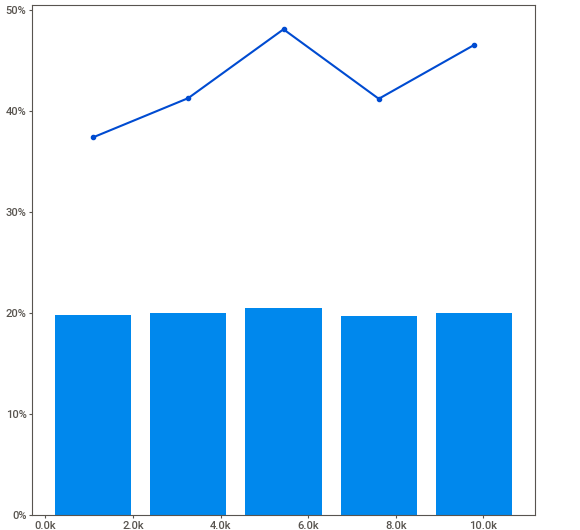
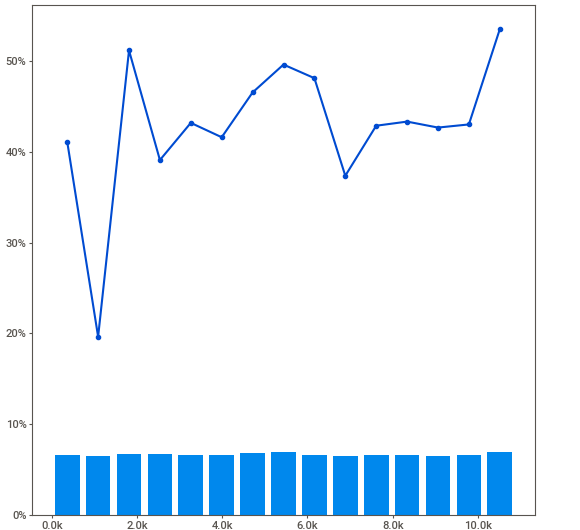
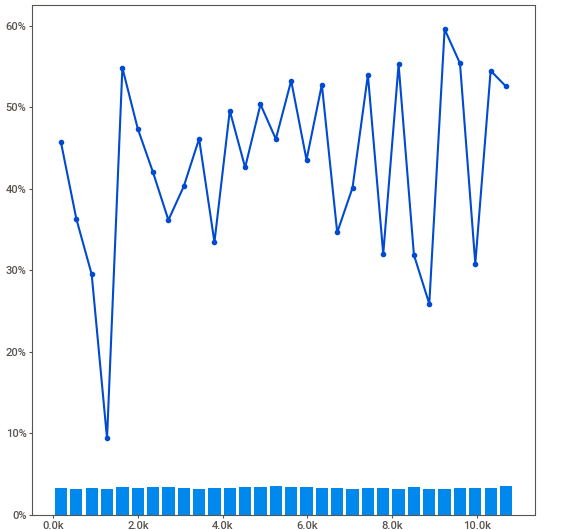
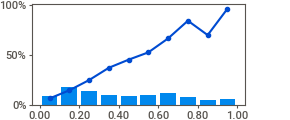
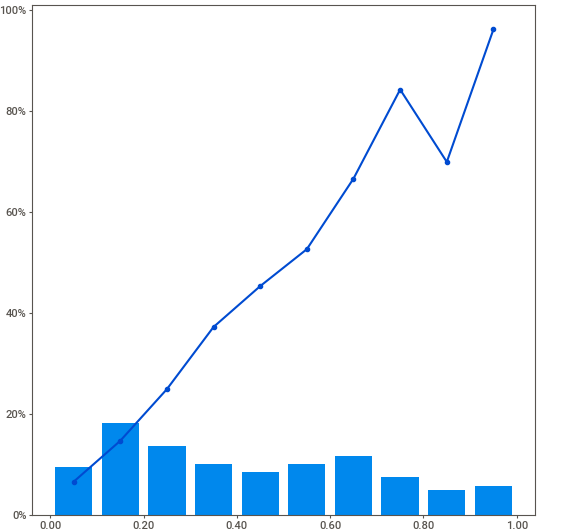
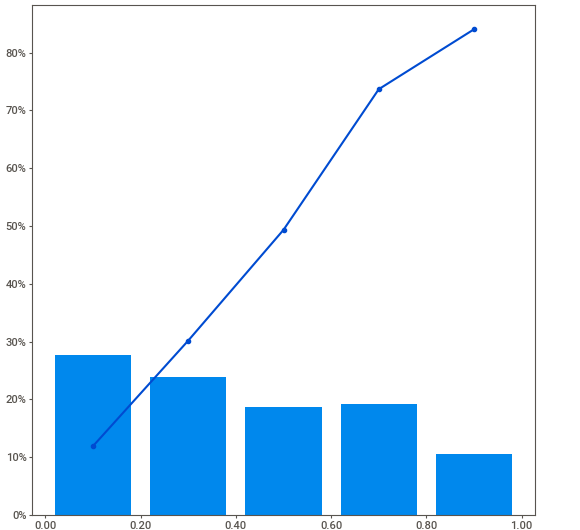
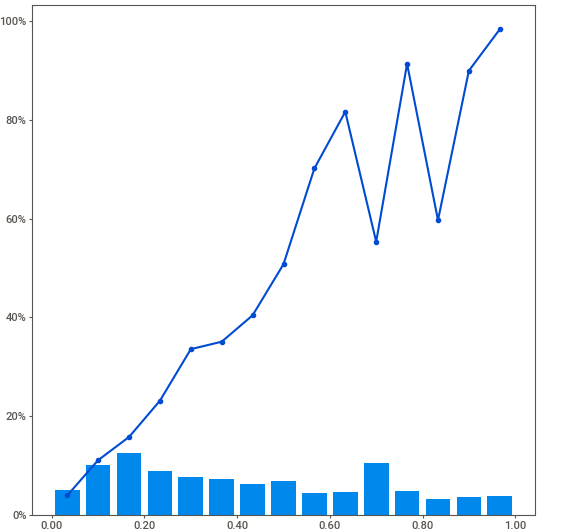
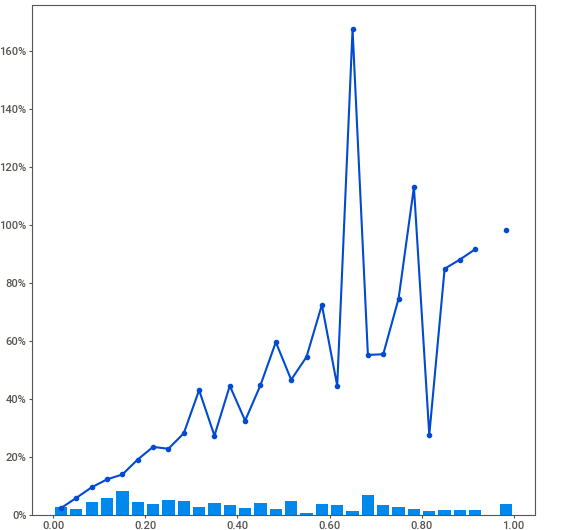
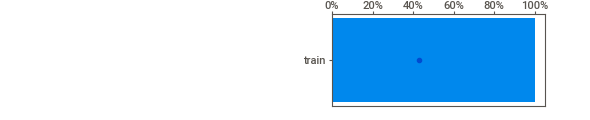
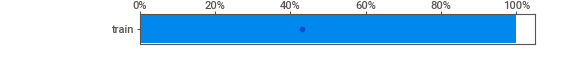
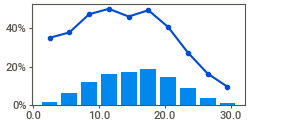
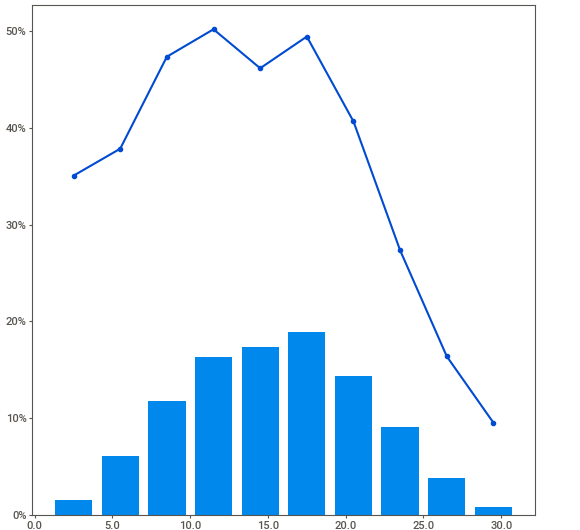
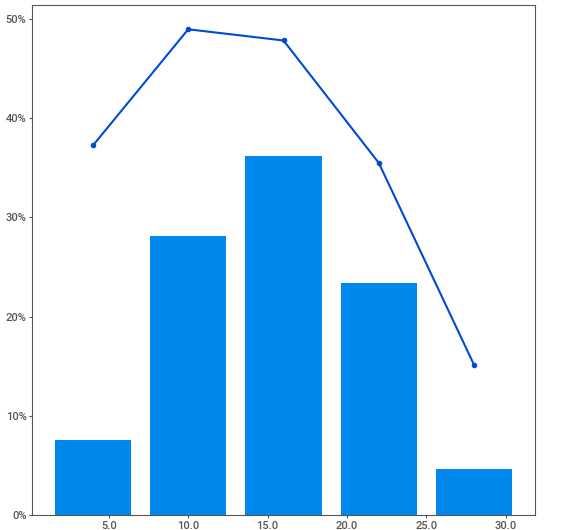
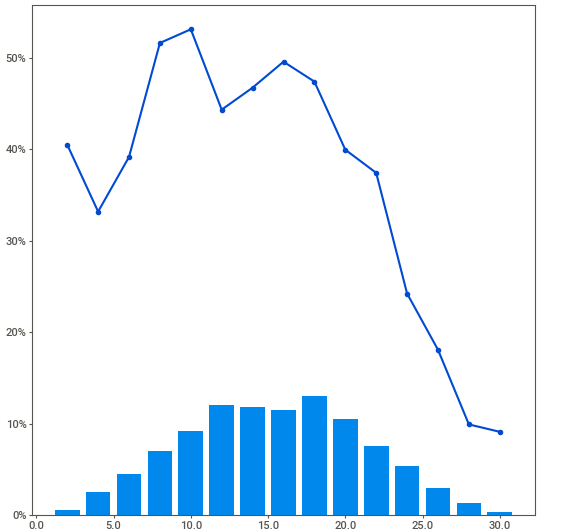
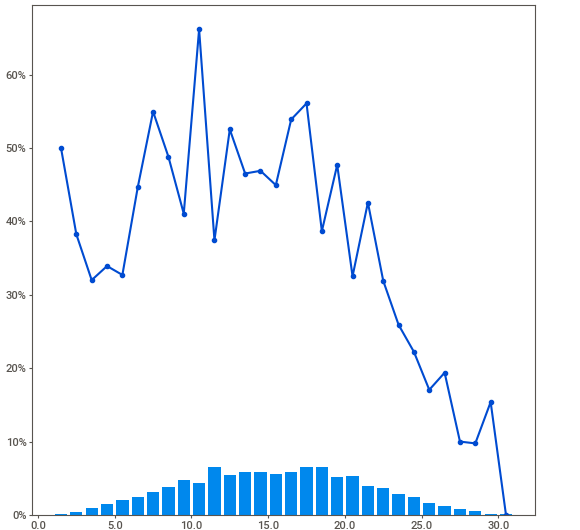
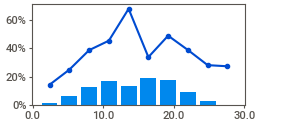
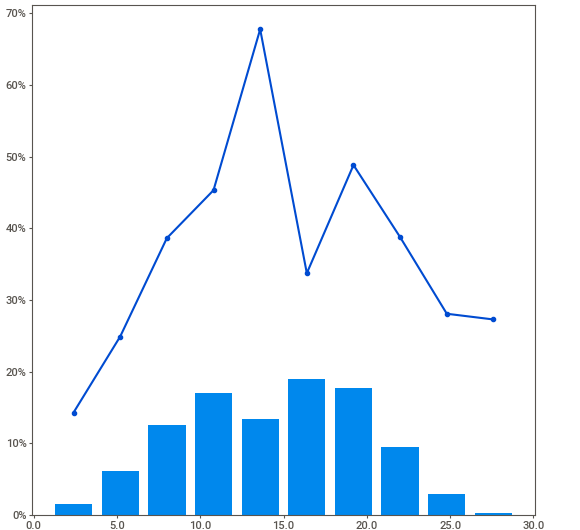
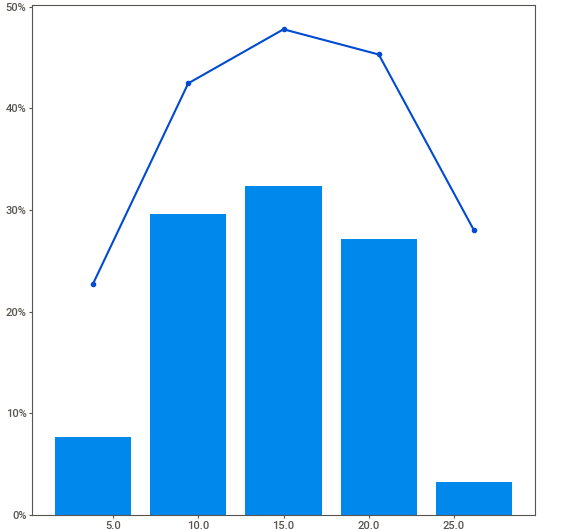
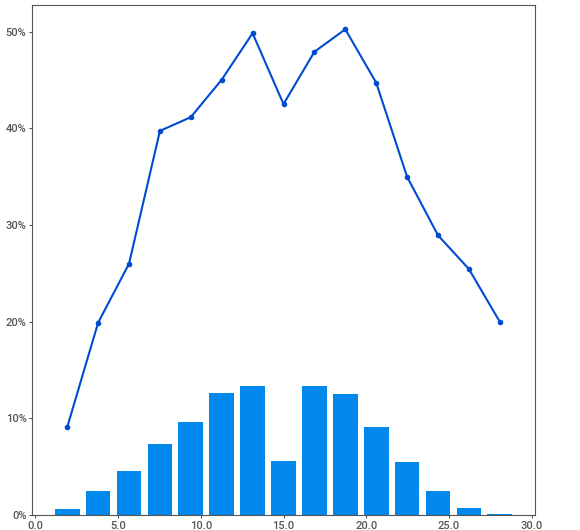
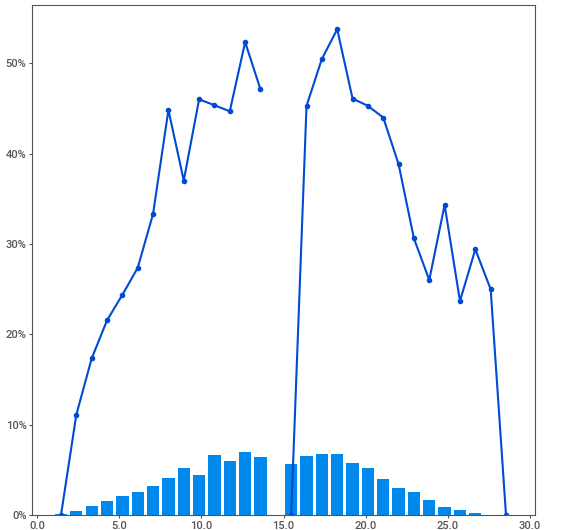
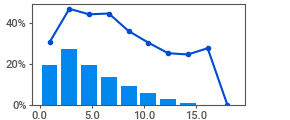
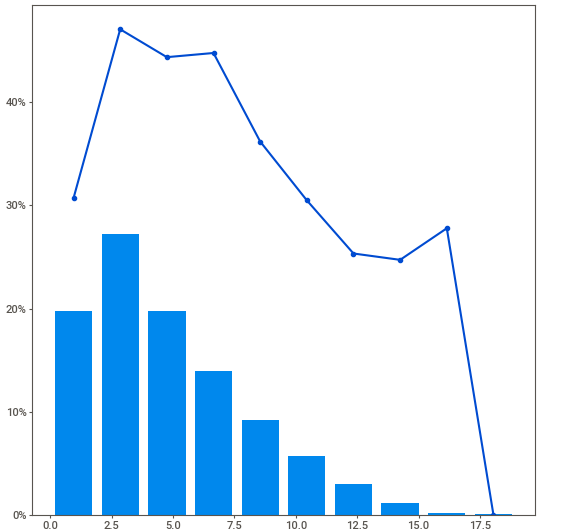
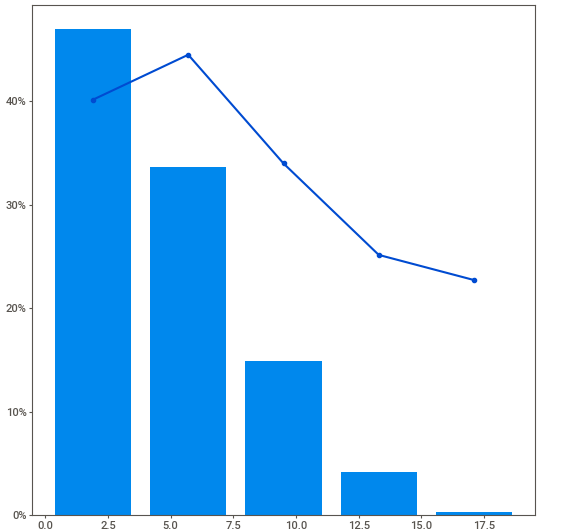
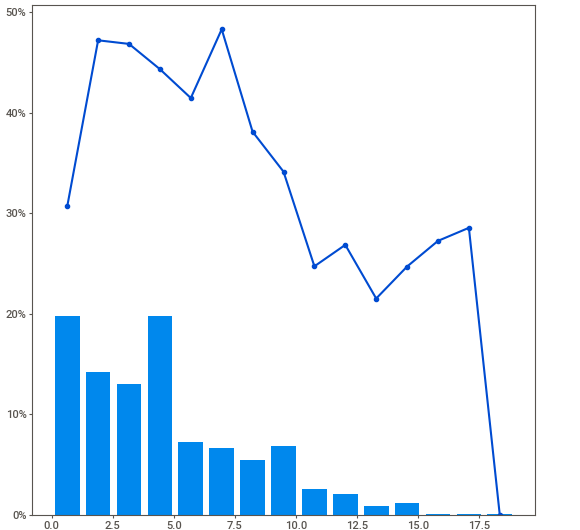
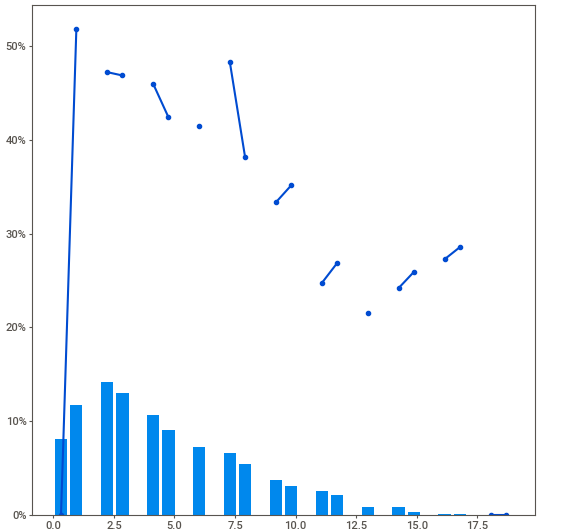
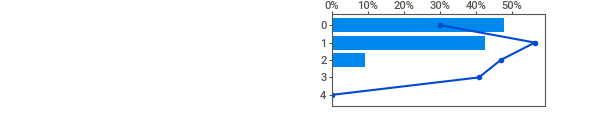
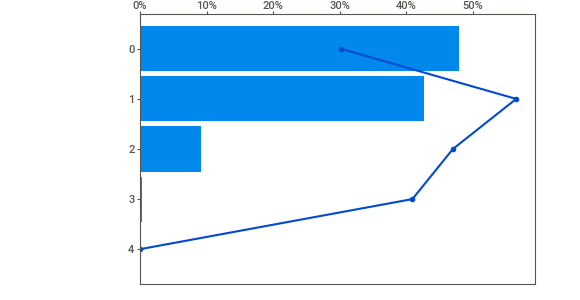
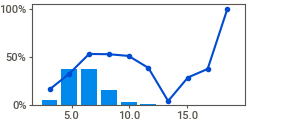
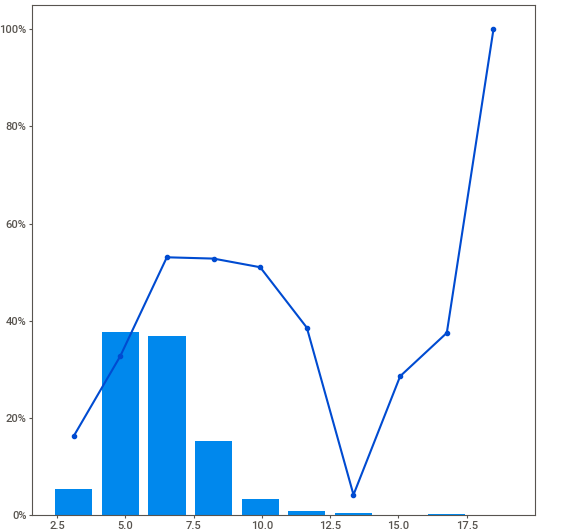
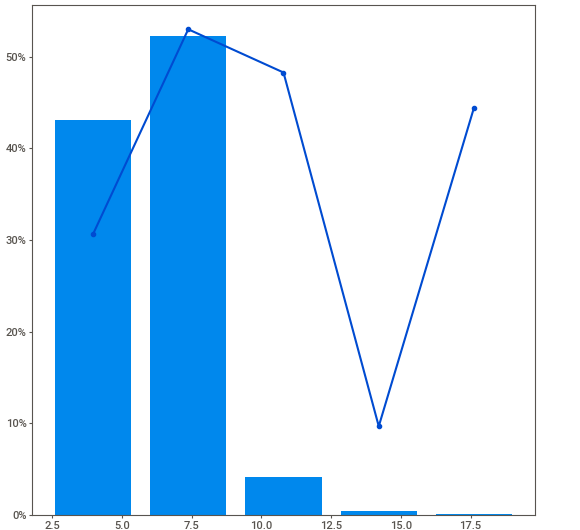
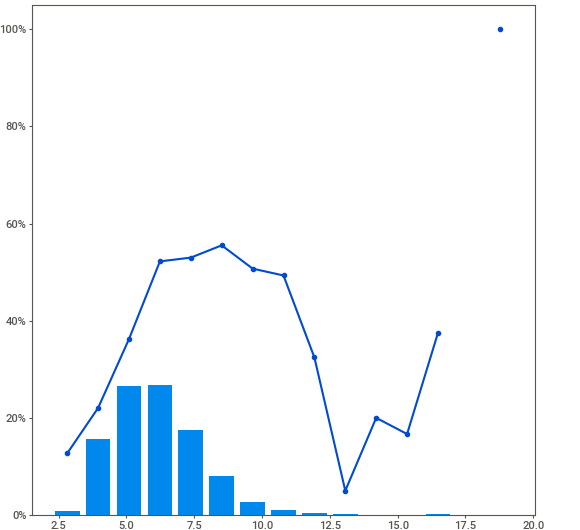
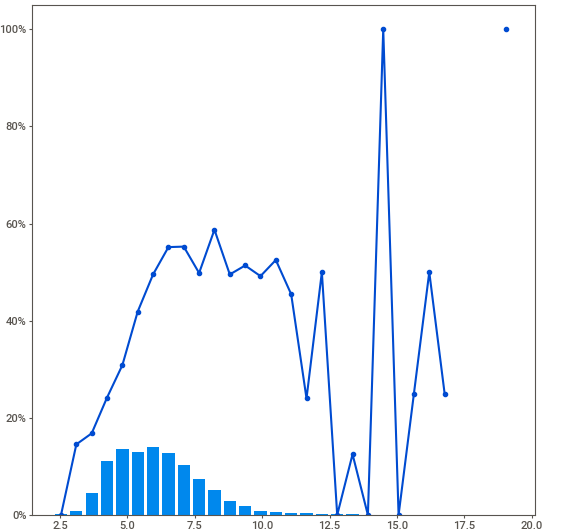
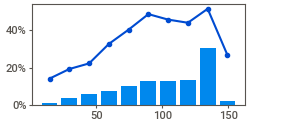
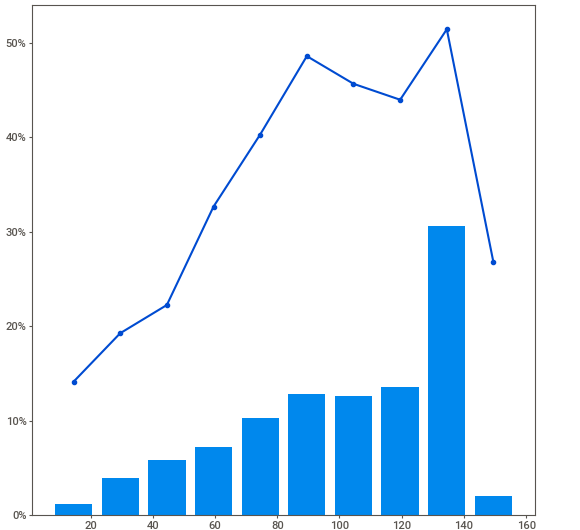
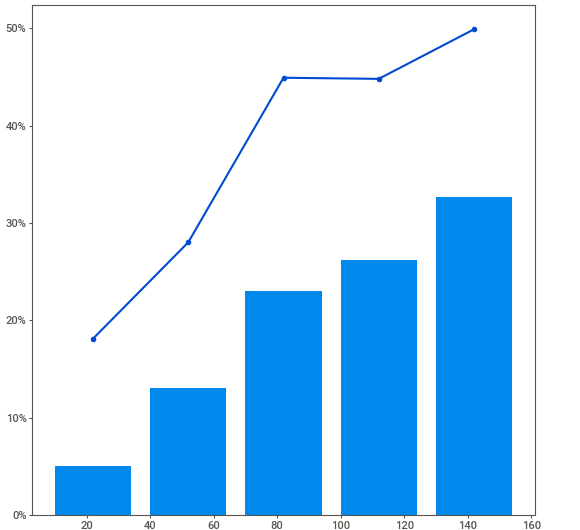
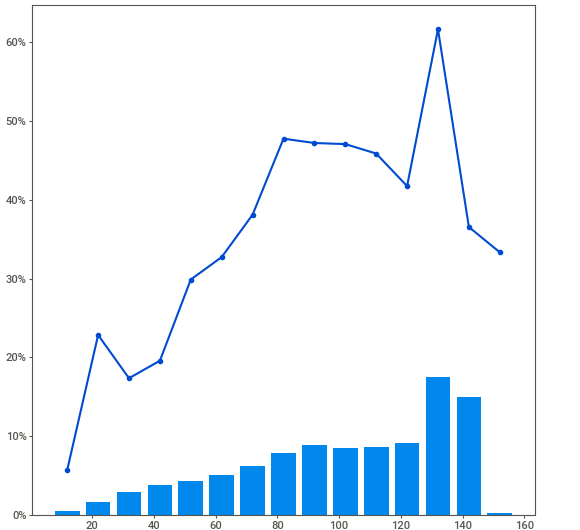
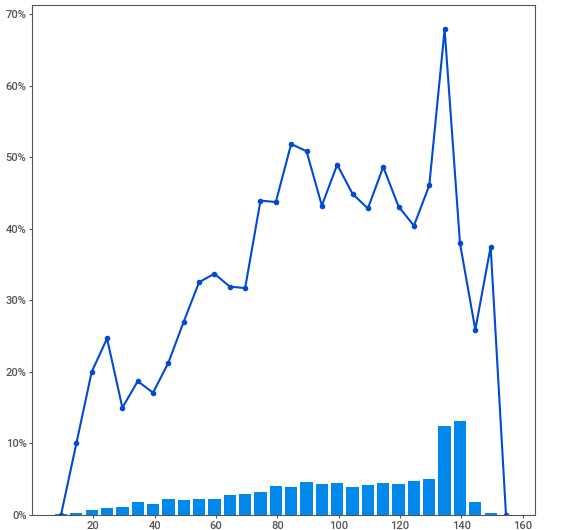
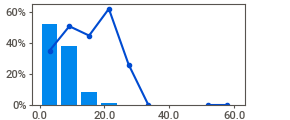
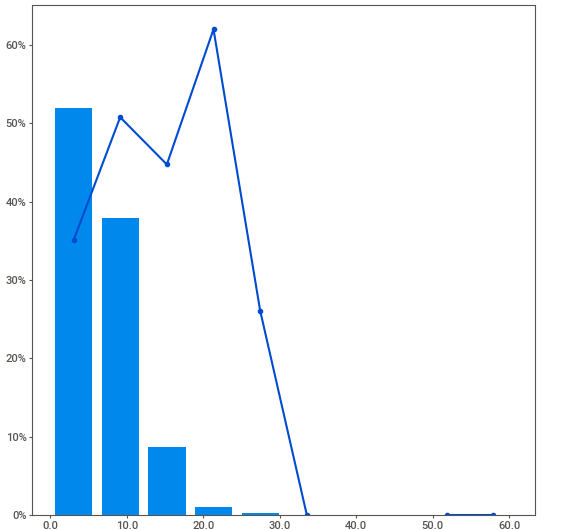
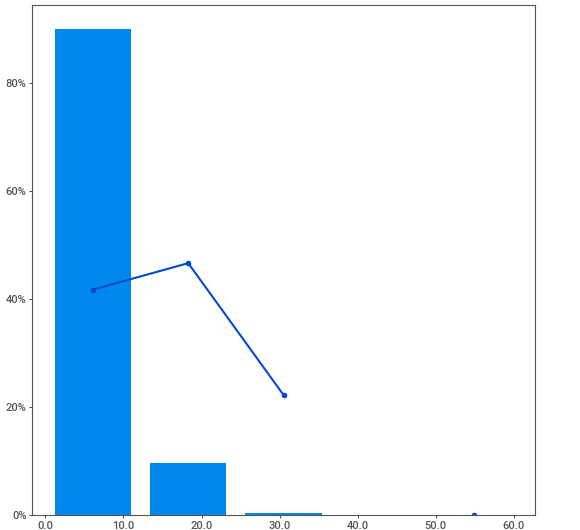
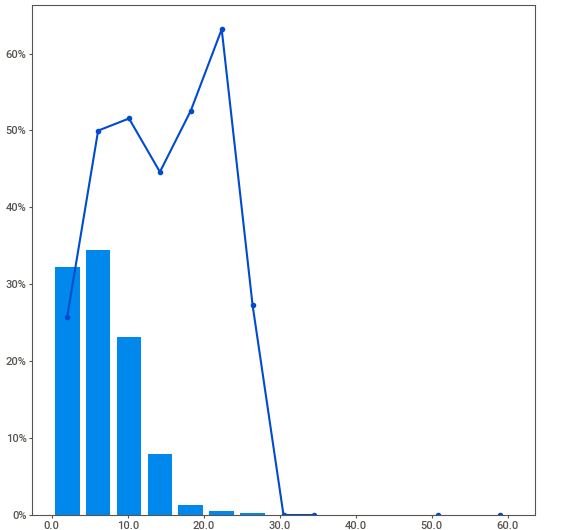
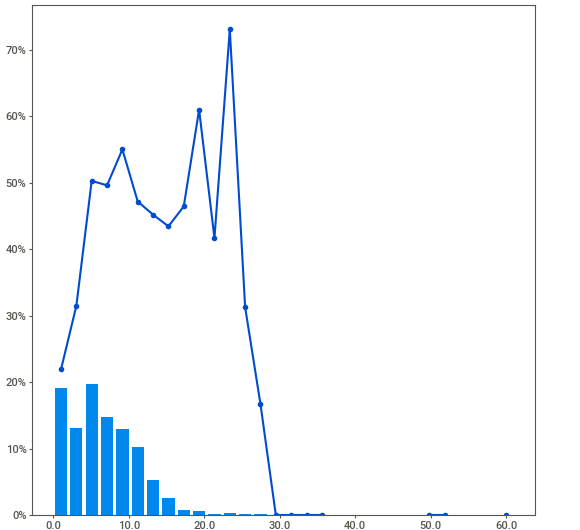
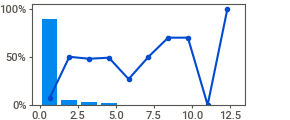
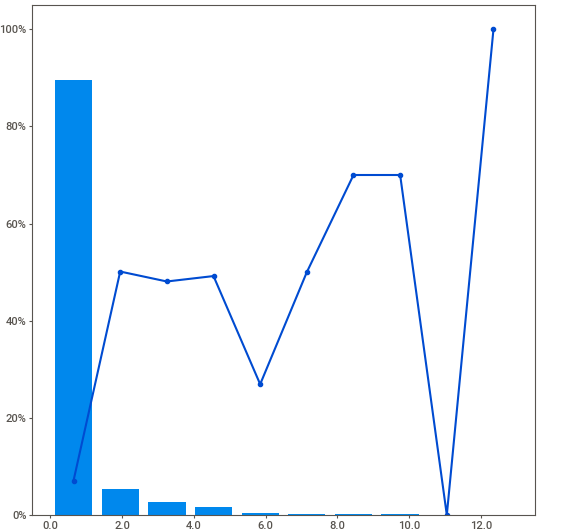
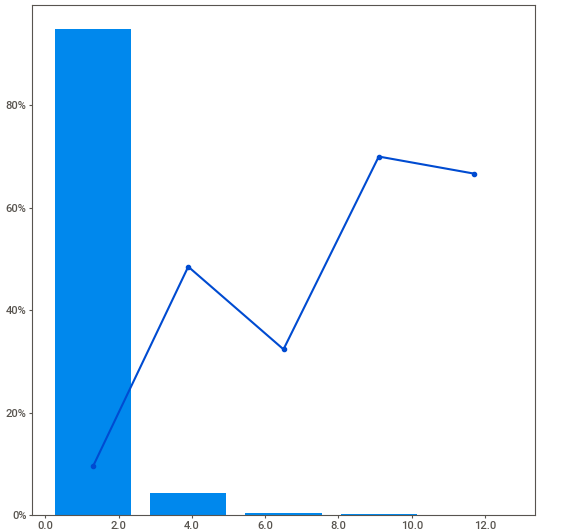
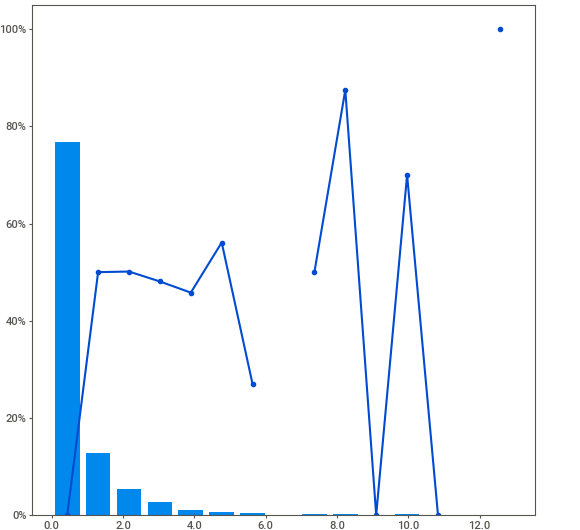
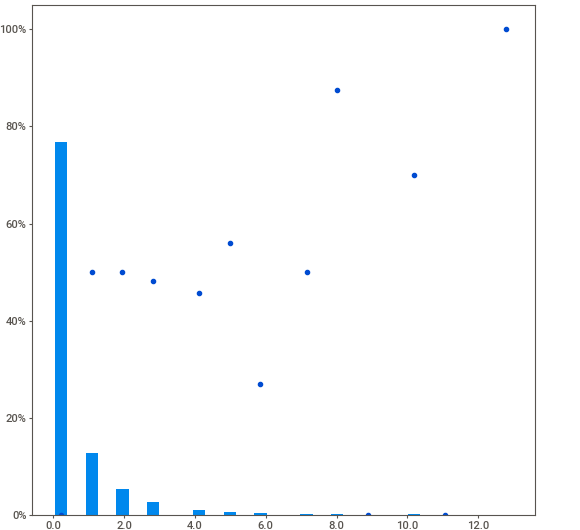
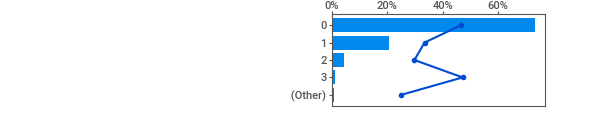
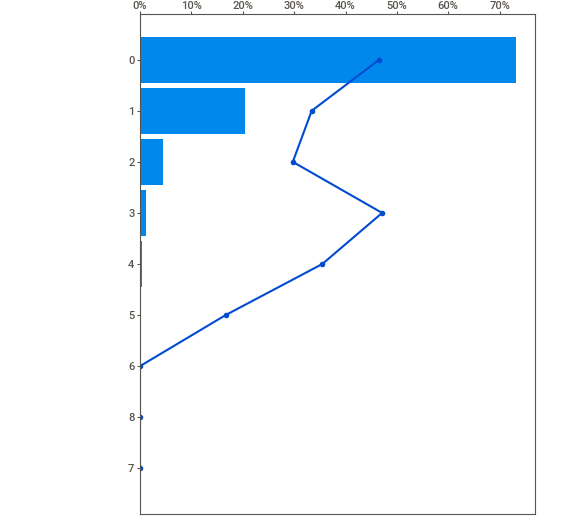
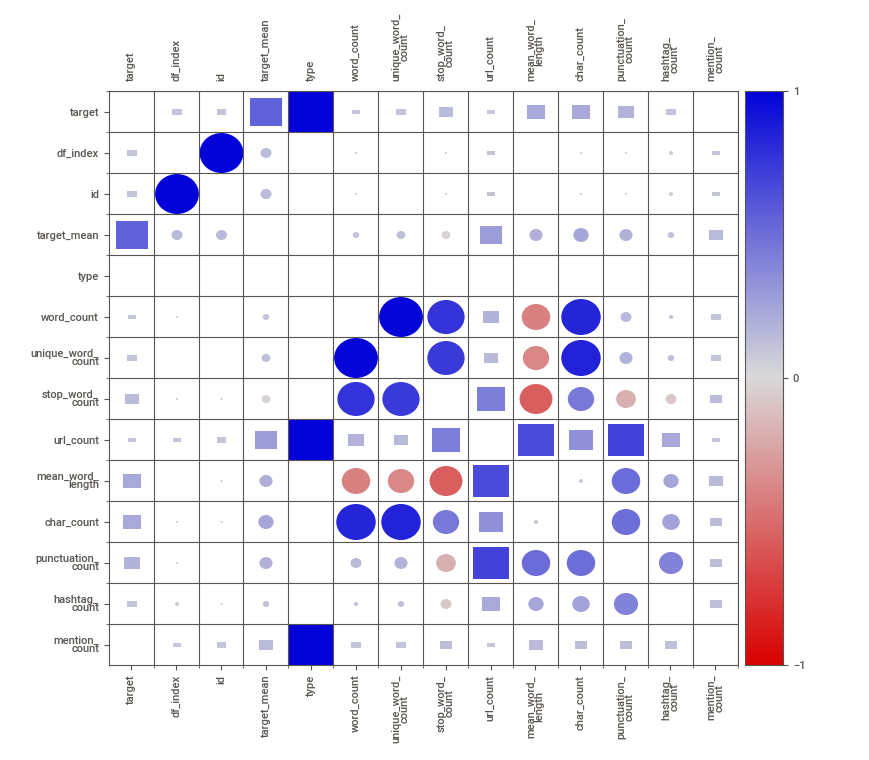
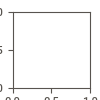

In [13]:
my_report.show_notebook()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



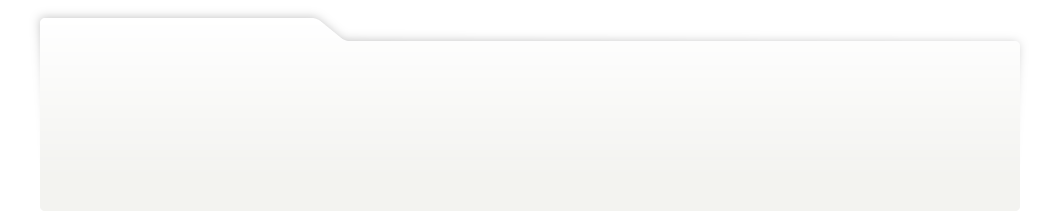
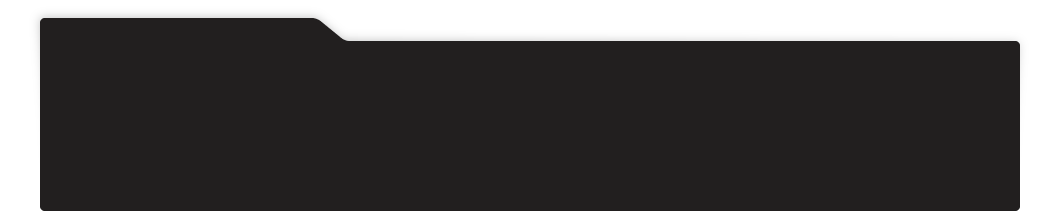
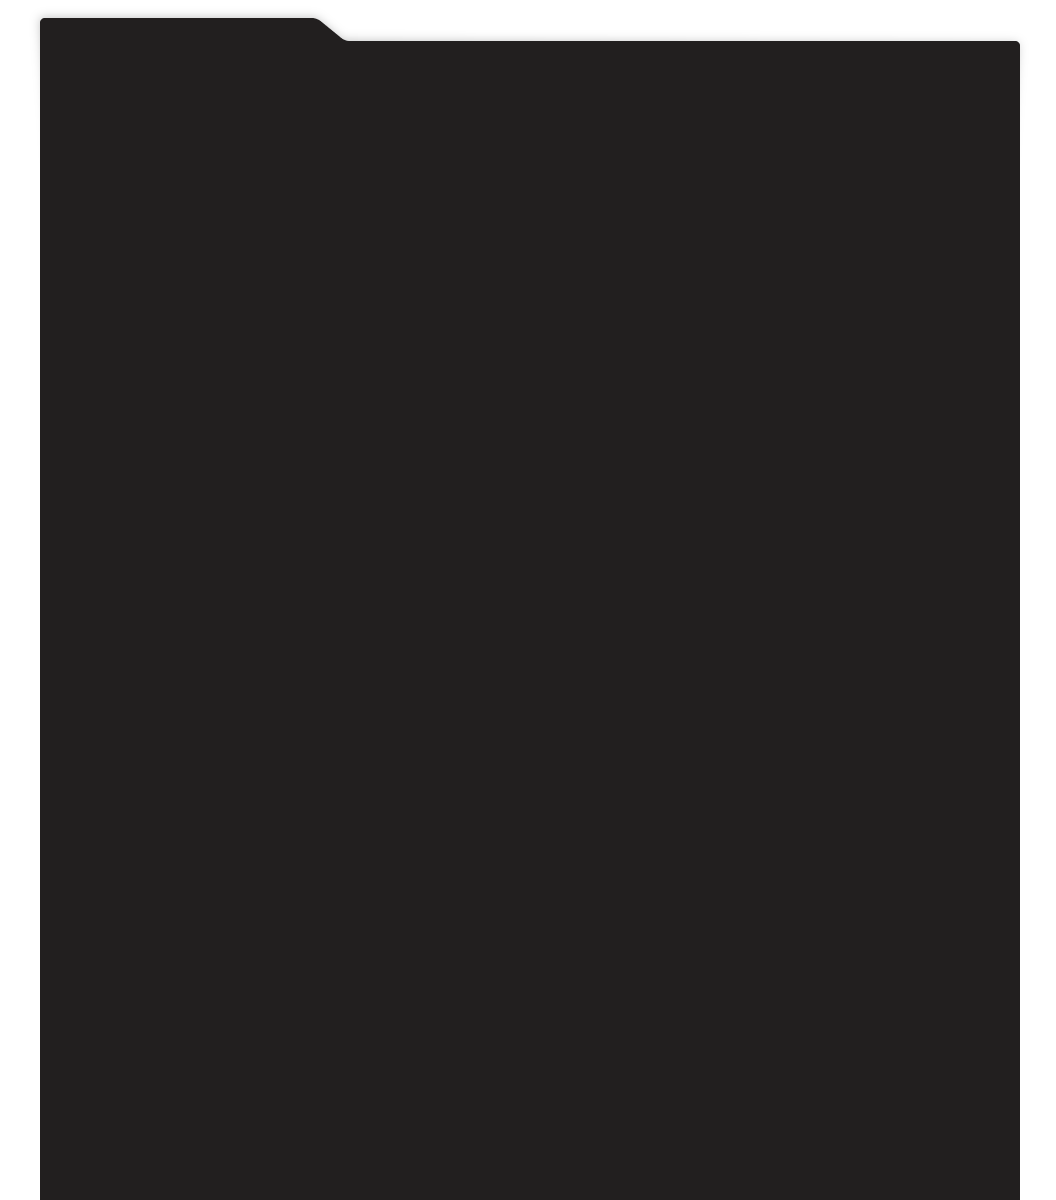
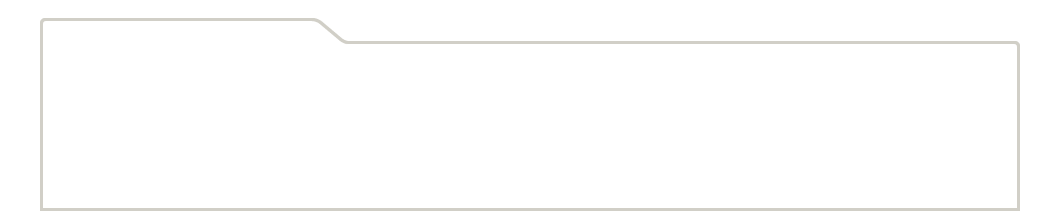
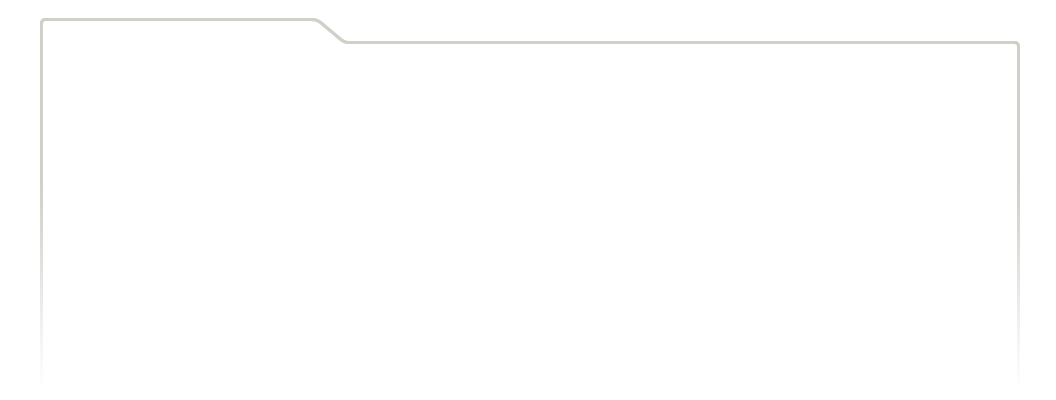
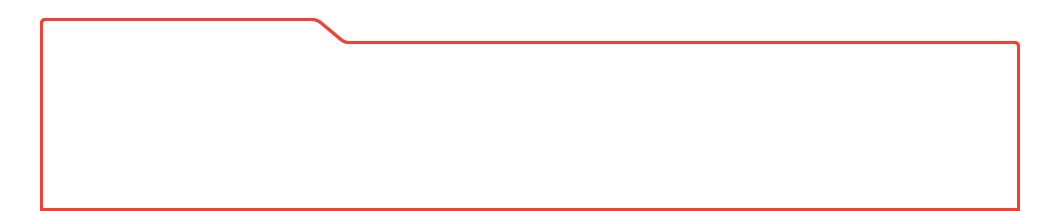
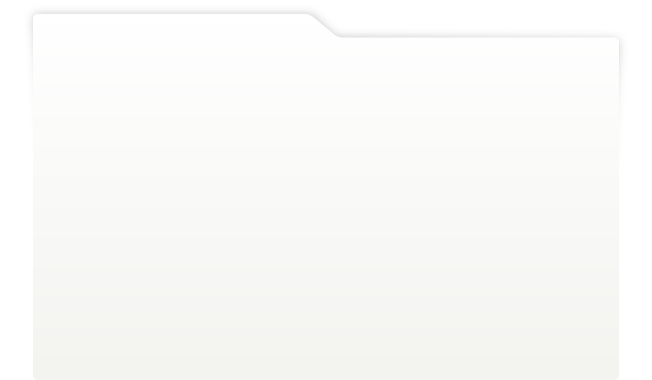
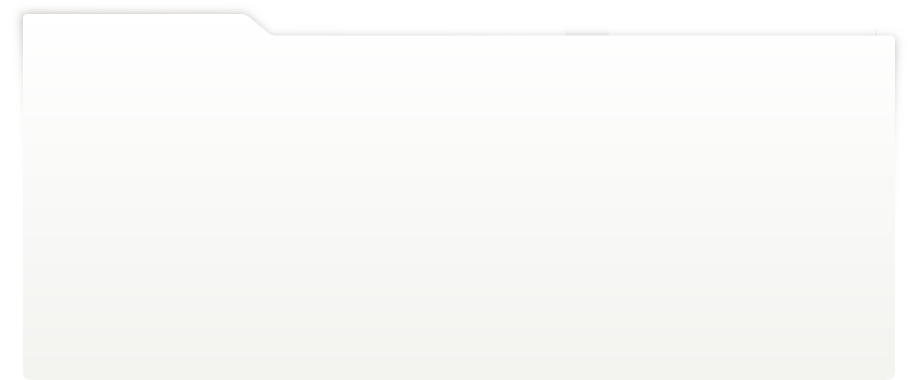
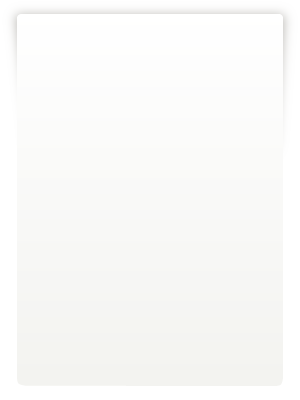
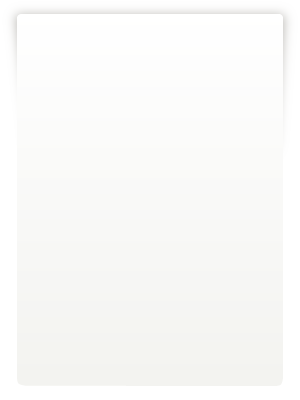
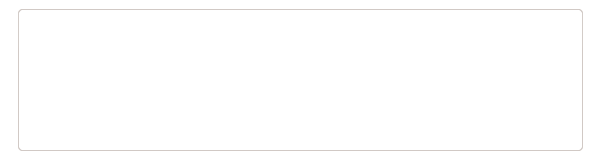
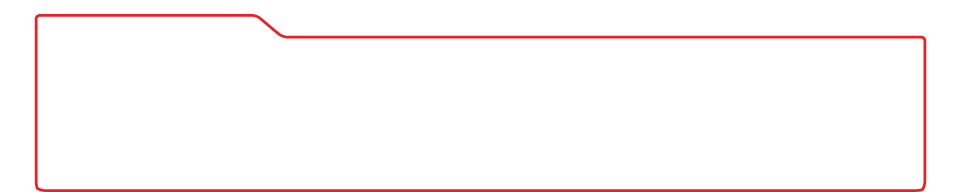
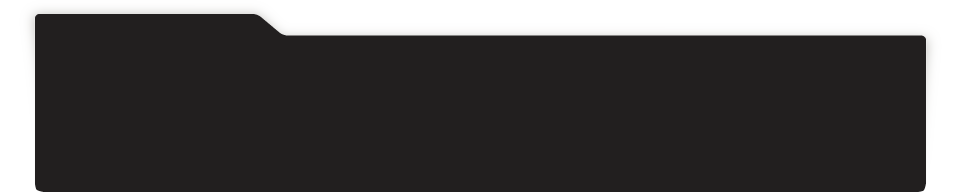
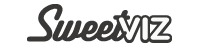
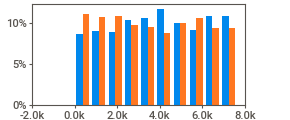
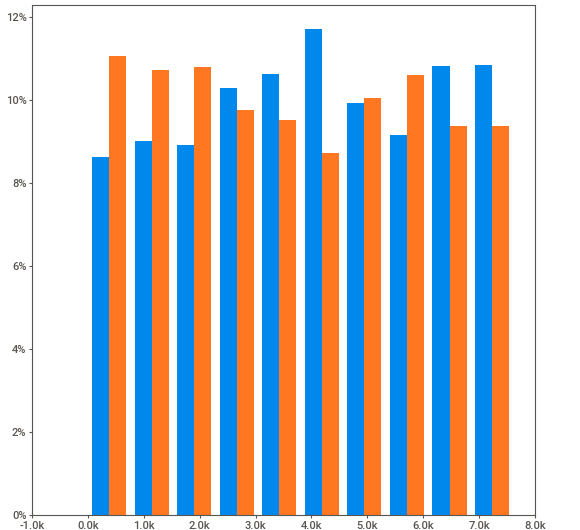
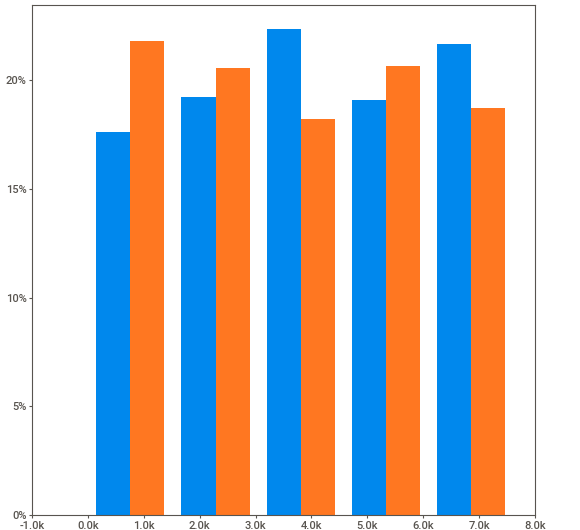
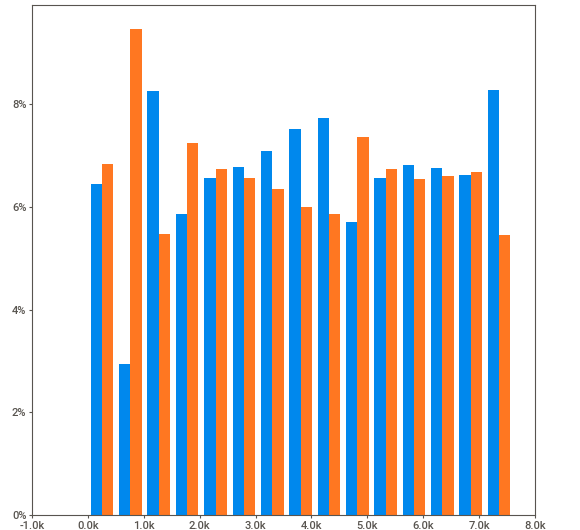
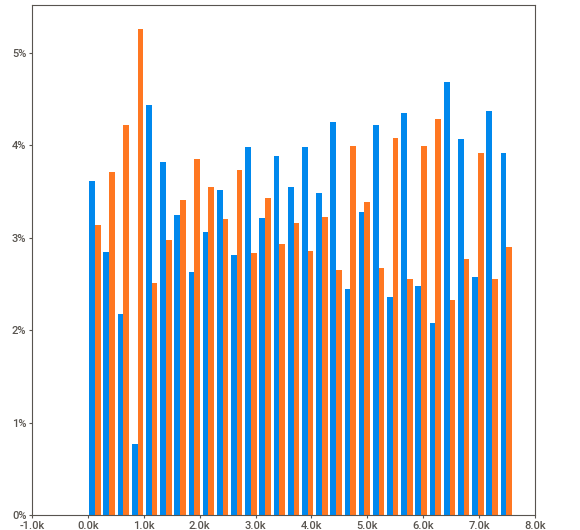
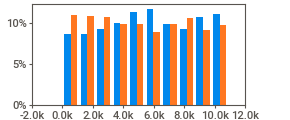
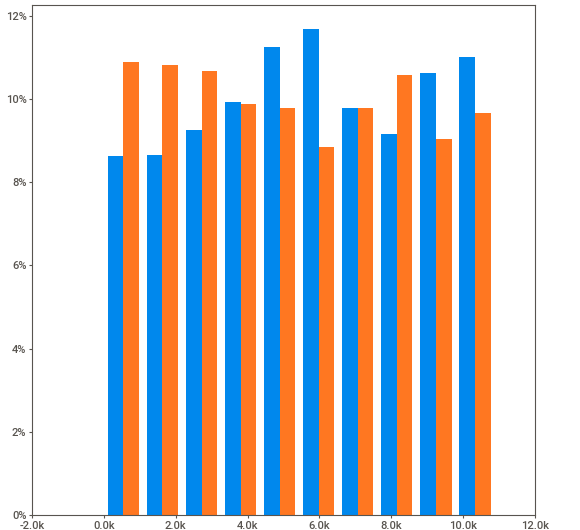
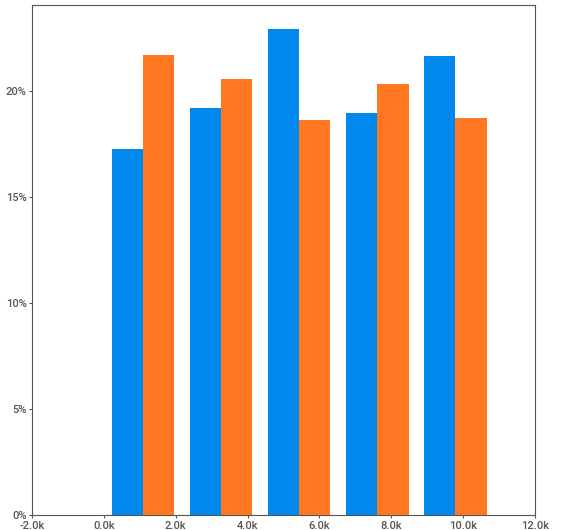
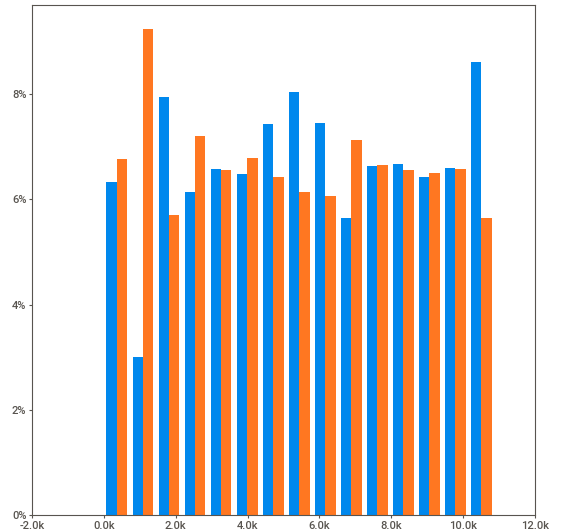
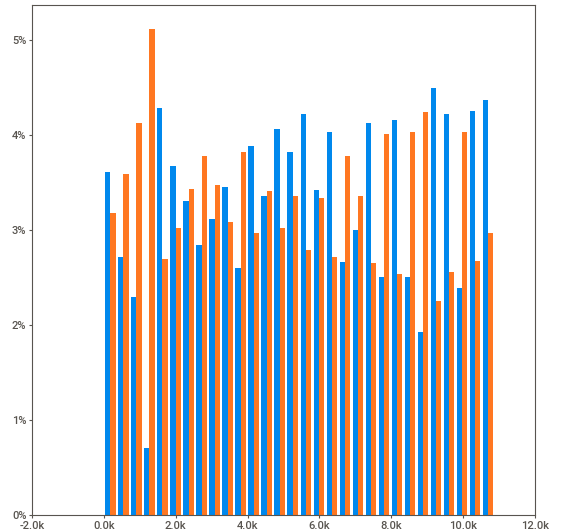
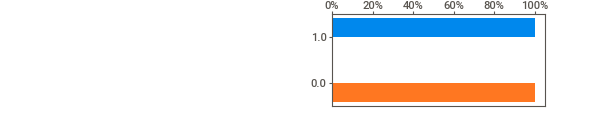
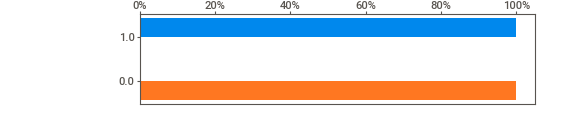
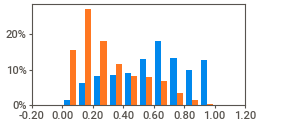
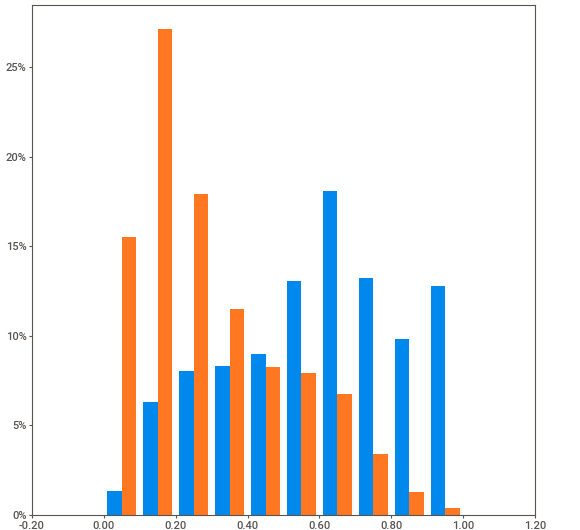
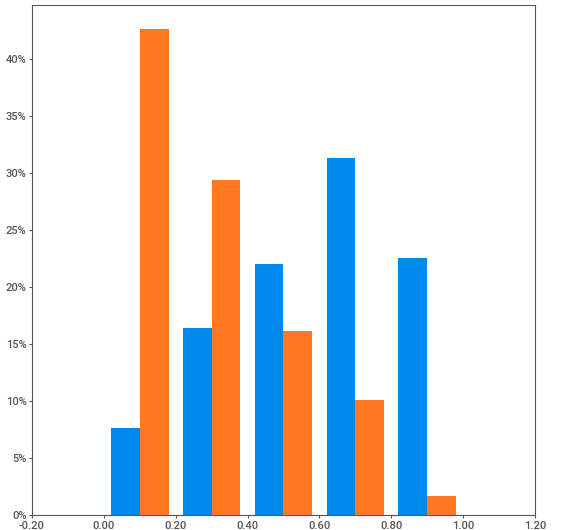
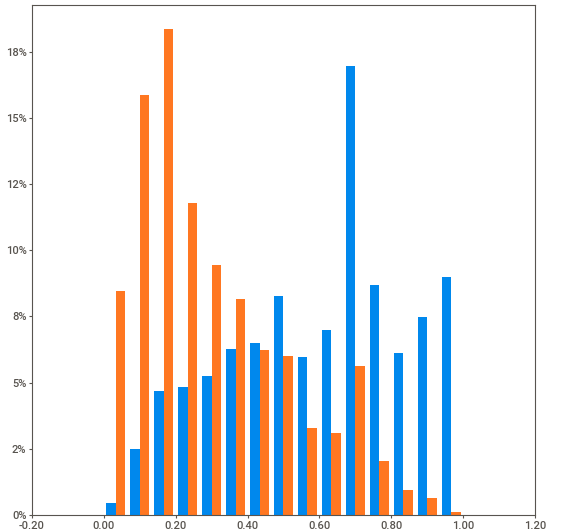
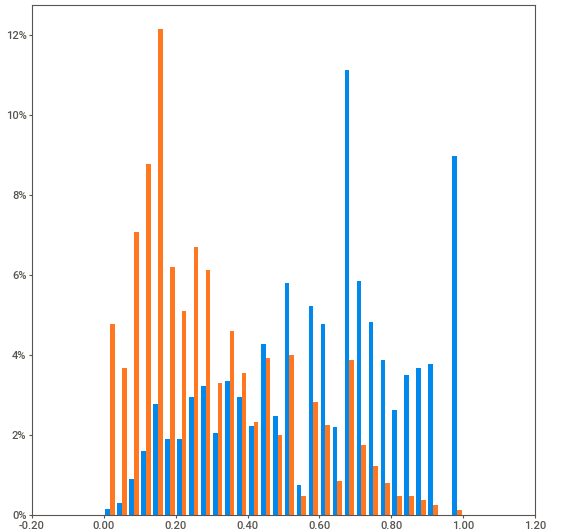
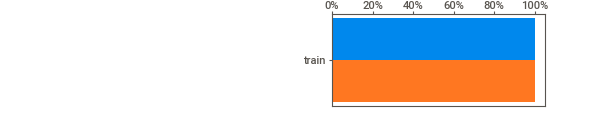
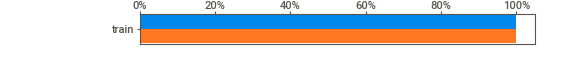
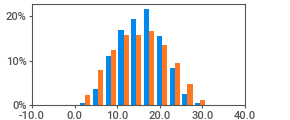
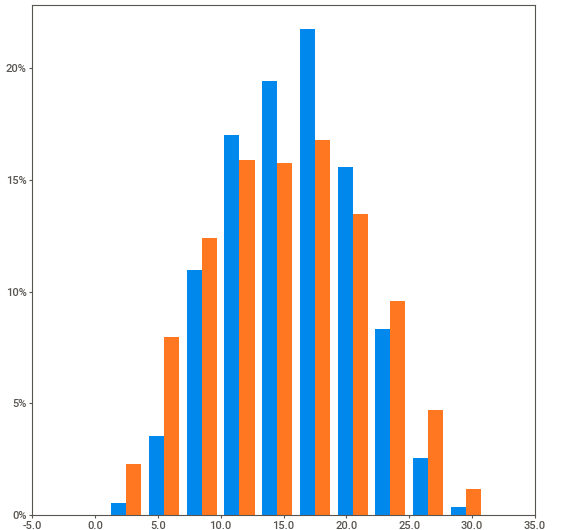
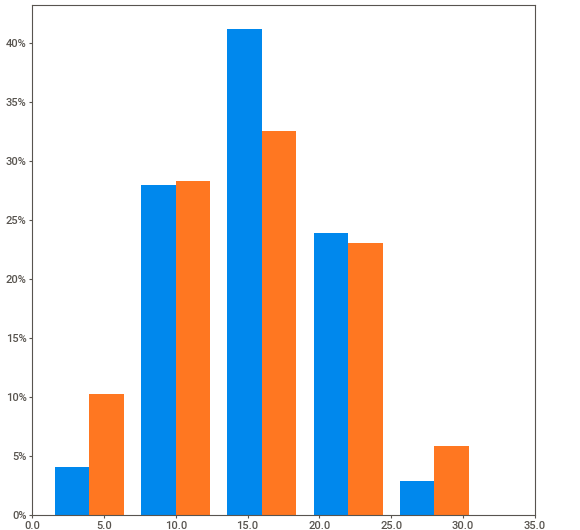
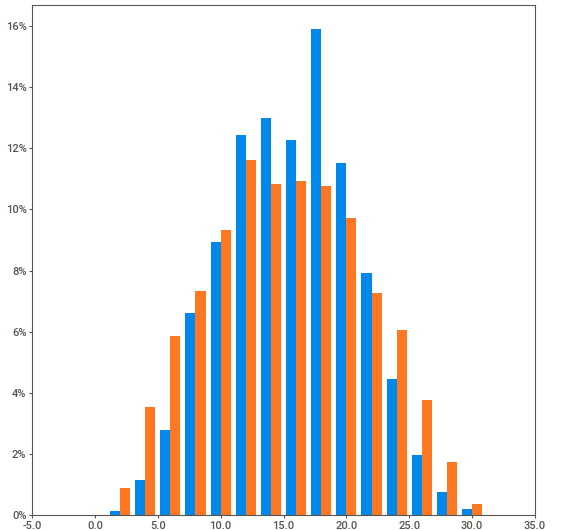
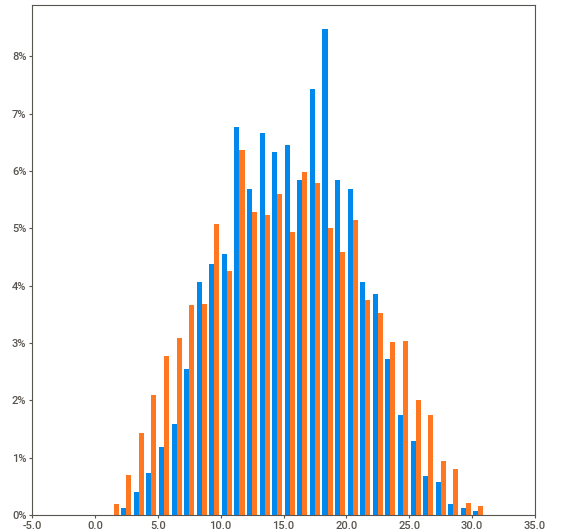
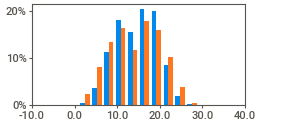
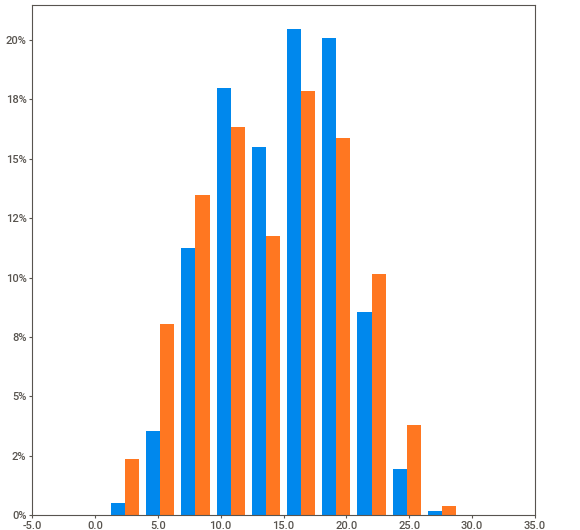
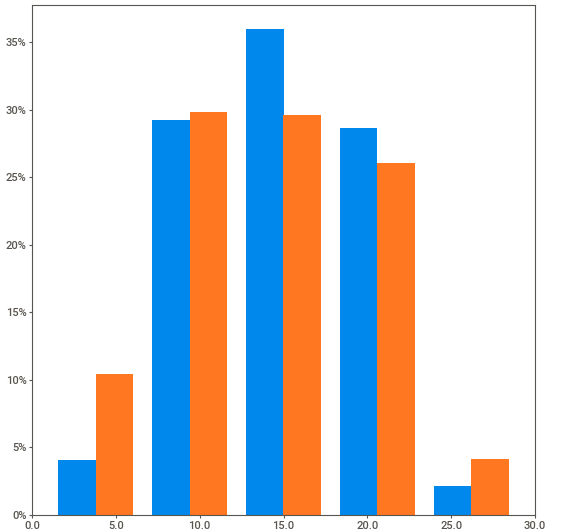
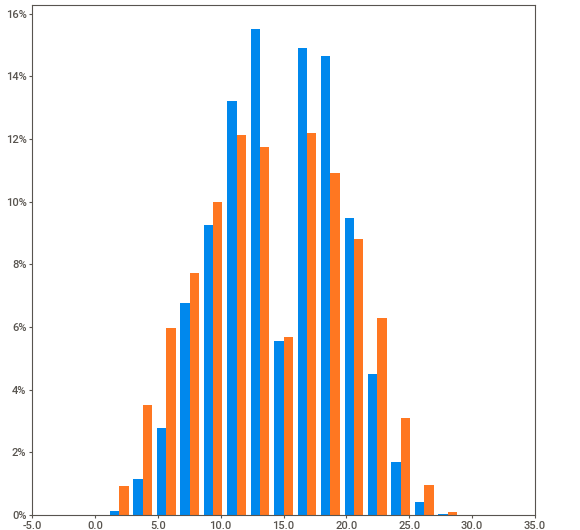
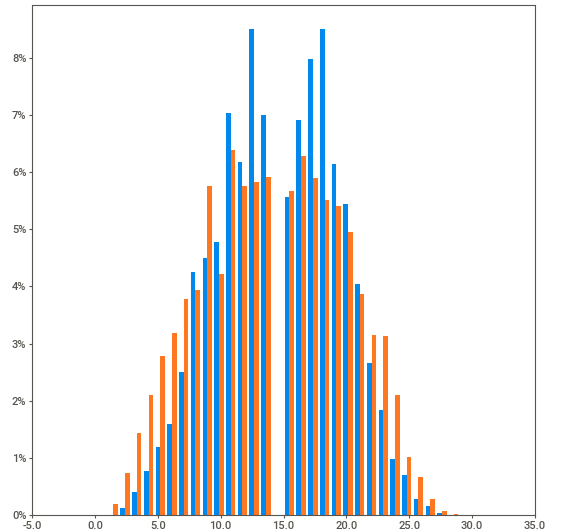
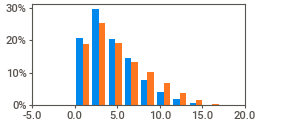
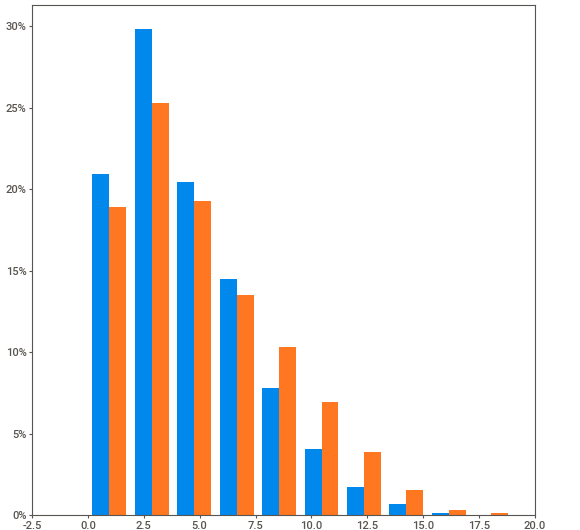
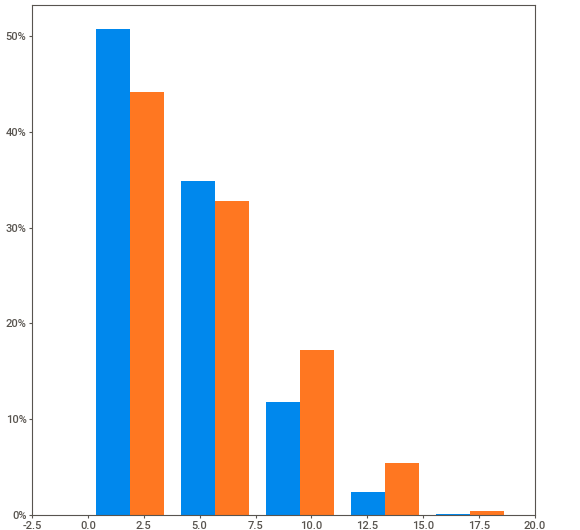
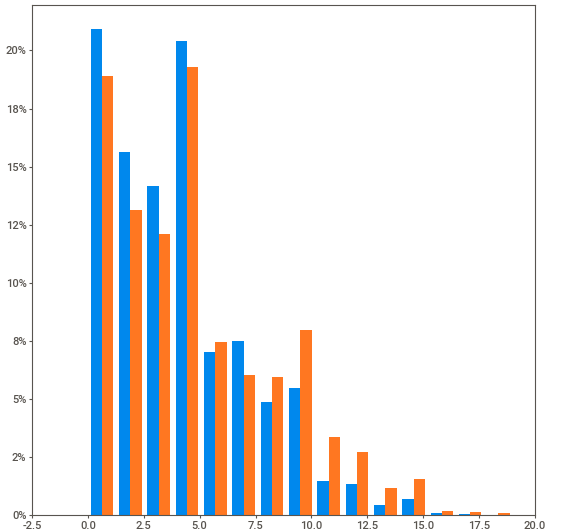
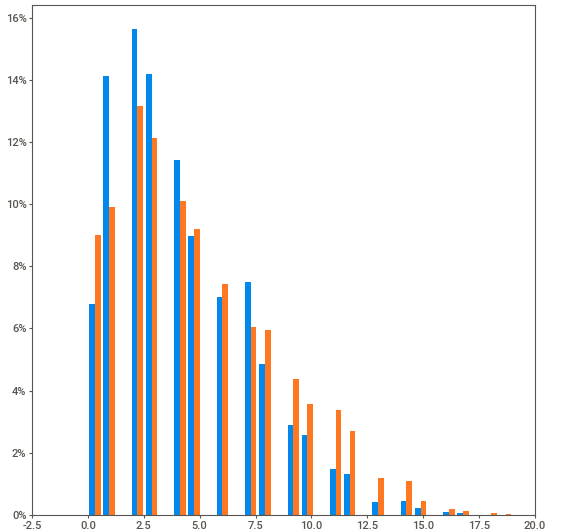
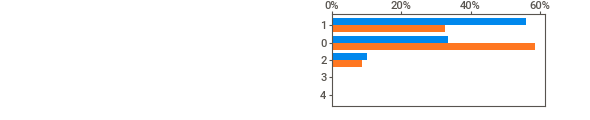
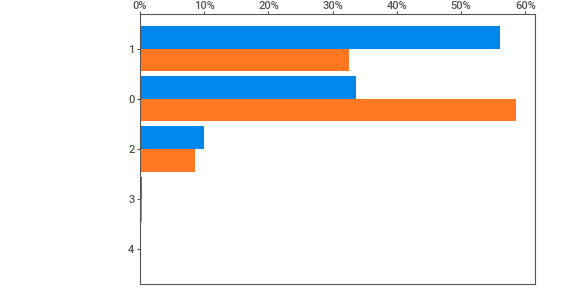
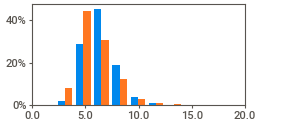
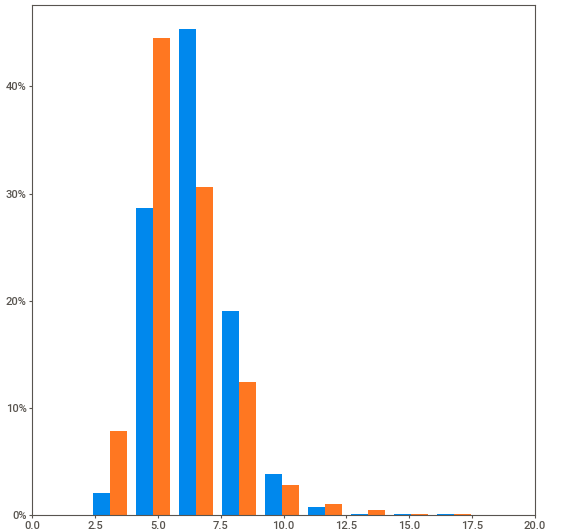
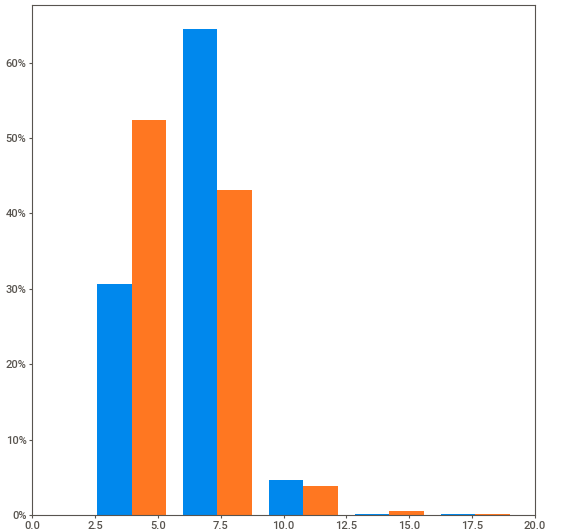
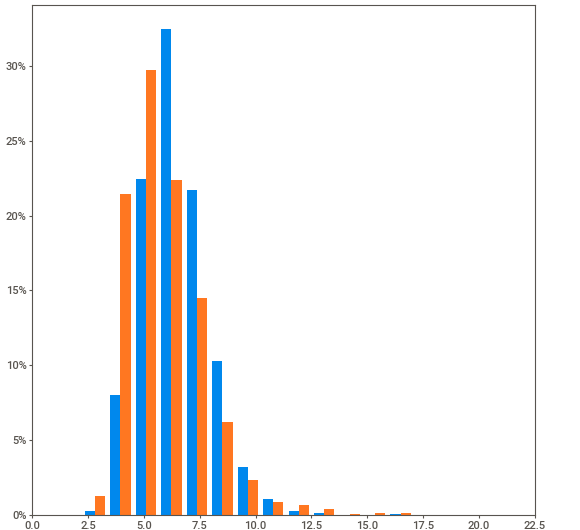
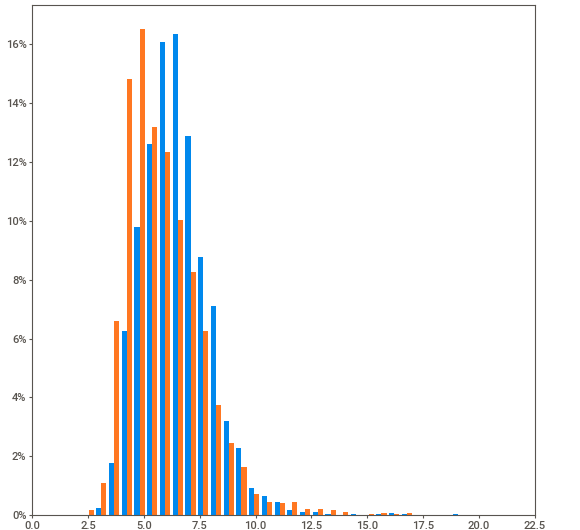
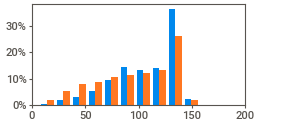
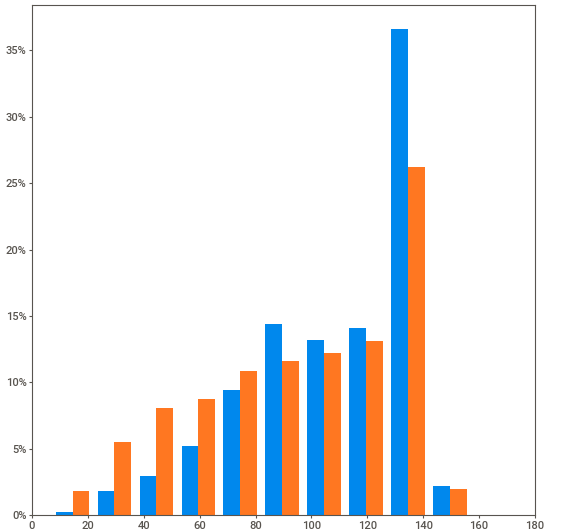
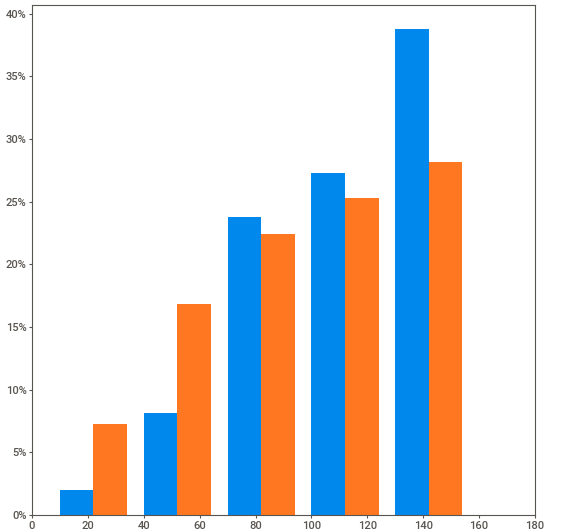
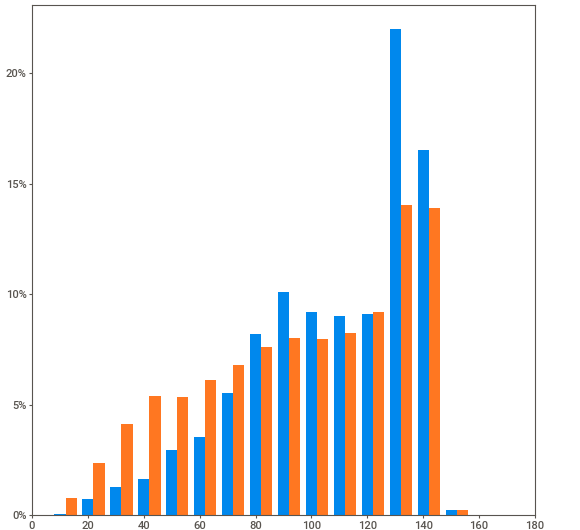
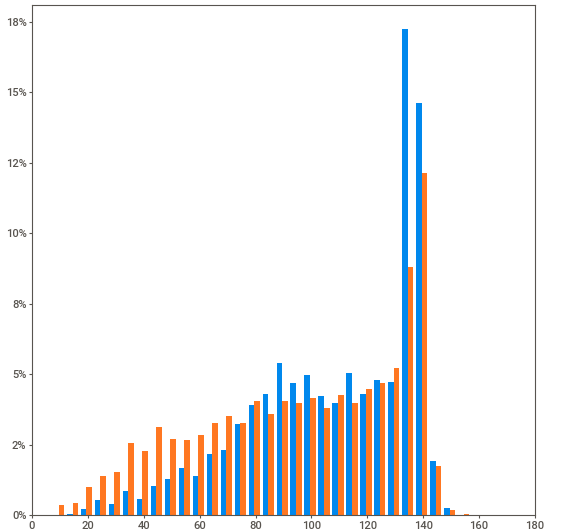
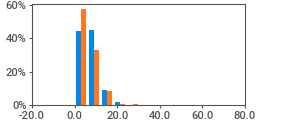
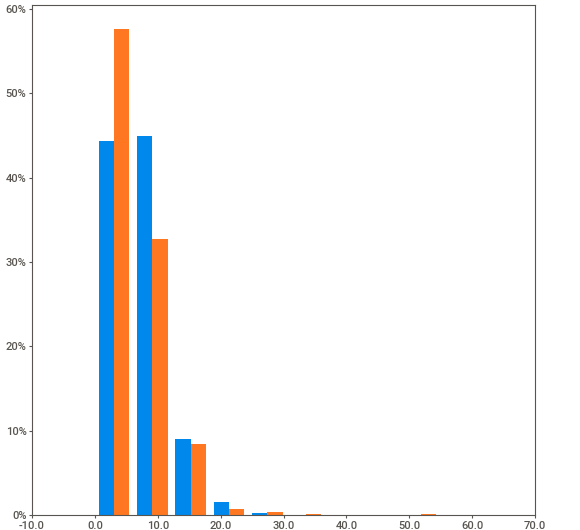
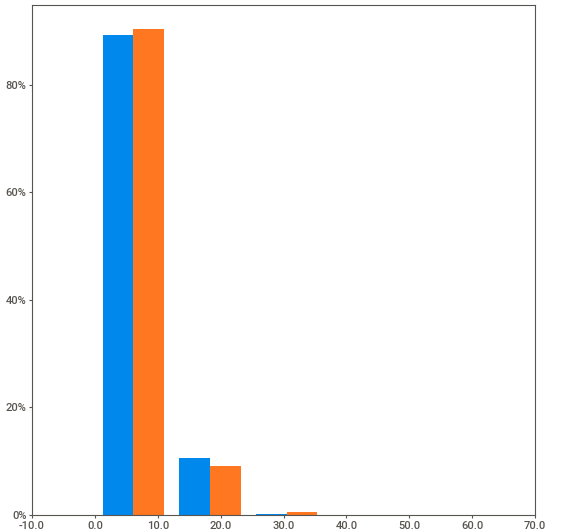
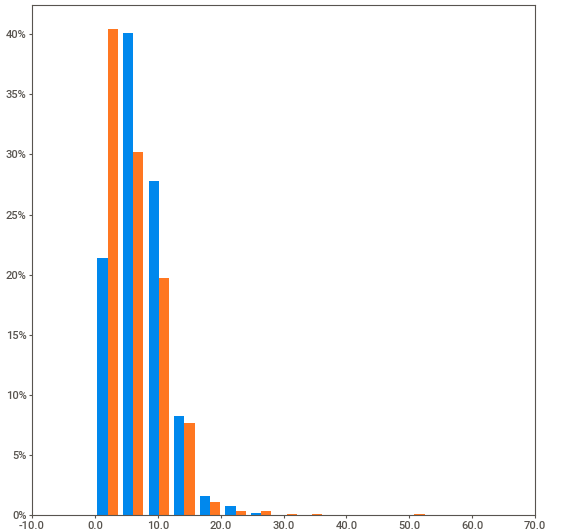
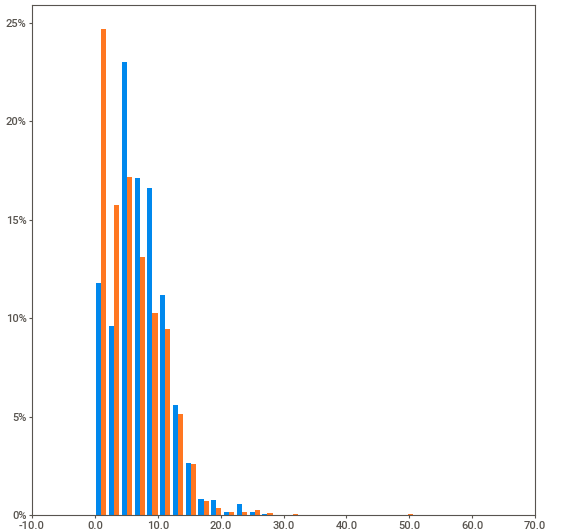
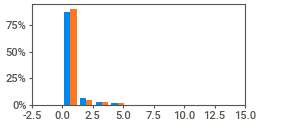
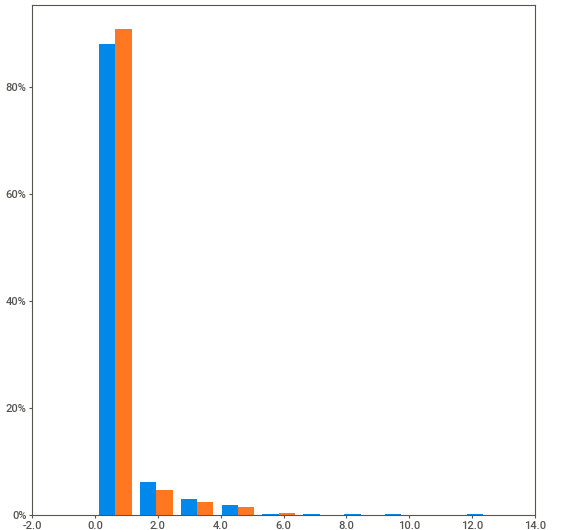
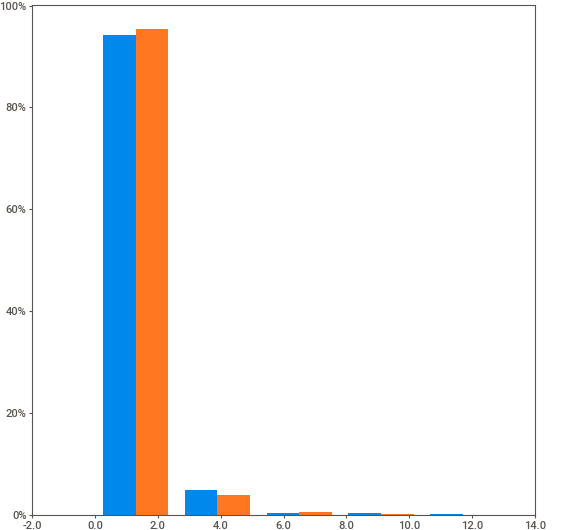
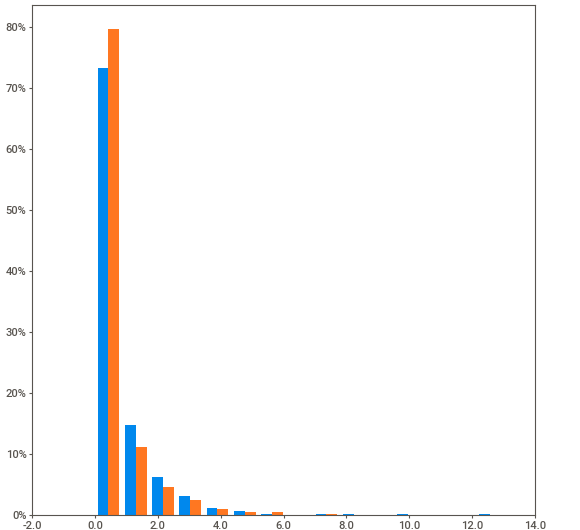
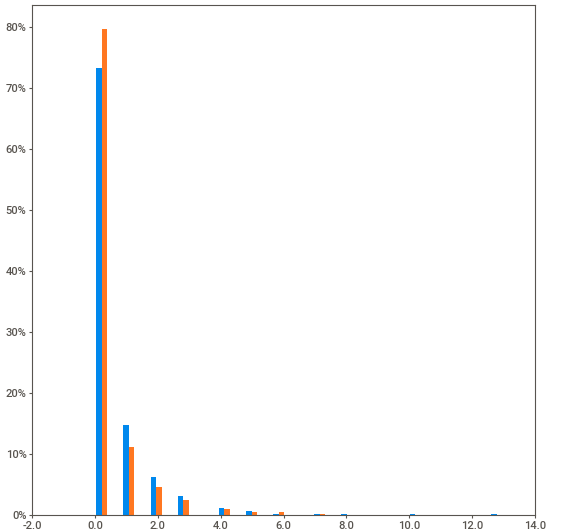
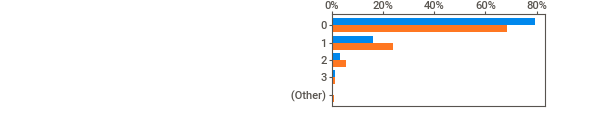
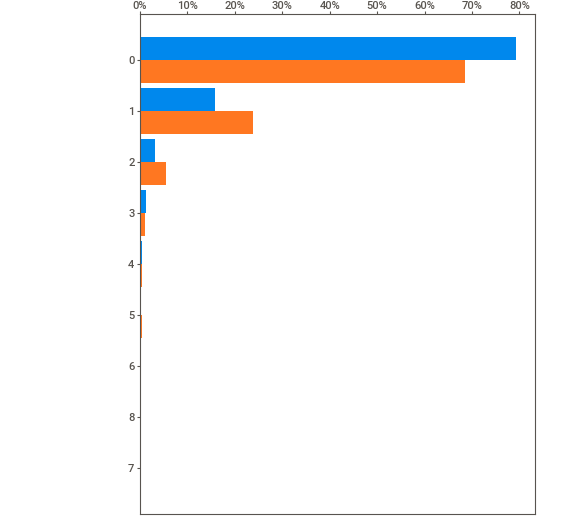
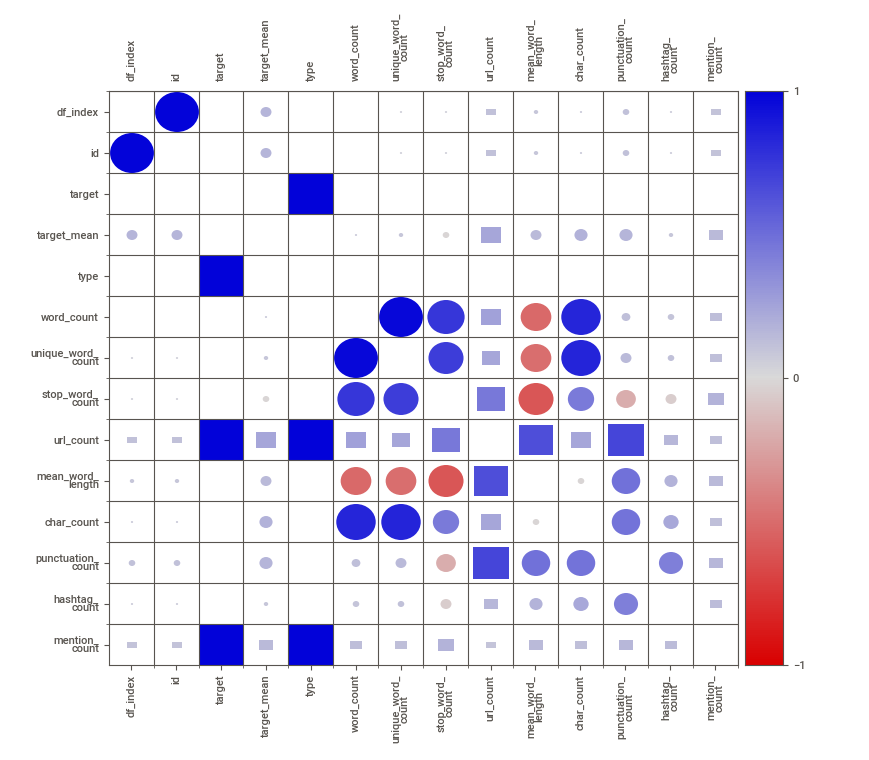
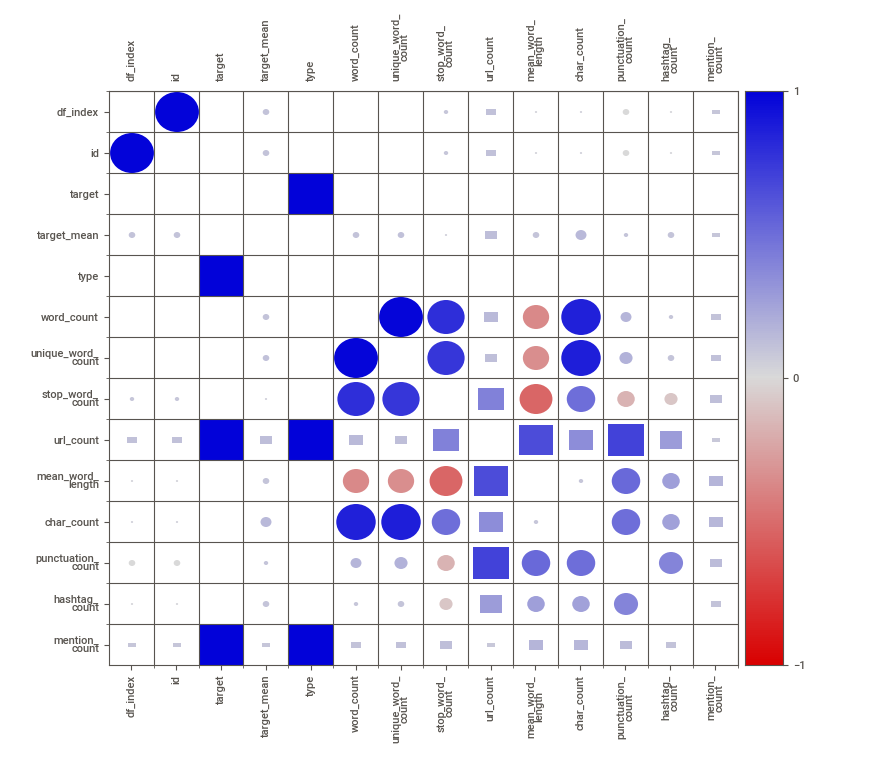

In [14]:
# 针对target进行比较。
my_report = sv.compare_intra(df_all.loc[TRAIN_TWEETS], df_all[TRAIN_TWEETS]["target"] == 1, ["Disaster", "No Disaster"])
my_report.show_notebook()

# 3.Target and N-Grams

In [15]:
from collections import defaultdict

# 可以使用nltk来实现ngrams.
def generate_ngrams(text, n_gram=1):
    # 生成n-grams
    # 获取所有的token
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    # 将所有的token每n_gram个组合成list，
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    result = [' '.join(ngram) for ngram in ngrams]
    # 就组合成了n_grams
    return result

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

# 获取Disaster的n_gram
for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
# 获取No Disaster的n_gram
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1]) # 倒序排列。其实可以添加一个负号
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: -x[1]))

W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


查看unigram的词频和顺序。

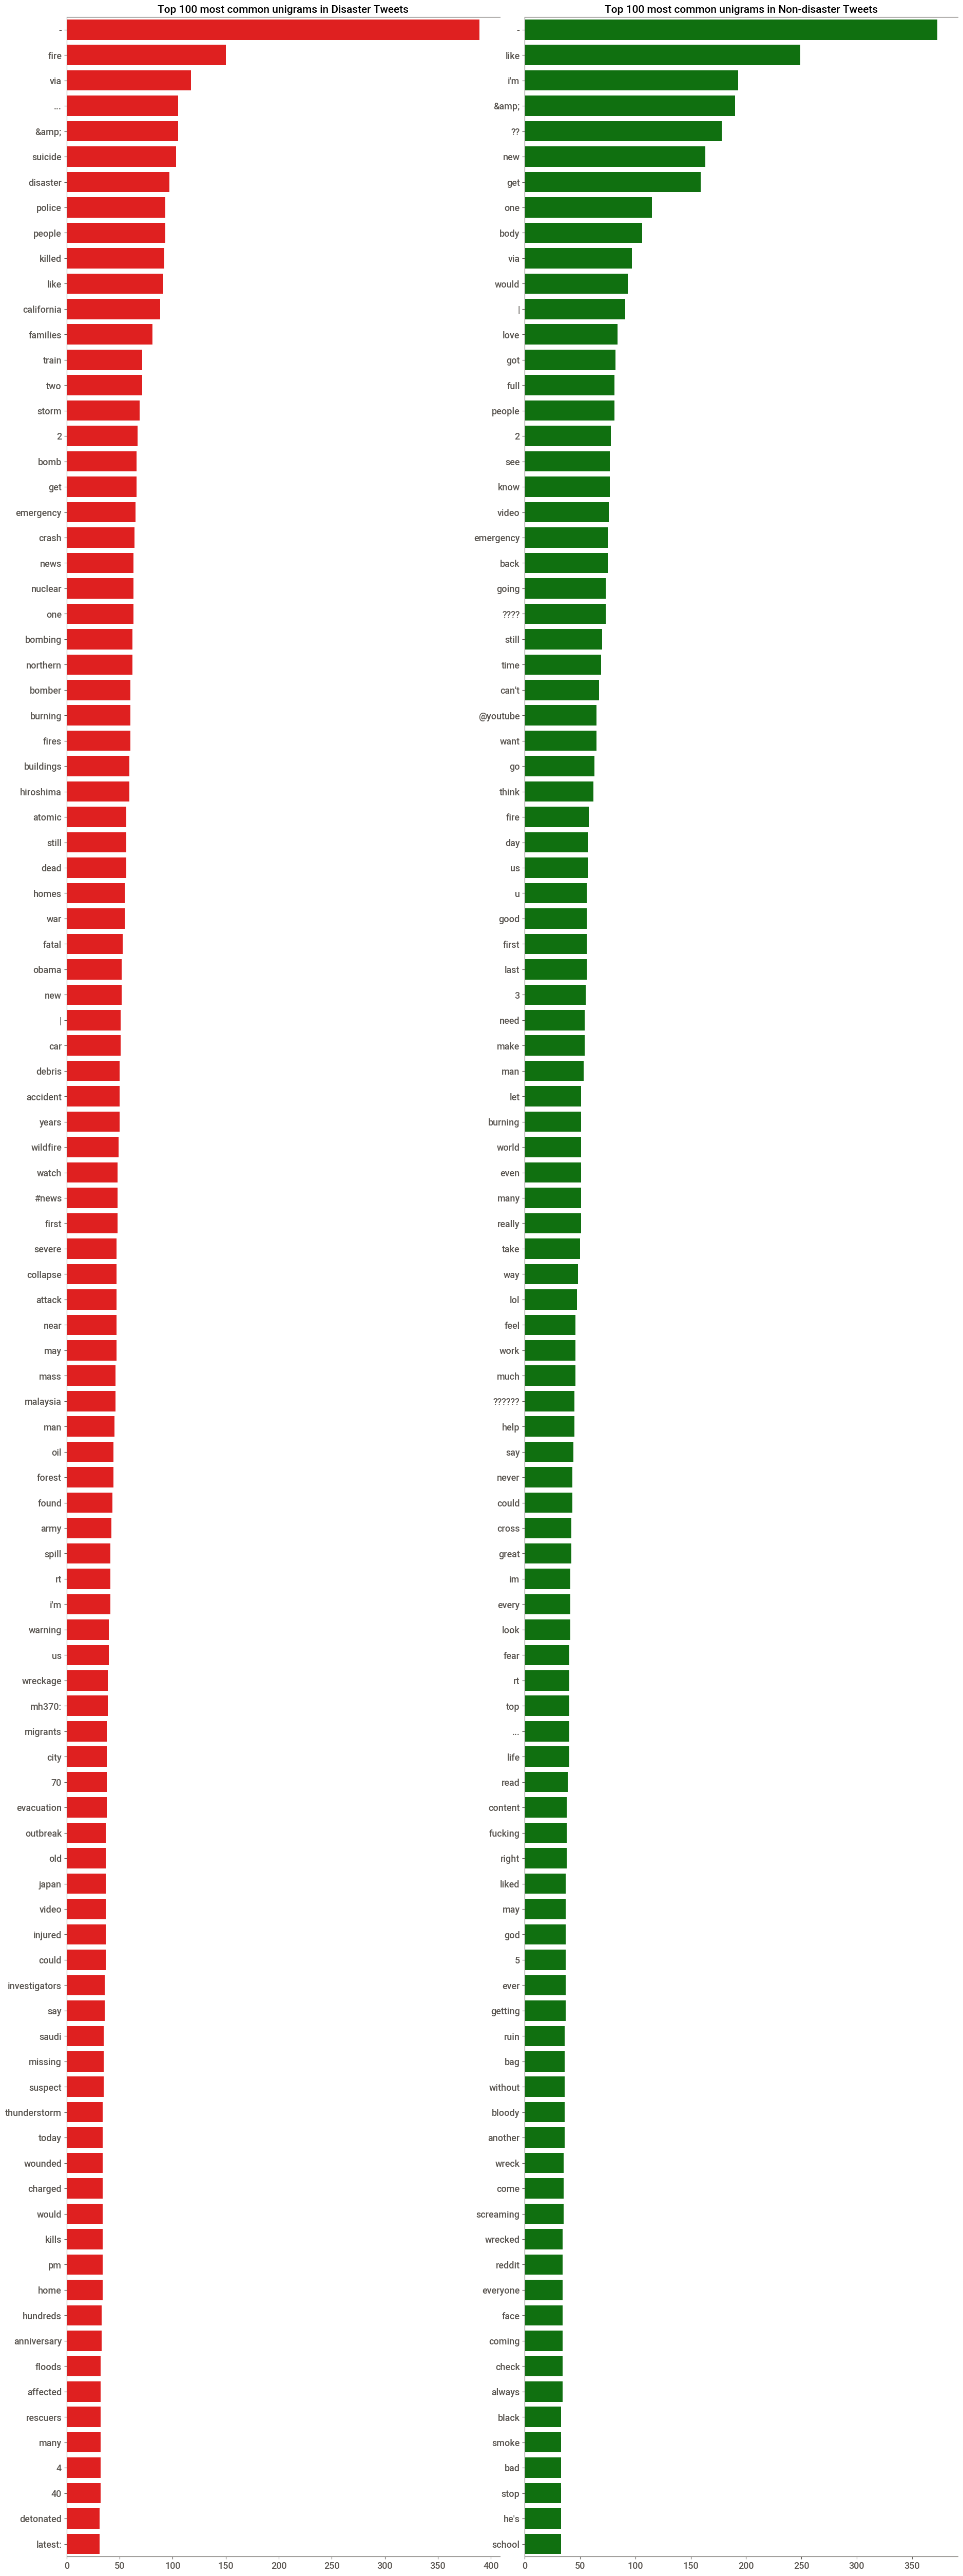

In [16]:

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

两个类中最常见的一元词大多是**标点符号、停用词或数字**。 最好在建模之前清理它们，因为它们没有提供太多关于目标的信息。

灾难推文中最常见的一元组已经在提供有关灾难的信息。 在其他情况下很难使用其中一些词。

非灾难推文中最常见的一元组是动词。 这是有道理的，因为这些句子中的大多数都具有非正式的主动结构，因为它们来自个人用户。


W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


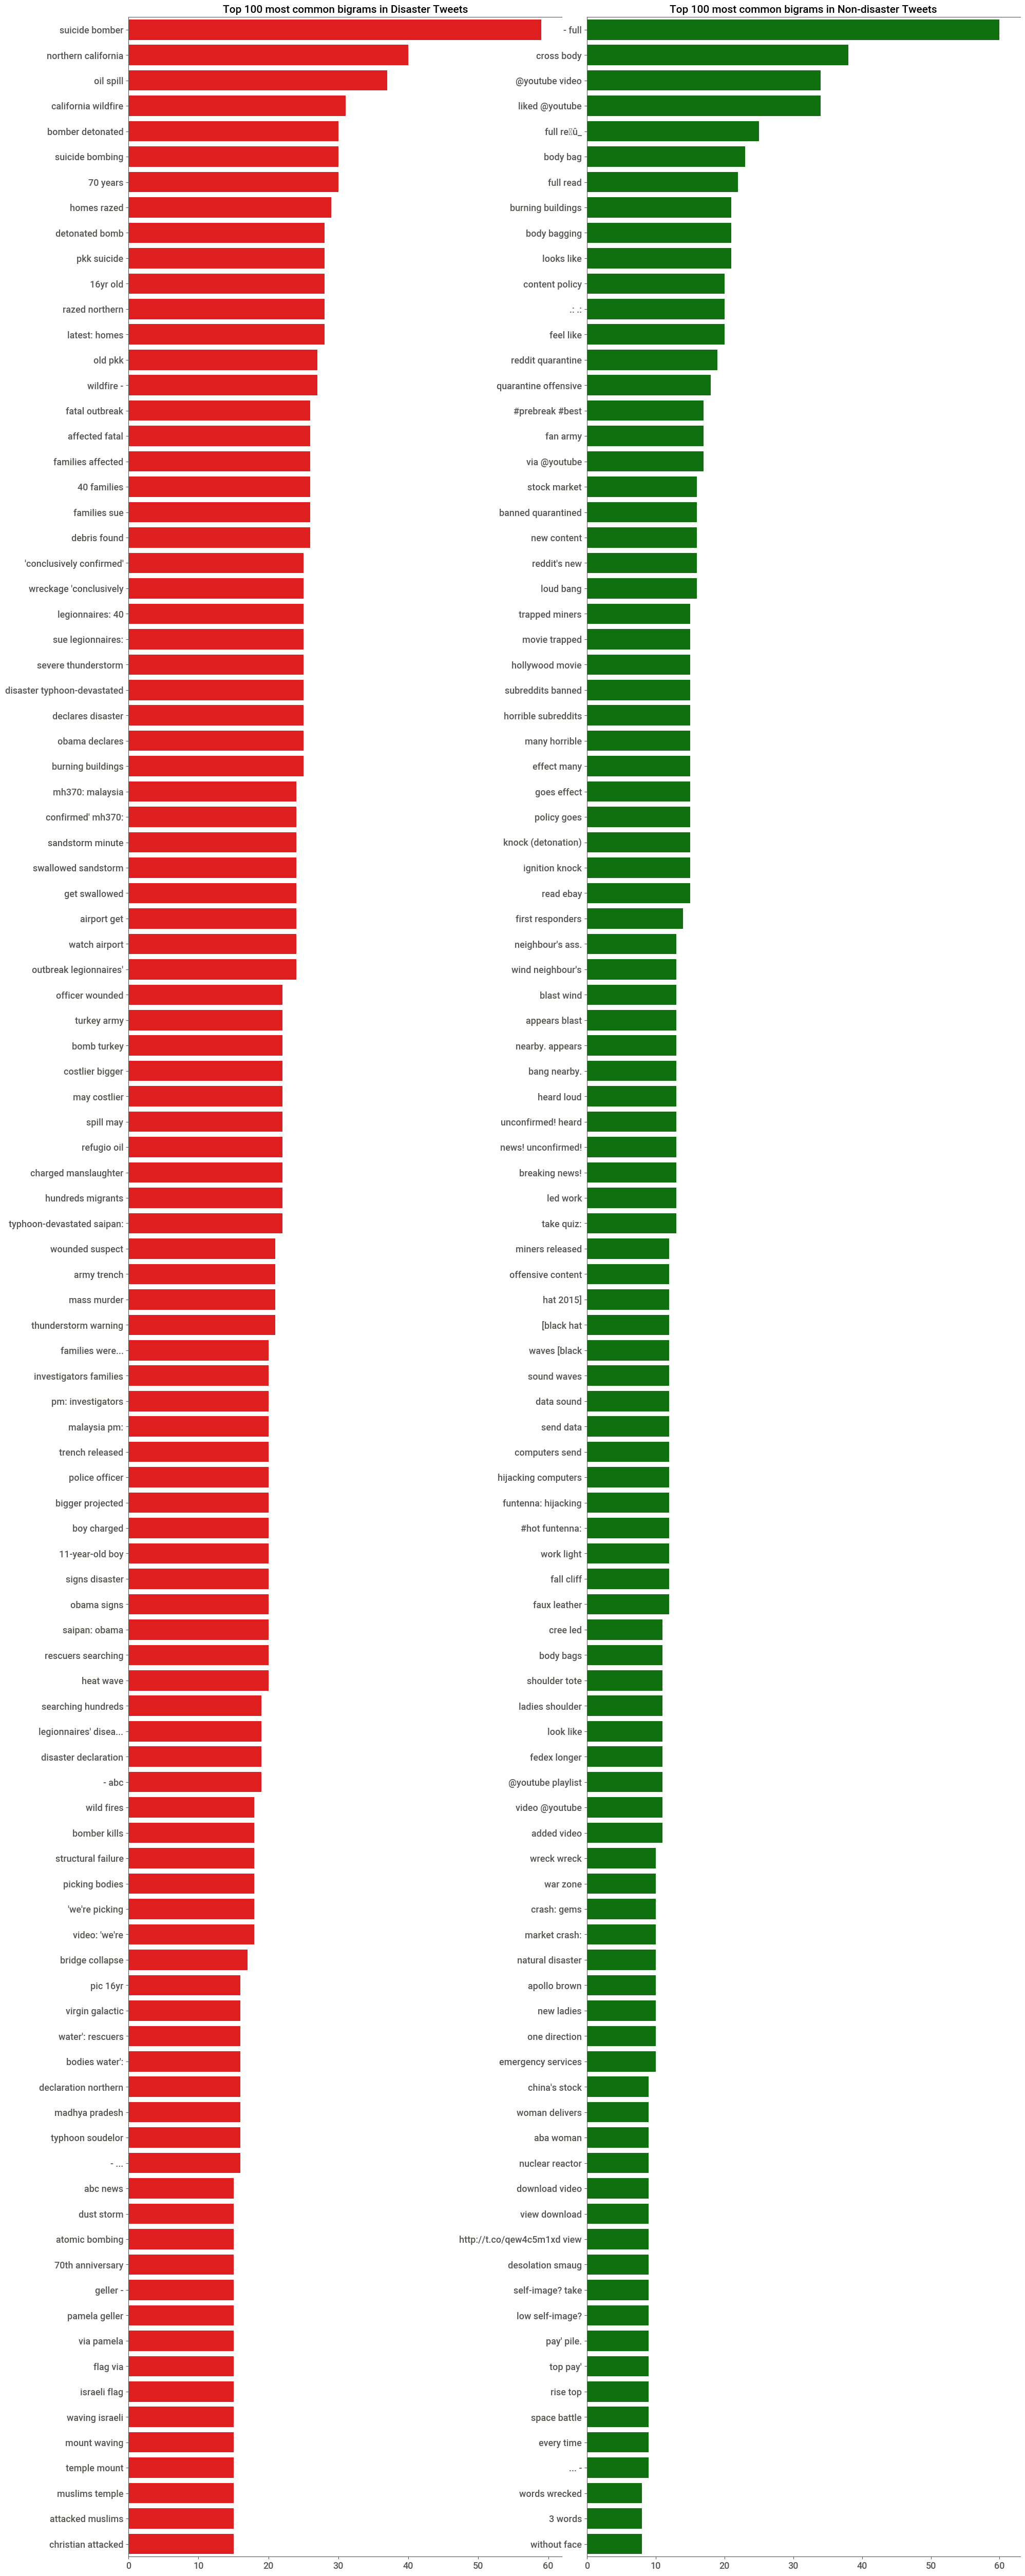

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

两个类中不存在共同的二元组，因为上下文更清晰。

灾难推文中最常见的二元组比一元组提供更多有关灾难的信息，但必须从单词中去除标点符号。

非灾难推文中最常见的二元组大多是关于 reddit 或 youtube 的，它们包含很多标点符号。 **这些标点符号也必须从单词中清除。**

W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


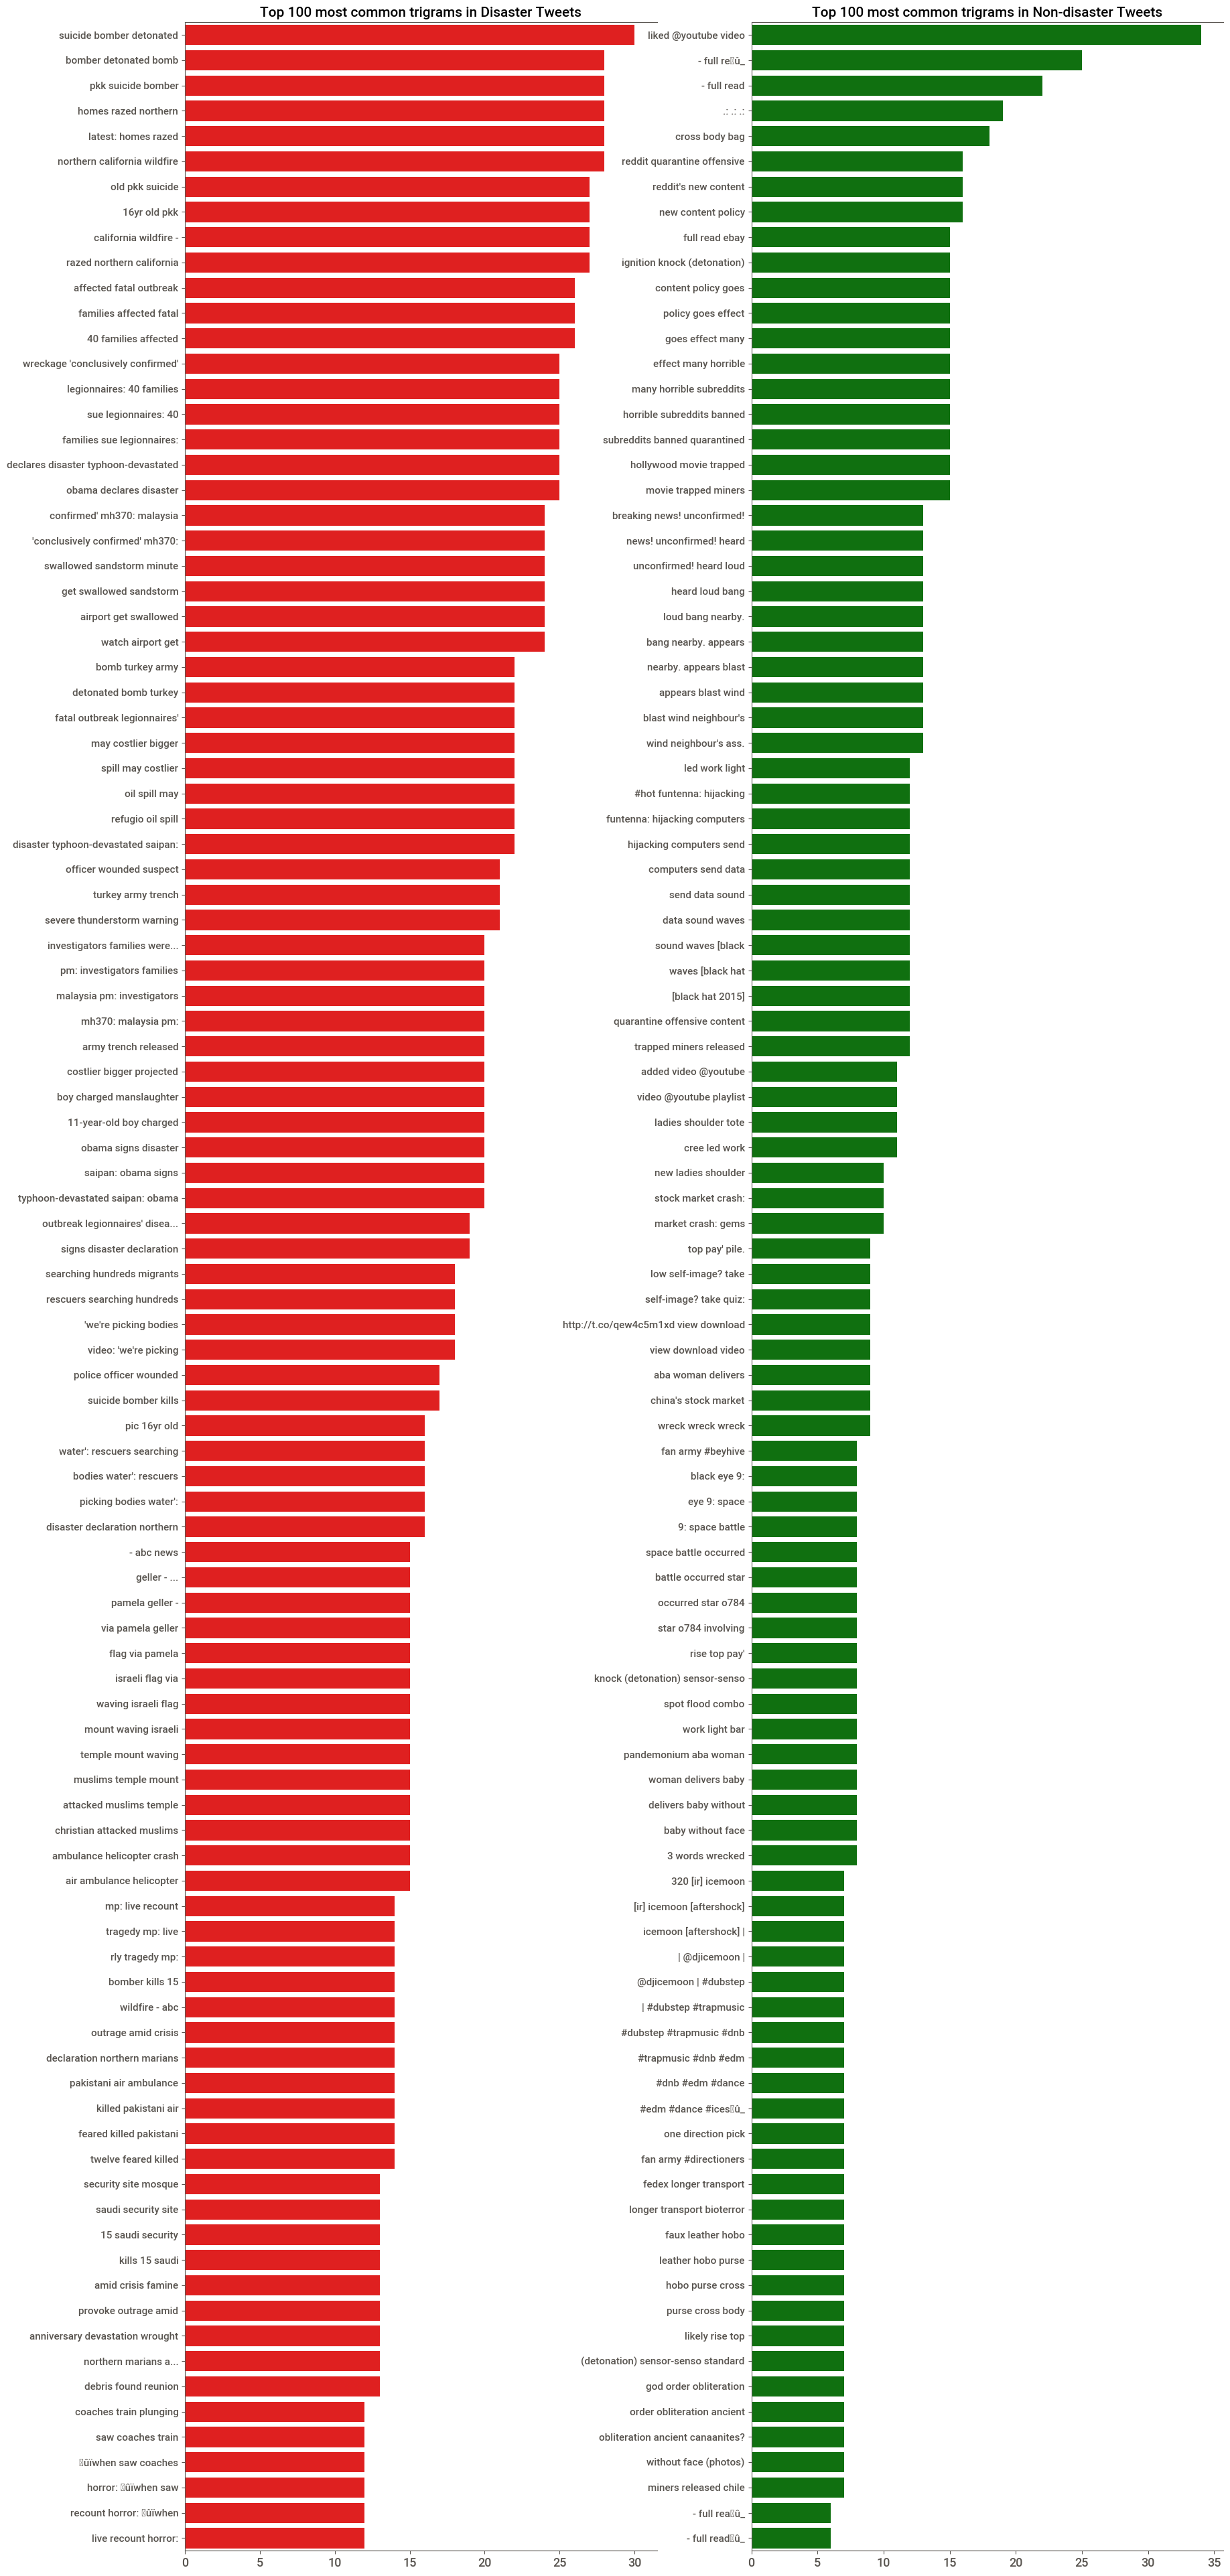

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

两个类中不存在共同的三元组，因为上下文更清晰。

灾难推文中最常见的三元组与二元组非常相似。 它们提供了大量有关灾难的信息，但它们可能不提供任何附加信息以及二元组。

非灾难推文中最常见的三元组也与二元组非常相似，它们包含更多的标点符号。

# Embeddings and Text Cleaning 
4.1 嵌入覆盖
当您有预训练的embeddings时，执行标准的预处理步骤可能不是一个好主意，因为一些有价值的信息可能会丢失。

最好让词汇表尽可能接近embeddings。为了做到这一点，通过计算推文中的单词来创建训练词汇和测试词汇。

文本清理基于以下嵌入：

1. GloVe-300d-840B
2. FastText-Crawl-300d-2M

In [19]:
%%time
# import pickle

# with open('input/glove.840B.300d.pkl') as fp:
#     glove = pickle.load(fp)

#glove_embeddings = np.load('input/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('crawl-300d-2M.pkl', allow_pickle=True)

Wall time: 8.23 s


检查预训练embedding的词汇表的覆盖率

In [20]:
import operator

def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    # 检查单个单词在两个字典中的覆盖率。并且记录它们的出现次数。
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

# train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
# test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


## 4.2 文本清洗

推文需要大量清理，但清理每条推文效率低下，因为这会消耗太多时间。必须采用通用方法进行清洁。

+ 在 oov 中需要清理的最常见类型的单词在开头或结尾都有标点符号。 由于尾随标点符号，这些词没有嵌入。 标点符号#、@、!、?、+、&、-、$、=、<、>、|、{、}、^、'、(、)、[、]、*、%、...、' , ., :, ; 与单词分开
+ 附加到单词的特殊字符被完全删除
+ Contractions are expanded。缩写扩充
+ 删除网址
+ 字符实体引用被替换为它们的实际符号
+ 错别字和俚语得到纠正，非正式缩写以长形式书写
+ 一些单词被它们的首字母缩写词替换，一些单词被归为一组
+ 最后，#hashtag和用户名包含大量有关上下文的信息，但它们在单词之间没有空格，因此它们没有嵌入。 应该扩展信息用户名和主题标签，但它们太多了。 我尽可能多地扩展，但是在添加这些替换调用后运行 clean 函数需要太多时间。

In [21]:
%%time
import re

def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

# train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
# test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

FastText Embeddings cover 82.88% of vocabulary and 97.12% of text in Training Set
FastText Embeddings cover 87.80% of vocabulary and 97.25% of text in Test Set
Wall time: 4min 22s


感觉这样需要引入太多的先验经验了。可复现性较低。感觉可以复现的：
+ 标点符号（特殊符号）替换
+ 缩写拆分('s, n't)
+ 驼峰拆分（长词根据驼峰法拆分）
+ 网址替换（删除https等信息，替换为网址地址中蕴含的信息）
+ 大小写转换

清理推文后，glove_embeddings 和 fasttext_embeddings 将被删除并进行垃圾收集，因为它们消耗了太多内存（10+ GB）。

In [22]:
import gc
#del glove_embeddings,train_glove_oov, test_glove_oov,
del fasttext_embeddings,  train_fasttext_oov, test_fasttext_oov
gc.collect()

534285

# 5. 错误标记的样本
训练集中有 18 条独特的推文，它们的重复标签不同。 这些推文可能被不同的人标记，他们对含义的解释也不同，因为其中一些不是很清楚。 具有两个唯一目标值的推文会被重新标记，因为它们会影响训练分数。

这个能看出来太不容易了。属实需要点细心了。

In [23]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [24]:
# 重新打标签
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

# 7. 模型
## 7.1 评价指标

排行榜基于平均 F 分数，可以使用宏观平均 F1 分数来实现。但是，如果没有 Accuracy、Precision 和 Recall，它的信息量不会很大，因为类几乎是平衡的，而且很难判断哪个类更难预测。

accuracy衡量正确识别的总样本的比例

percision测量在所有预测为正的示例中，有多少实际上是正的

回想一下，在所有实际正例中，有多少示例被模型正确分类为正例
F1 Score 是 Precision 和 Recall 的调和平均值

Keras 在其指标模块中具有准确性，但没有上述其他指标。另一个关键点是 Precision、Recall 和 F1-Score 是全局指标，因此应该在整个训练集或验证集上计算它们。在每批上计算它们在执行时间方面既误导又无效。类似于 sklearn.metrics.classification_report 的分类报告，在给定训练和验证集的每个 epoch 之后计算这些指标。

## 7.2 BERT 层
该模型使用 GitHub 上 TensorFlow 模型存储库 tensorflow/models/official/nlp/bert 中的 BERT 实现。 它使用 L=12 个隐藏层（Transformer blocks），隐藏大小为 H=768，A=12 个注意力头。

该模型已在 Wikipedia 和 BooksCorpus 上针对英语进行了预训练。 输入已经“不区分大小写”，这意味着文本在标记为单词之前已经小写，并且所有重音标记都已被剥离。 为了下载这个模型，必须在内核上激活 Internet。

## 7.3 架构
DisasterDetector 是一个包含上述交叉验证和指标的包装器。

输入文本的标记化是使用 tensorflow/models/official/nlp/bert/tokenization.py 中的 FullTokenizer 类执行的。 max_seq_length 参数可用于调整文本的序列长度。

lr、epochs 和 batch_size 等参数可用于控制学习过程。 在 BERT 的最后一层之后没有添加密集层或池化层。 SGD 被用作优化器，因为其他人在收敛时很难。

plot_learning_curve 绘制每个 epoch 之后存储的准确率、精度、召回率和 F1 分数（用于验证集）以及训练/验证损失曲线。 这有助于查看训练时哪个指标波动最大。

In [150]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, tokenizer, x, y=None):
        self.data = tokenizer(x, return_tensors='pt', padding=True, truncation=True)
        #print(self.data.keys())
        if y is not None:
            self.y = torch.LongTensor(y)
        else:
            self.y=None
    
    def __len__(self):
        return self.data['input_ids'].shape[0]
    
    def __getitem__(self, idx):
        return {
            "input_ids":self.data['input_ids'][idx],
            "attention_mask":self.data['attention_mask'][idx],
            "labels":self.y[idx]
        }
        # if self.y is not None:
        #     return self.data['input_ids'][idx], self.data['attention_mask'][idx], self.y[idx]
        # return self.data['input_ids'][idx], self.data['attention_mask']


df_train_idx, df_valid_idx = train_test_split(df_train.index, train_size=0.8, random_state=RANDOM_STATE)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_dataset = MyDataset(tokenizer, df_train.iloc[df_train_idx]["text_cleaned"].tolist(), df_train.iloc[df_train_idx]["target"].tolist())
valid_dataset = MyDataset(tokenizer, df_train.iloc[df_valid_idx]["text_cleaned"].tolist(), df_train.iloc[df_valid_idx]["target"].tolist())
test_dataset = MyDataset(tokenizer, df_test["text_cleaned"].tolist())

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=16)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [151]:
next(iter(train_dataloader))

{'input_ids': tensor([[    0,   104,  4291,  ...,     1,     1,     1],
         [    0,  3684,  1746,  ...,     1,     1,     1],
         [    0, 39740,  8293,  ...,     1,     1,     1],
         ...,
         [    0, 46182,     9,  ...,     1,     1,     1],
         [    0, 40039,  5338,  ...,     1,     1,     1],
         [    0,   128,   318,  ...,     1,     1,     1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0])}

In [152]:
len(train_dataloader) # batch的个数

381

In [165]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding


tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model.to("cpu")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer
    #data_collator=data_collator,
)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file roberta-base\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Didn't find file roberta-base\added_tokens.json. We won't load it.
Didn't find file roberta-base\special_tokens_map.json. We won't load it.
Didn't find file roberta-base\tokenizer_config.json. We won't load it.
loading

In [166]:
trainer.train()

***** Running training *****
  Num examples = 6090
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3810


Exception: Run with UUID e0cb8ea3834d44aeadb1ff27b88d75ae is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [153]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report,precision_score,recall_score
from tqdm import tqdm
import torch.nn.functional as F

class SequenceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrain_model = AutoModel.from_pretrained("roberta-base")
        # 冻结bert模型权重，不用bert参与训练
        
        
        # Bert隐藏层大小的输出是768.
        self.fc = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 2)
        )
        #self.fc = nn.Linear(768,2)

    def forward(self, input_ids, attention_mask, **kwargs):
        #print(x)
        #print(len(x))
        # last_hidden_state, pooler_output
        out  = self.pretrain_model(input_ids, attention_mask)
        pooler_output = out.pooler_output # 获取<cls>符号对应的embedding
        logits = self.fc(pooler_output)
        logits = F.softmax(logits, dim=1)
        return logits
    


def train(model, optimizer, epochs, train_dataloader, valid_dataloader, loss_fn=nn.CrossEntropyLoss(), verbose=True):
    
    for cur_epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        train_loss = []
        for batch in train_dataloader:
            optimizer.zero_grad()
            batch = {key:batch[key].to("cuda") for key in batch}
            logits = model(**batch)
            loss = loss_fn(logits, batch["labels"])
            loss.backward()
            optimizer.step()
        
            train_loss.append(loss.detach().cpu().numpy())
        train_loss = sum(train_loss)/len(train_loss)
        
        # validation
        with torch.no_grad():
            model.eval()
            valid_loss = []
            predictions_list = list()
            labels_list = list()
            for batch in valid_dataloader:
                batch = {key:batch[key].to("cuda") for key in batch}
                logits = model(**batch)
                loss = loss_fn(logits, batch["labels"])
                valid_loss.append(loss.detach().cpu().numpy())
                
                labels_numpy = batch['labels'].detach().cpu().numpy()
                predictions_numpy = torch.argmax(logits, dim=-1).detach().cpu().numpy()
                labels_list.append(labels_numpy)
                predictions_list.append(predictions_numpy)

            labels_numpy = np.concatenate(labels_list,axis=0)
            preditions_numpy = np.concatenate(predictions_list, axis=0)
            precisions = precision_score(labels_numpy,  preditions_numpy)
            recalls = recall_score(labels_numpy, preditions_numpy)
            
        valid_loss = sum(valid_loss)/len(valid_loss)
        if verbose:
            #metrics = {metrics[key] for key in metrics}
            print(f"epoch {cur_epoch}, train loss: {train_loss}, valid_loss: {valid_loss}, precision: {precisions}, recall: {recalls}")

from torch.optim import Adam
gc.collect()
sc = SequenceClassifier()
sc = sc.to("cuda")

# for param in sc.pretrain_model.parameters():
#     param.requires_grad = False
    
optimizer = Adam(sc.parameters(), lr=0.0001)
train(sc, optimizer, 10, train_dataloader, valid_dataloader)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/10 [00:00<?, ?it/s]W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

epoch 1, train loss: 0.6838544569616243, valid_loss: 0.6842209218690792, precision: 0.0, recall: 0.0


W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 2/10 [03:47<15:13, 114.23s/it]

epoch 2, train loss: 0.6835417993112499, valid_loss: 0.683361116796732, precision: 0.0, recall: 0.0


 20%|██        | 2/10 [04:04<16:18, 122.37s/it]


KeyboardInterrupt: 

In [ ]:
for param in sc.parameters():
    if param.requires_grad == True:
        print(param)
        

Parameter containing:
tensor([[-2.7639e-02, -3.7779e-03, -8.0552e-03,  ..., -2.0474e-02,
          1.0587e-02,  1.7528e-02],
        [-8.9721e-03, -1.1812e-02, -2.0634e-03,  ...,  3.2128e-02,
         -2.5953e-02,  3.2670e-03],
        [ 1.4609e-02, -2.4497e-02,  2.2250e-02,  ...,  2.9145e-02,
          1.1208e-05, -1.1462e-02],
        ...,
        [-2.5945e-02,  2.4182e-02, -5.7190e-03,  ...,  5.6357e-03,
          1.8662e-02, -8.3691e-03],
        [-2.4046e-02, -1.6549e-02,  8.8362e-04,  ..., -1.3232e-02,
         -2.3465e-02, -6.3500e-03],
        [-2.8445e-02,  2.8409e-03,  2.7689e-02,  ..., -2.7386e-02,
          9.4127e-03,  2.3588e-02]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.2106e-02, -3.3825e-02,  3.0402e-02, -3.5545e-02,  1.9295e-03,
        -2.3415e-02, -3.2879e-02, -1.4446e-02,  2.5370e-03, -1.0937e-02,
         1.7320e-02, -2.3878e-02, -2.5242e-02, -7.1804e-04, -1.9359e-02,
         1.8979e-02, -1.5066e-02, -3.5148e-02,  2.3912e-03,  3.4009e